In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from datetime import date
from datetime import datetime
# import geoip2.database
import folium
import tkinter as tk
from tkinter import filedialog
geoip_db_path = "GeoLite2-City_20240607/GeoLite2-City.mmdb"
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.max_rows', 25)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("/content/drive/MyDrive/ag_traffic.csv")

In [2]:
def check_df(dataframe, head=5):
    print("##################### Shape ##########################")
    print(dataframe.shape)
    print("##################### Types ##########################")
    print(dataframe.dtypes)
    print("##################### Head ##########################")
    print(dataframe.head(head))
    print("##################### Tail ##########################")
    print(dataframe.tail(head))
    print("##################### Na ##########################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles ##########################")
    print(dataframe.describe([0.01, 0.05, 0.25, 0.50, 0.9, 0.95, 0.99]).T)
check_df(df)

##################### Shape ##########################
(160983, 165)
##################### Types ##########################
sync_name                  object
source_address             object
destination_address        object
source_port                 int64
destination_port            int64
                           ...   
session_id                 object
session_id_from_time       object
protocol_name              object
source_asset_type         float64
destination_asset_type    float64
Length: 165, dtype: object
##################### Head ##########################
     sync_name source_address destination_address  source_port  destination_port  protocol  app_protocol application_name application_category_name master_application_name  tunnel_source_address  tunnel_destination_address         source_mac    destination_mac  tunnel_value  package_count  login_fail_count  login_success  expiration_id  drop_eligible  priority  vlan_identifier  \
0  master-node  192.168.2.100         

In [3]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

# Fonksionun okunabilirliği düşmemesi için date ve zaman değişkenlerini num cols tan çektim.
num_cols = [col for col in num_cols if col not in "event_time"]

Observations: 160983
Variables: 165
cat_cols: 66
num_cols: 63
cat_but_car: 36
num_but_cat: 43


In [4]:
############################## KATEGORİK DEĞİŞKENLERİN ANALİZİ

def cat_summary(dataframe, col_name, plot=False):
    """
    Fonksiyonun amacı, bir pandas veri çerçevesindeki belirtilen kategorik
    sütunların frekans ve oranlarını hesaplamak ve istenirse bu frekansları görselleştirmektir.

    Parameters
    ----------
    dataframe: Üzerinde işlem yapılacak pandas veri çerçevesi.
    col_name: Kategorik değişkenin adı (sütun adı).
    plot : Bu parametre True olarak verilirse, değişkenin frekans dağılımını bir bar grafiği ile gösterir.
    Varsayılan değeri False'tur.

    Returns
    -------

    """

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)

cat_summary(df,col)
df.head(5)

# TODO: Rare Encoding ihtiyacımız bulunuyor.
# TODO: Label Encoding ihtiyacımız bulunuyor.
# TODO: Model kurmamız gerekseydi Enkoding işlemlerini bu fonksiyon aracılığıyla yapmam gerekecekti.

             sync_name   Ratio
sync_name                     
master-node     160983 100.000
##########################################
                         master_application_name  Ratio
master_application_name                                
Unknown                                   125291 77.829
DNS                                        21315 13.241
ARP                                        11478  7.130
NetBIOS                                     2144  1.332
TLS                                          456  0.283
QUIC                                         242  0.150
HTTP                                          54  0.034
STUN                                           3  0.002
##########################################
                domain  Ratio
domain                       
NotFound        159897 99.325
WORKGROUP          943  0.586
PAVO-GROUP.COM      61  0.038
PAVO                39  0.024
TEST.LOCAL          12  0.007
pavo-group.com      11  0.007
ntatest.local        

sync_name source_address destination_address  source_port  destination_port  protocol  app_protocol application_name application_category_name master_application_name  tunnel_source_address  tunnel_destination_address         source_mac    destination_mac  tunnel_value  package_count  login_fail_count  login_success  expiration_id  drop_eligible  priority  vlan_identifier  \
0  master-node  192.168.2.100         192.168.0.1            0                 0         0          1000      ARP-Request                       ARP                     ARP                    NaN                         NaN  00:50:56:a6:4d:5e  ff:ff:ff:ff:ff:ff             0              1                 0              0              0          False         0                0   
1  master-node   10.10.10.140          10.10.10.1            0                 0         0          1000      ARP-Request                       ARP                     ARP                    NaN                         NaN  00:50:56:a6:ad:2a  ff:ff:ff:ff:ff:ff             0              1                 0              0              0          False         0                0   
2  master-node   10.10.92.254         10.10.92.22            0                 0         0          1000        ARP-Reply                       ARP                     ARP                    NaN                         NaN  00:1b:17:00:03:40  00:50:56:a6:3b:50             0              1                 0              0              0          False         0                0   
3  master-node     10.1.66.11          10.1.66.12            0                 0         0          1000      ARP-Request                       ARP                     ARP                    NaN                         NaN  00:50:56:a6:f3:fd  ff:ff:ff:ff:ff:ff             0              1                 0              0              0          False         0                0   
4  master-node  10.10.107.254        10.10.107.11            0                 0         0          1000        ARP-Reply                       ARP                     ARP                    NaN                         NaN  00:1b:17:00:03:40  00:50:56:a6:c3:a9             0              1                 0              0              0          False         0                0   

                       event_time  bidirectional_first_seen_ms  bidirectional_last_seen_ms  bidirectional_duration_ms  bidirectional_bytes  bidirectional_max_piat_ms  bidirectional_max_ps  bidirectional_mean_piat_ms  bidirectional_mean_ps  bidirectional_min_piat_ms  bidirectional_min_ps  bidirectional_packets  bidirectional_stddev_piat_ms  bidirectional_stddev_ps  bidirectional_syn_packets  \
0  2024-03-18T14:07:19.738372034Z             1710770835765056            1710770835765056                          0                    0                          0                     0                           0                  0.000                          0                     0                      0                             0                    0.000                          0   
1  2024-03-18T14:07:19.738420516Z             1710770835955889            1710770835955889                          0                    0                          0                     0                           0                  0.000                          0                     0                      0                             0                    0.000                          0   
2  2024-03-18T14:07:19.738504769Z             1710770836359395            1710770836359395                          0                    0                          0                     0                           0                  0.000                          0                     0                      0                             0                    0.000                          0   
3  2024-03-18T14:07:19.738760638Z             1710770837764519            1710770837764519                          0     

count   160983.000
mean     44738.476
std      16388.847
min          0.000
5%           0.000
10%      24186.200
20%      36616.400
30%      40928.000
40%      45278.000
50%      49319.000
60%      52188.000
70%      55086.000
80%      57352.000
90%      59715.000
95%      61596.000
99%      64711.000
max      65535.000
Name: source_port, dtype: float64


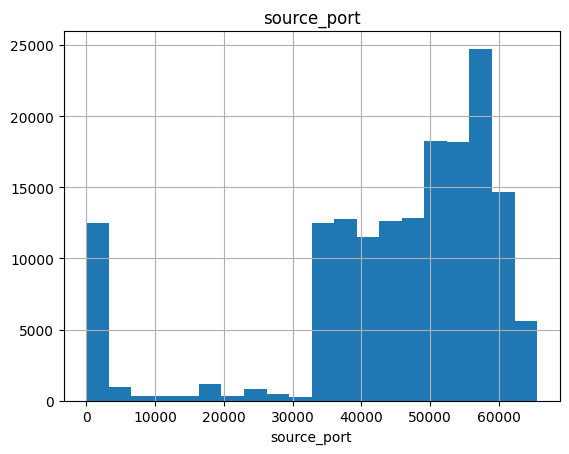

count   160983.000
mean      4696.862
std       6108.150
min          0.000
5%           0.000
10%         53.000
20%         53.000
30%         53.000
40%         53.000
50%        443.000
60%       9200.000
70%      10050.000
80%      10050.000
90%      10050.000
95%      10050.000
99%      10051.000
max      65389.000
Name: destination_port, dtype: float64


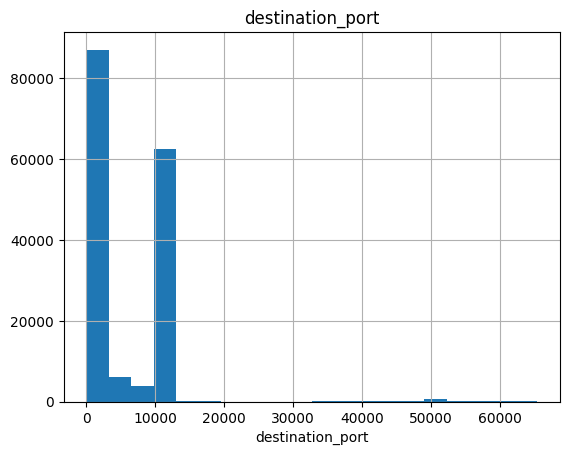

count   160983.000
mean       202.292
std        244.544
min          0.000
5%           5.000
10%          5.000
20%          5.000
30%         41.000
40%        111.000
50%        212.000
60%        248.000
70%        248.000
80%        248.000
90%        248.000
95%       1000.000
99%       1000.000
max       1003.000
Name: app_protocol, dtype: float64


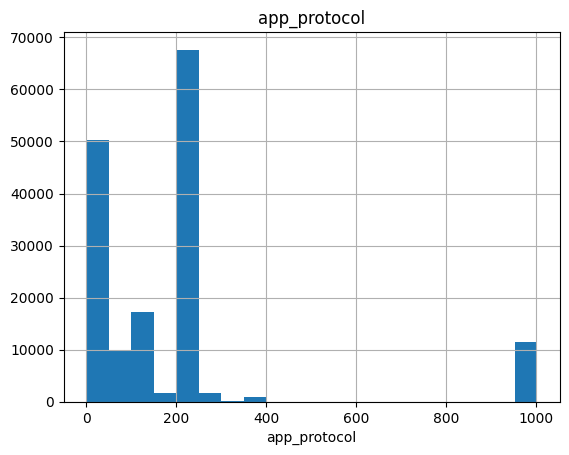

count    160983.000
mean         95.694
std        7936.783
min           1.000
5%            1.000
10%           2.000
20%           2.000
30%           2.000
40%           4.000
50%           9.000
60%          10.000
70%          12.000
80%          20.000
90%          24.000
95%          48.000
99%         289.180
max     2117154.000
Name: package_count, dtype: float64


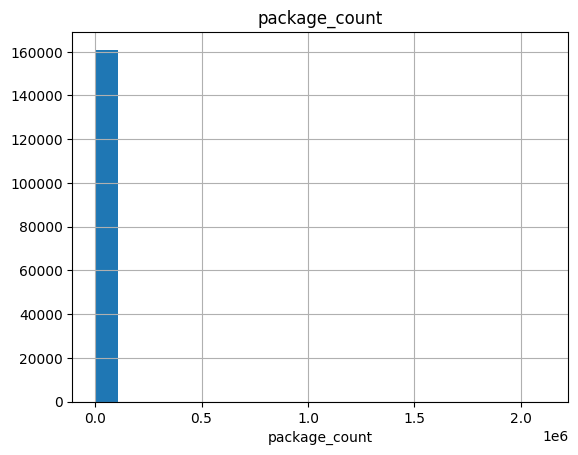

count             160983.000
mean    1710771356888994.750
std            310305543.386
min     1710770820007229.000
5%      1710770875330096.000
10%     1710770928671803.500
20%     1710771034155066.500
30%     1710771137262121.750
40%     1710771247043931.500
50%     1710771358779729.000
60%     1710771468364824.500
70%     1710771571539972.000
80%     1710771675116605.750
90%     1710771785526876.750
95%     1710771841852915.500
99%     1710771891096490.000
max     1710771899997409.000
Name: bidirectional_first_seen_ms, dtype: float64


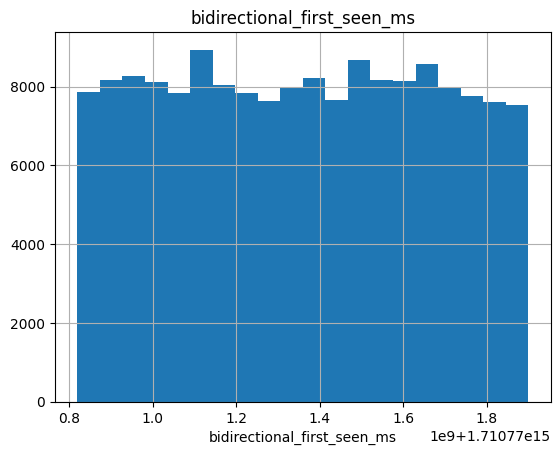

count             160983.000
mean    1710771366202675.500
std            313119451.267
min     1710770820008125.000
5%      1710770879994400.000
10%     1710770934611723.750
20%     1710771042069772.500
30%     1710771146753455.750
40%     1710771256150925.500
50%     1710771367709228.000
60%     1710771476296128.000
70%     1710771582566303.750
80%     1710771684956073.500
90%     1710771795210241.500
95%     1710771852115800.500
99%     1710771898466524.000
max     1710772196265394.000
Name: bidirectional_last_seen_ms, dtype: float64


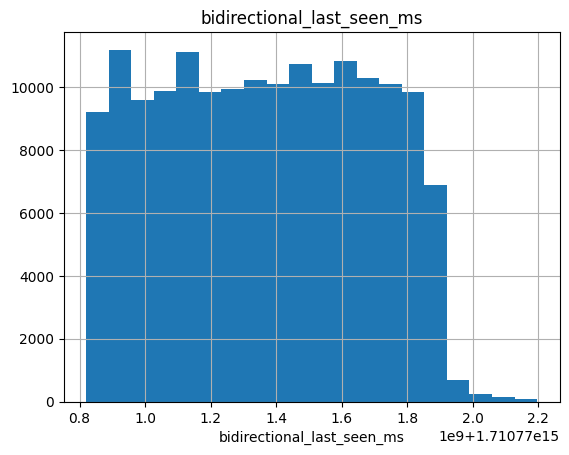

count      160983.000
mean      9313681.032
std      40931514.584
min             0.000
5%              0.000
10%           308.000
20%           558.000
30%          1343.000
40%          2135.000
50%          2827.000
60%          5424.000
70%         43233.000
80%        130412.200
90%       2011098.800
95%      62150863.500
99%     278529061.960
max     299999999.000
Name: bidirectional_duration_ms, dtype: float64


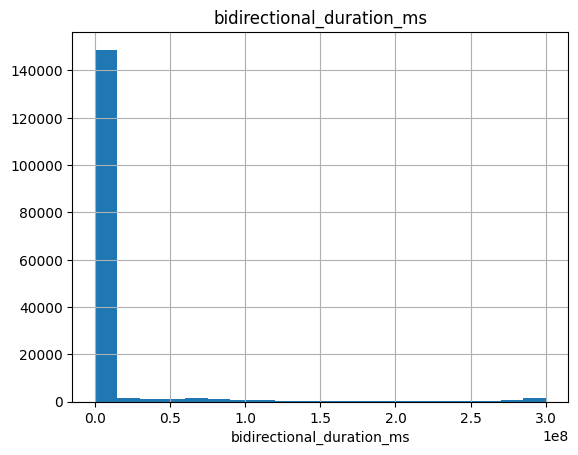

count       160983.000
mean         86074.703
std        9718448.692
min              0.000
5%               0.000
10%             36.000
20%             66.000
30%            100.000
40%            126.000
50%            160.000
60%            211.000
70%            313.000
80%            860.000
90%           4730.000
95%           7468.000
99%         129987.000
max     2680427144.000
Name: bidirectional_bytes, dtype: float64


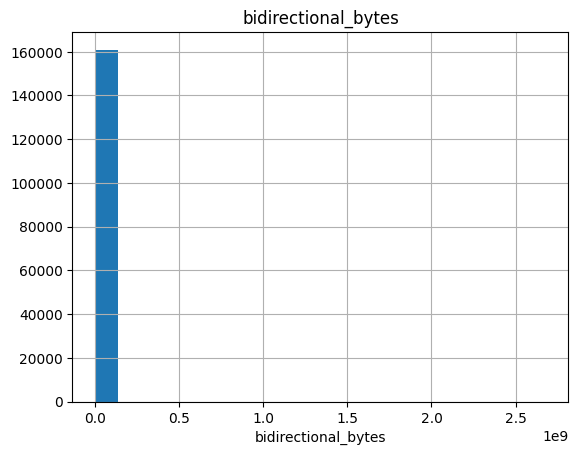

count      160983.000
mean      4211265.021
std      16816329.500
min             0.000
5%              0.000
10%           246.000
20%           378.000
30%           504.000
40%           719.000
50%          1188.000
60%          3093.200
70%         28145.000
80%         61810.800
90%       1895733.400
95%      30014057.600
99%      99025238.160
max     119999877.000
Name: bidirectional_max_piat_ms, dtype: float64


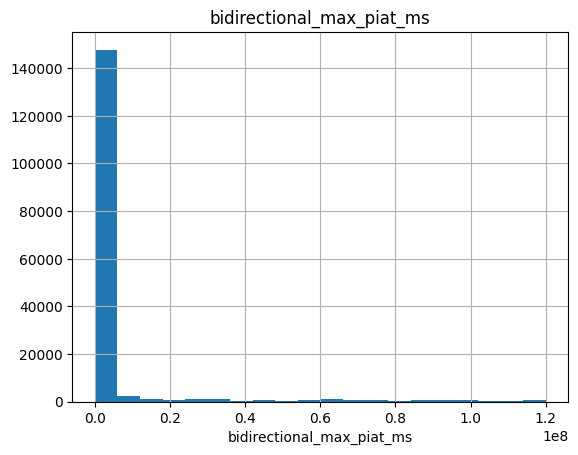

count   160983.000
mean       311.868
std        565.182
min          0.000
5%           0.000
10%         21.000
20%         36.000
30%         49.000
40%         67.000
50%         97.000
60%        126.000
70%        166.000
80%        314.000
90%       1448.000
95%       1448.000
99%       1460.000
max      64512.000
Name: bidirectional_max_ps, dtype: float64


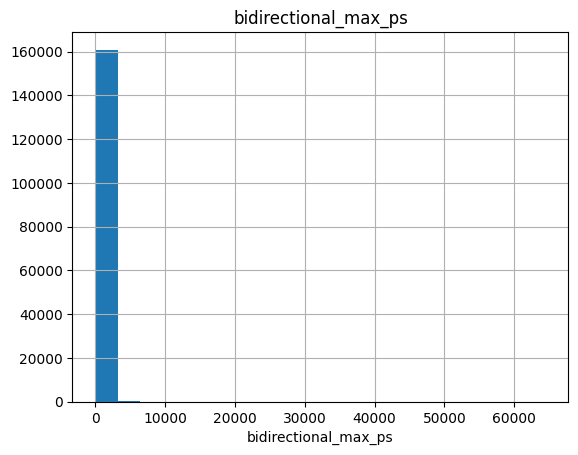

count      160983.000
mean       788063.308
std       4103989.976
min             0.000
5%              0.000
10%            96.000
20%           167.000
30%           269.000
40%           358.000
50%           465.000
60%           729.000
70%          8559.400
80%         35308.200
90%        205219.400
95%       3213621.500
99%      24938623.080
max     119998063.000
Name: bidirectional_mean_piat_ms, dtype: float64


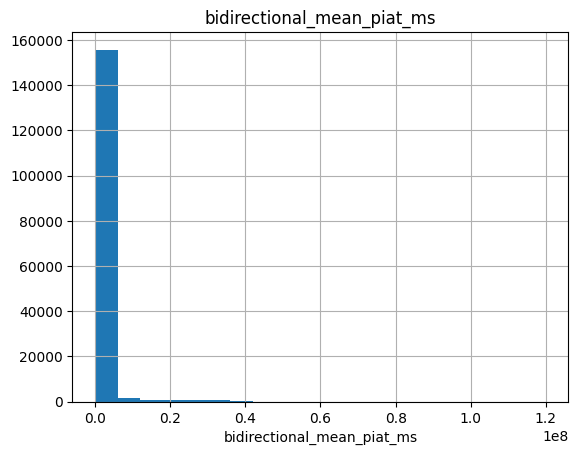

count   160983.000
mean        93.141
std        175.546
min          0.000
5%           0.000
10%          3.455
20%          5.900
30%         10.100
40%         17.778
50%         45.000
60%         68.000
70%         87.333
80%        137.500
90%        226.846
95%        322.500
99%        928.955
max       4709.500
Name: bidirectional_mean_ps, dtype: float64


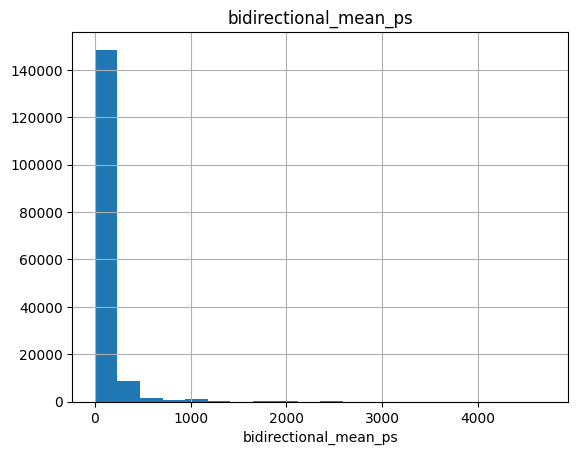

count      160983.000
mean        60521.689
std       1460814.577
min           -15.000
5%              0.000
10%             2.000
20%             5.000
30%             7.000
40%            11.000
50%            19.000
60%            56.000
70%           340.000
80%           579.000
90%         43287.000
95%         54777.900
99%        804428.880
max     119998063.000
Name: bidirectional_min_piat_ms, dtype: float64


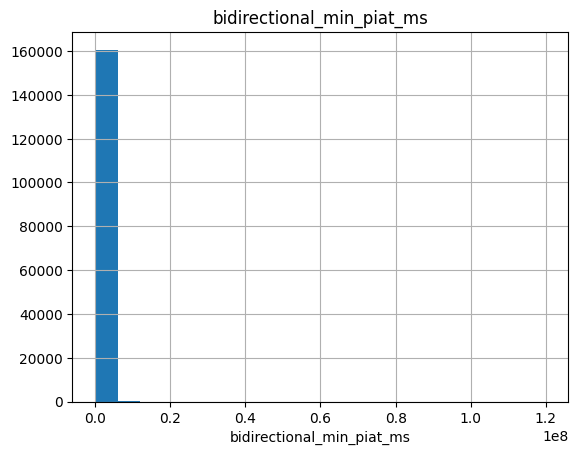

count   160983.000
mean        23.068
std        107.221
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%         33.000
80%         42.000
90%         51.000
95%         60.000
99%        120.000
max       4470.000
Name: bidirectional_min_ps, dtype: float64


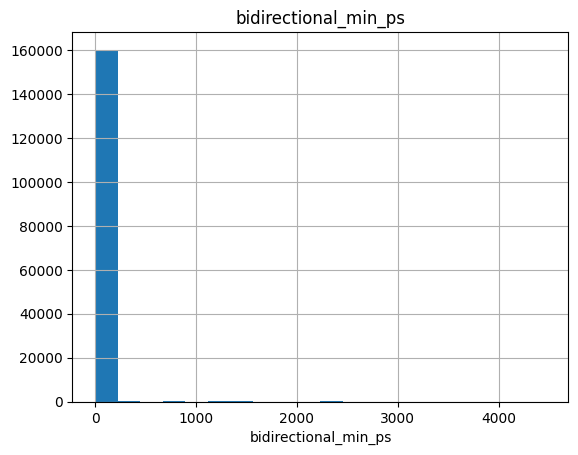

count    160983.000
mean         95.623
std        7936.783
min           0.000
5%            0.000
10%           2.000
20%           2.000
30%           2.000
40%           4.000
50%           9.000
60%          10.000
70%          12.000
80%          20.000
90%          24.000
95%          48.000
99%         289.180
max     2117154.000
Name: bidirectional_packets, dtype: float64


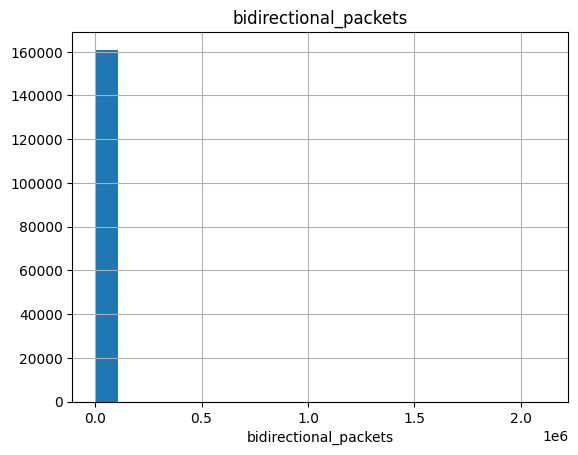

count     160983.000
mean     1202573.018
std      5270708.546
min            0.000
5%             0.000
10%            0.000
20%            0.000
30%            0.000
40%           77.000
50%          150.000
60%          325.000
70%          719.000
80%         9873.200
90%       332897.000
95%      7105957.800
99%     31826595.380
max     53665351.000
Name: bidirectional_stddev_piat_ms, dtype: float64


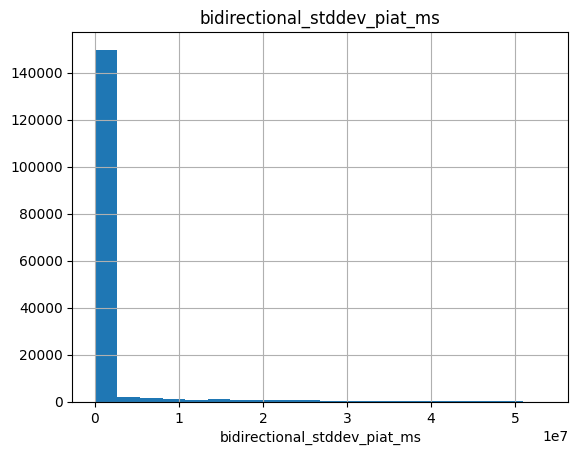

count   160983.000
mean        96.183
std        163.074
min          0.000
5%           0.000
10%          0.000
20%          8.000
30%         12.402
40%         20.000
50%         26.636
60%         33.935
70%         49.929
80%        105.000
90%        433.098
95%        509.416
99%        630.396
max       2119.500
Name: bidirectional_stddev_ps, dtype: float64


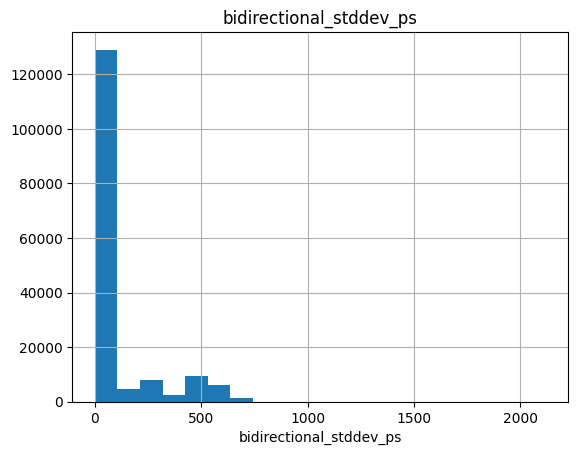

count   160983.000
mean         1.456
std          1.552
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          2.000
60%          2.000
70%          2.000
80%          2.000
90%          4.000
95%          4.000
99%          4.000
max         12.000
Name: bidirectional_syn_packets, dtype: float64


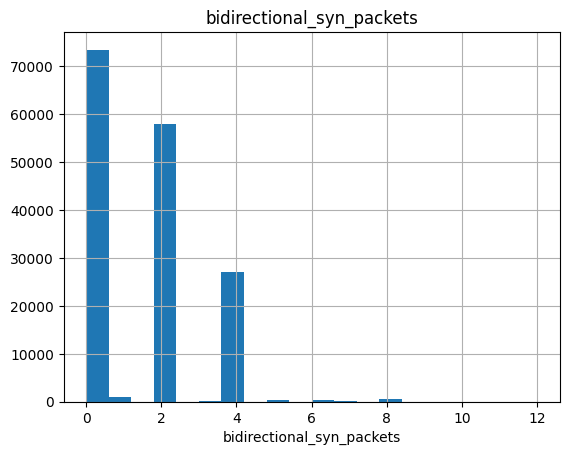

count    160983.000
mean         87.217
std        7921.717
min           0.000
5%            0.000
10%           0.000
20%           0.000
30%           0.000
40%           0.000
50%           8.000
60%           9.000
70%          10.000
80%          18.000
90%          20.000
95%          42.000
99%         242.000
max     2117153.000
Name: bidirectional_ack_packets, dtype: float64


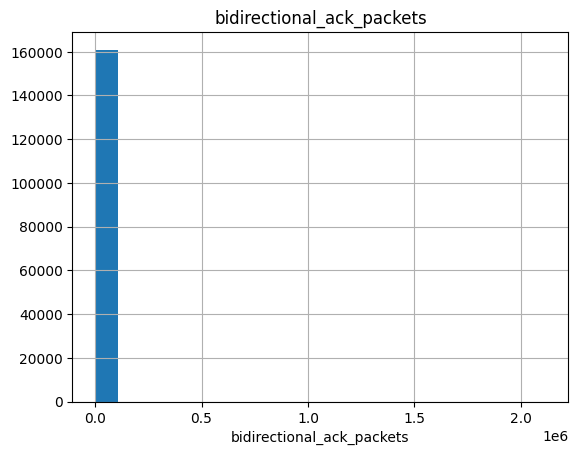

count   160983.000
mean        21.485
std       1160.212
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          2.000
60%          2.000
70%          2.000
80%          4.000
90%          8.000
95%         20.000
99%         72.000
max     196946.000
Name: bidirectional_psh_packets, dtype: float64


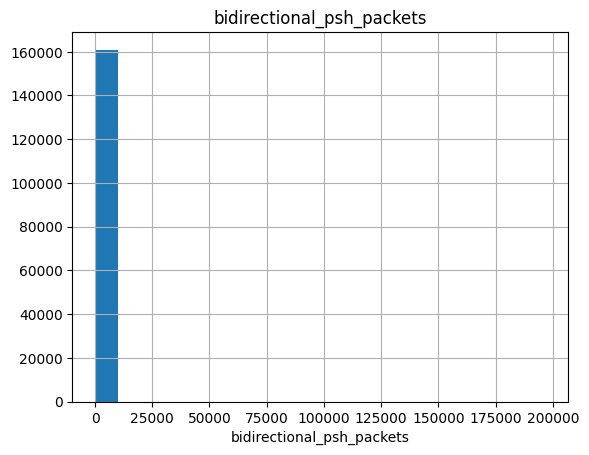

count   160983.000
mean         0.154
std          0.525
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          1.000
95%          1.000
99%          2.000
max         48.000
Name: bidirectional_rst_packets, dtype: float64


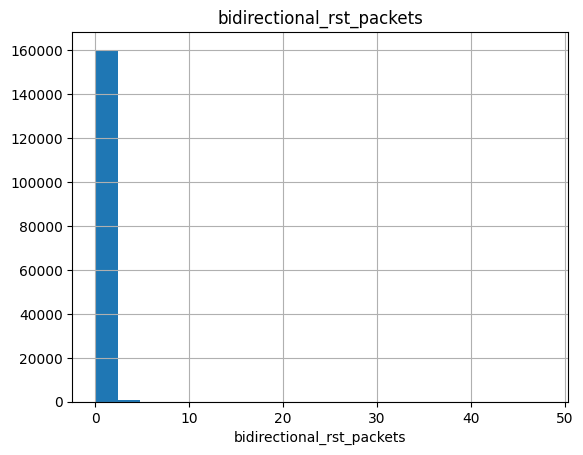

count   160983.000
mean         1.336
std          1.562
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          1.000
60%          2.000
70%          2.000
80%          2.000
90%          4.000
95%          4.000
99%          4.000
max         13.000
Name: bidirectional_fin_packets, dtype: float64


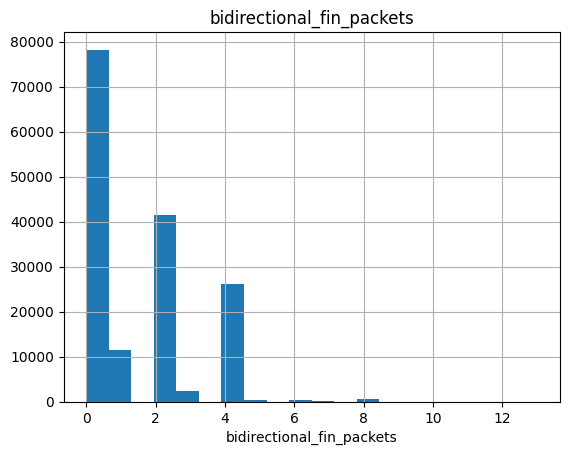

count             160983.000
mean    1588794294318091.250
std      440224563946485.000
min                    0.000
5%                     0.000
10%     1710770853071054.500
20%     1710770969859583.750
30%     1710771088299525.250
40%     1710771198725320.500
50%     1710771320473004.000
60%     1710771435806741.500
70%     1710771549056530.000
80%     1710771659921030.000
90%     1710771776660463.000
95%     1710771836792675.750
99%     1710771889921810.000
max     1710771899997409.000
Name: src2dst_first_seen_ms, dtype: float64


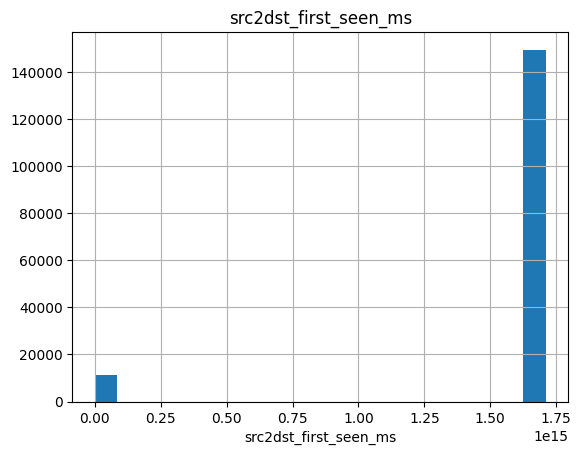

count             160983.000
mean    1588794303563008.000
std      440224566508077.000
min                    0.000
5%                     0.000
10%     1710770856325490.500
20%     1710770976618117.500
30%     1710771096550314.250
40%     1710771210386115.000
50%     1710771331221228.000
60%     1710771446833807.250
70%     1710771559314861.500
80%     1710771668752379.250
90%     1710771786924697.250
95%     1710771847598820.500
99%     1710771898328816.500
max     1710772196265394.000
Name: src2dst_last_seen_ms, dtype: float64


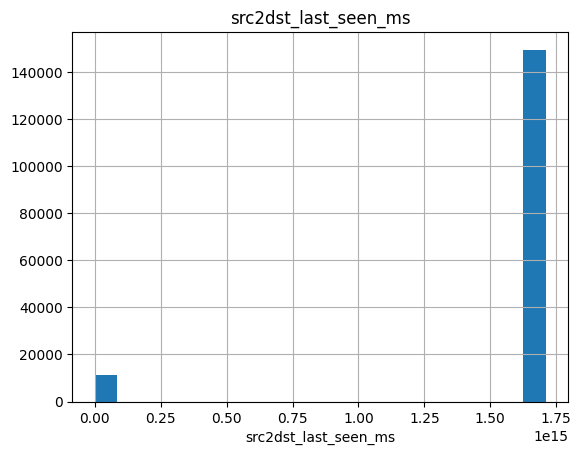

count      160983.000
mean      9244916.921
std      40877379.288
min             0.000
5%              0.000
10%             0.000
20%             0.000
30%             0.000
40%           436.000
50%          1713.000
60%          2270.000
70%          4340.000
80%         60975.400
90%       1947323.000
95%      61720391.700
99%     278457596.480
max     299999999.000
Name: src2dst_duration_ms, dtype: float64


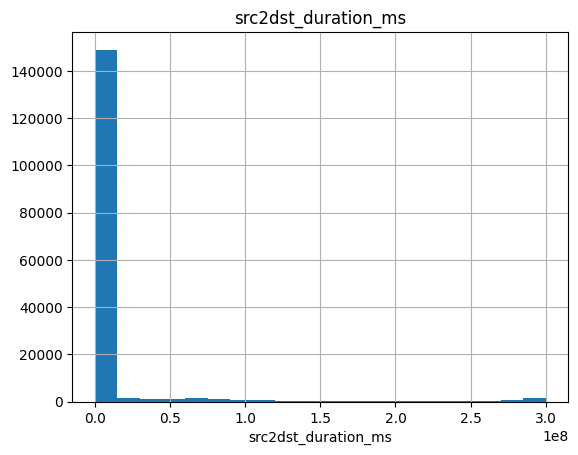

count    160983.000
mean         34.445
std        4731.440
min           0.000
5%            0.000
10%           1.000
20%           1.000
30%           1.000
40%           2.000
50%           5.000
60%           5.000
70%           7.000
80%          10.000
90%          12.000
95%          23.000
99%         120.000
max     1862505.000
Name: src2dst_packets, dtype: float64


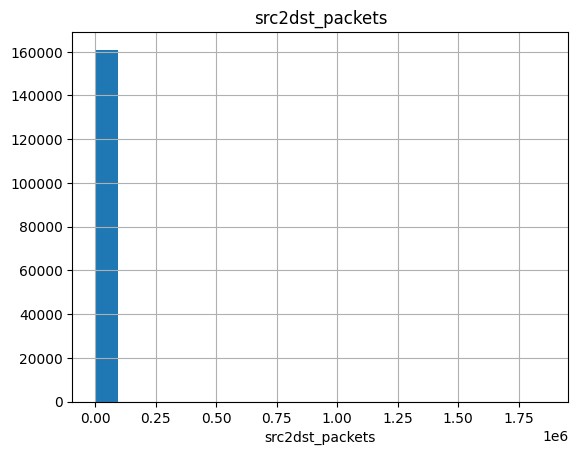

count       160983.000
mean         23002.527
std        6694990.936
min              0.000
5%               0.000
10%             17.000
20%             34.000
30%             41.000
40%             48.000
50%             62.000
60%             82.000
70%            108.000
80%            159.000
90%           1735.000
95%           3123.000
99%          26198.000
max     2680427092.000
Name: src2dst_bytes, dtype: float64


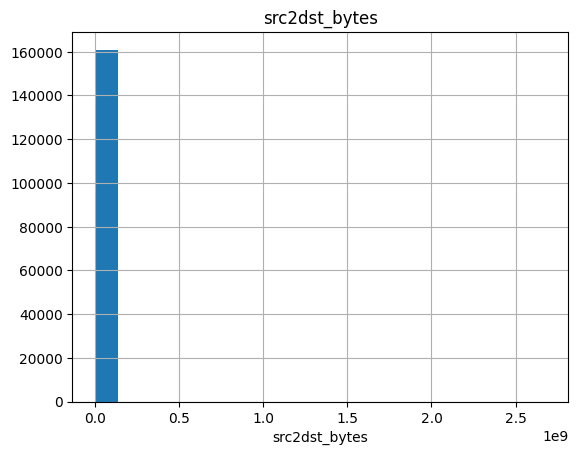

count      160983.000
mean      4175967.557
std      16811794.066
min             0.000
5%              0.000
10%             0.000
20%             0.000
30%             0.000
40%           347.000
50%           719.000
60%          1195.000
70%          3026.000
80%         40133.000
90%       1495821.600
95%      30014135.900
99%      99053373.180
max     160951799.000
Name: src2dst_max_piat_ms, dtype: float64


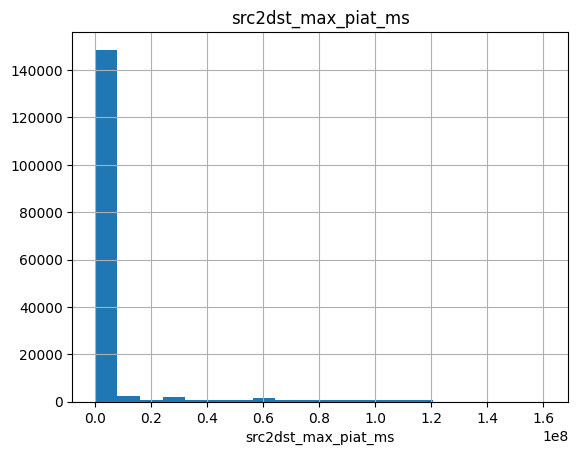

count   160983.000
mean       174.345
std        451.683
min          0.000
5%           0.000
10%         17.000
20%         33.000
30%         38.000
40%         42.000
50%         48.000
60%         55.000
70%         69.000
80%        114.000
90%        593.000
95%       1356.000
99%       1460.000
max      64512.000
Name: src2dst_max_ps, dtype: float64


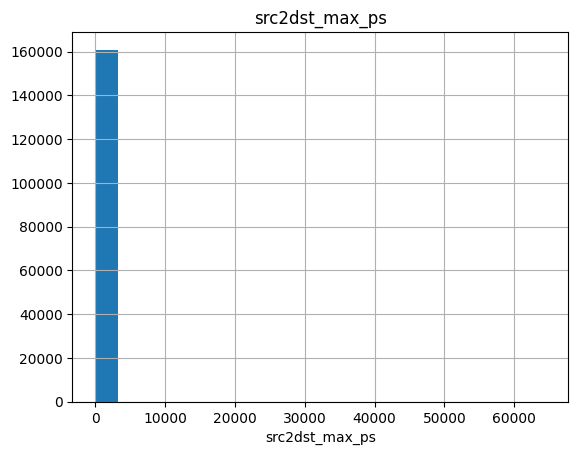

count                 160983.000
mean       59460942862300784.000
std      3868256685265431040.000
min     -9223108018834847744.000
5%      -7454922018847237120.000
10%     -5672395845553047552.000
20%     -2061283643708155136.000
30%                        0.000
40%                        0.000
50%                        0.000
60%                        0.000
70%            6486654438688.658
80%      2423373369147257856.000
90%      5753827364412216320.000
95%      7488374344945680384.000
99%      8867303177982273536.000
max      9223357004422084608.000
Name: src2dst_mean_piat_ms, dtype: float64


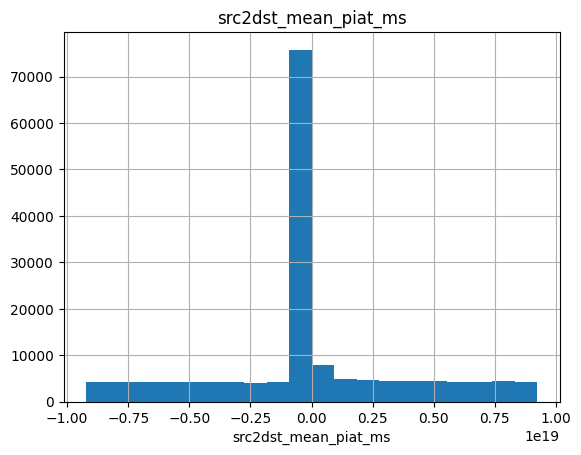

count   160983.000
mean        63.192
std        154.825
min          0.000
5%           0.000
10%          3.286
20%          7.200
30%          9.600
40%         14.000
50%         30.000
60%         39.000
70%         47.000
80%         59.000
90%        120.115
95%        298.333
99%        730.600
max       4470.000
Name: src2dst_mean_ps, dtype: float64


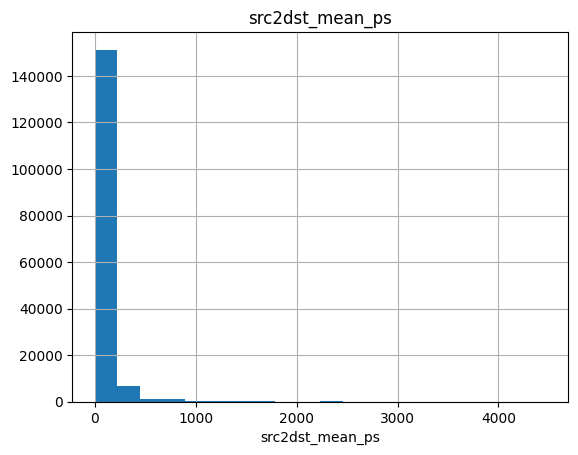

count      160983.000
mean      1190878.632
std       8787024.868
min            -5.000
5%              0.000
10%             0.000
20%             0.000
30%             0.000
40%             4.000
50%             9.000
60%            15.000
70%            24.000
80%            42.000
90%           192.000
95%         12050.600
99%      50522884.440
max     120000311.000
Name: src2dst_min_piat_ms, dtype: float64


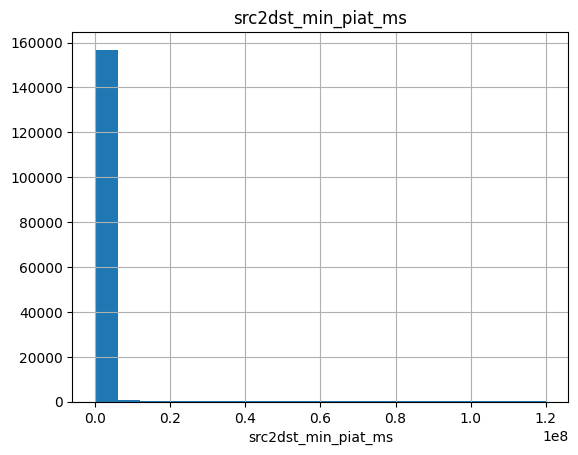

count   160983.000
mean        23.727
std        107.962
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%         33.000
80%         42.000
90%         52.000
95%         61.000
99%        195.000
max       4470.000
Name: src2dst_min_ps, dtype: float64


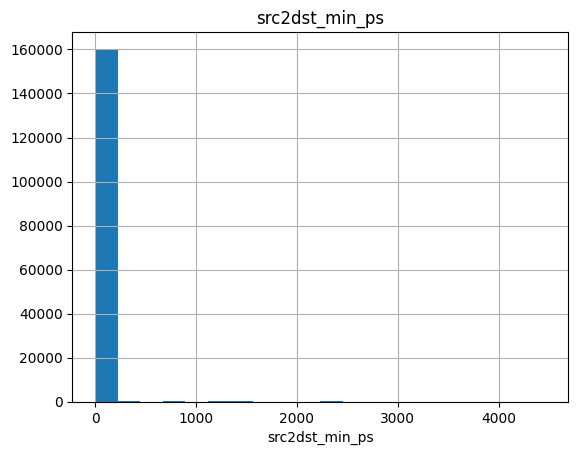

count   160983.000
mean        52.988
std        129.425
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%         11.600
60%         16.400
70%         22.000
80%         40.270
90%        139.910
95%        398.023
99%        648.059
max       1333.169
Name: src2dst_stddev_ps, dtype: float64


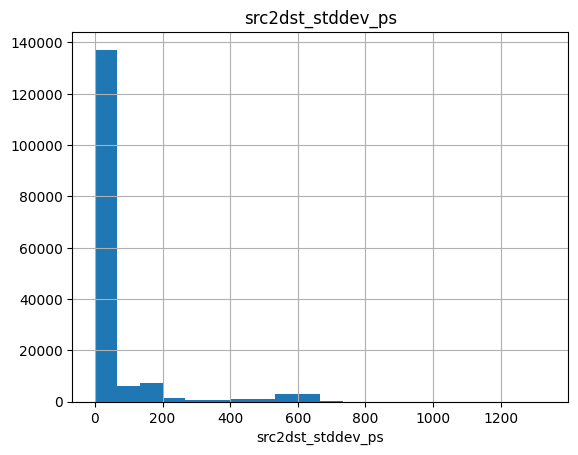

count    160983.000
mean         31.048
std        4727.423
min           0.000
5%            0.000
10%           0.000
20%           0.000
30%           0.000
40%           0.000
50%           4.000
60%           4.000
70%           6.000
80%           8.000
90%          10.000
95%          19.000
99%          94.000
max     1862504.000
Name: src2dst_ack_packets, dtype: float64


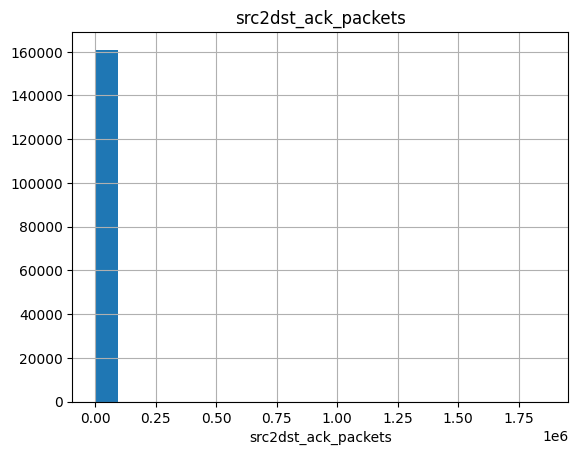

count   160983.000
mean         9.356
std        518.015
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          1.000
60%          1.000
70%          1.000
80%          2.000
90%          4.000
95%         10.000
99%         30.000
max      95565.000
Name: src2dst_psh_packets, dtype: float64


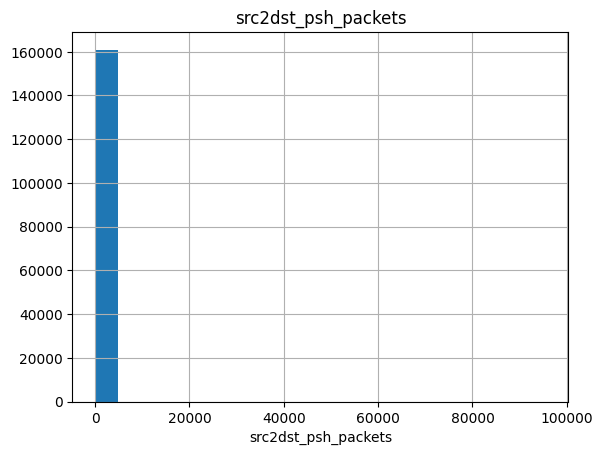

count   160983.000
mean         0.055
std          0.346
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          0.000
99%          1.000
max         48.000
Name: src2dst_rst_packets, dtype: float64


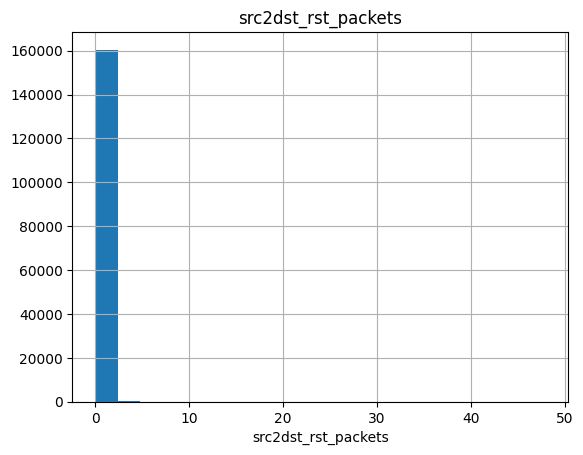

count             160983.000
mean    1575340472878068.250
std      461899426265305.250
min                    0.000
5%                     0.000
10%     1710770844033785.000
20%     1710770959543124.750
30%     1710771080637333.000
40%     1710771193386361.750
50%     1710771315497794.000
60%     1710771431886843.500
70%     1710771545776896.250
80%     1710771659554163.500
90%     1710771776098911.500
95%     1710771836595909.500
99%     1710771889947812.250
max     1710771953688015.000
Name: dst2src_first_seen_ms, dtype: float64


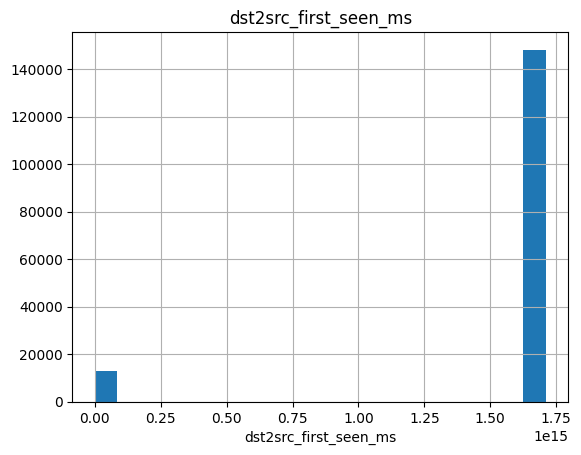

count             160983.000
mean    1575340481715406.250
std      461899428856468.312
min                    0.000
5%                     0.000
10%     1710770846443961.000
20%     1710770967206711.250
30%     1710771090521897.000
40%     1710771202827380.000
50%     1710771325146944.000
60%     1710771442241889.000
70%     1710771555705937.500
80%     1710771666728662.500
90%     1710771785894017.750
95%     1710771846845272.250
99%     1710771897877791.500
max     1710772196265280.000
Name: dst2src_last_seen_ms, dtype: float64


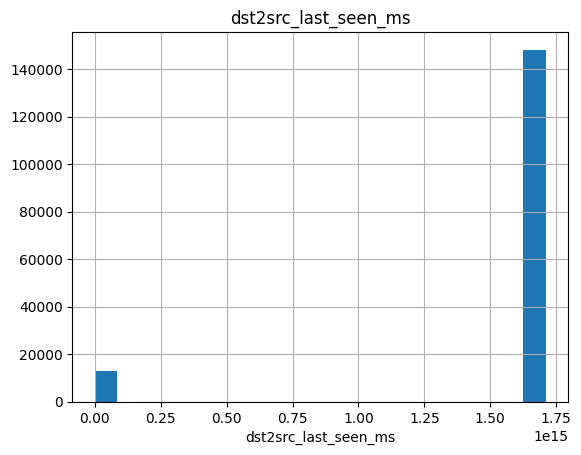

count      160983.000
mean      8837337.703
std      40005453.033
min             0.000
5%              0.000
10%             0.000
20%             0.000
30%             0.000
40%           245.800
50%          1516.000
60%          2031.000
70%          3822.400
80%         44540.000
90%       1012226.800
95%      60031144.500
99%     272372649.780
max     299999988.000
Name: dst2src_duration_ms, dtype: float64


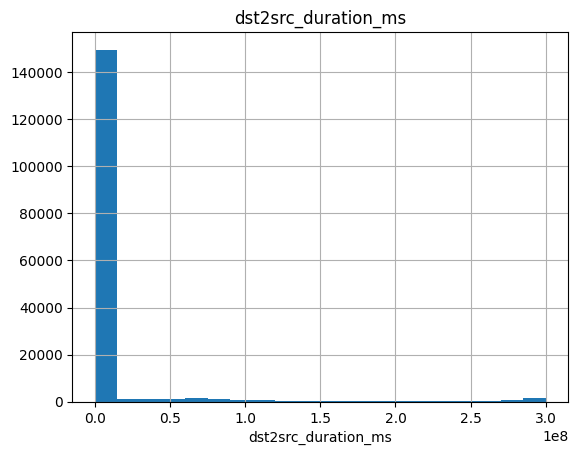

count    160983.000
mean         61.178
std        5298.816
min           0.000
5%            0.000
10%           1.000
20%           1.000
30%           1.000
40%           2.000
50%           4.000
60%           5.000
70%           6.000
80%          10.000
90%          11.000
95%          22.000
99%         109.180
max     1319289.000
Name: dst2src_packets, dtype: float64


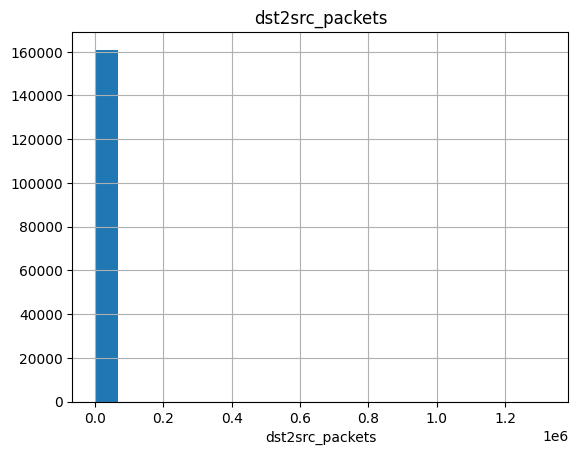

count       160983.000
mean         63072.176
std        7007991.204
min              0.000
5%               0.000
10%              0.000
20%             21.000
30%             28.000
40%             49.000
50%             94.000
60%            117.000
70%            191.000
80%            434.000
90%           2528.000
95%           4899.000
99%          45260.020
max     1778123419.000
Name: dst2src_bytes, dtype: float64


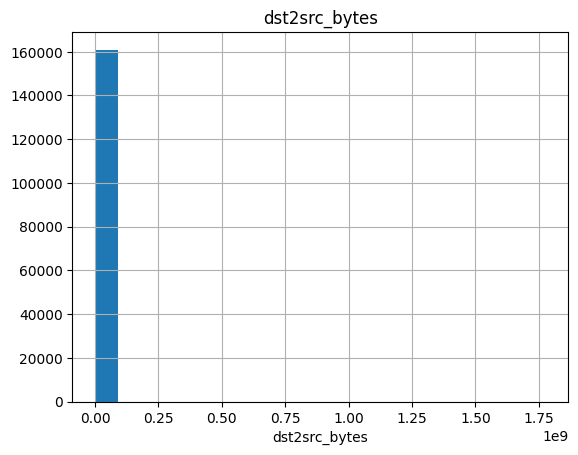

count      160983.000
mean      4033674.708
std      16650834.501
min             0.000
5%              0.000
10%             0.000
20%             0.000
30%             0.000
40%           235.000
50%           576.000
60%          1086.000
70%          2309.000
80%         28832.000
90%        540783.200
95%      30002605.100
99%      98811961.200
max     120328083.000
Name: dst2src_max_piat_ms, dtype: float64


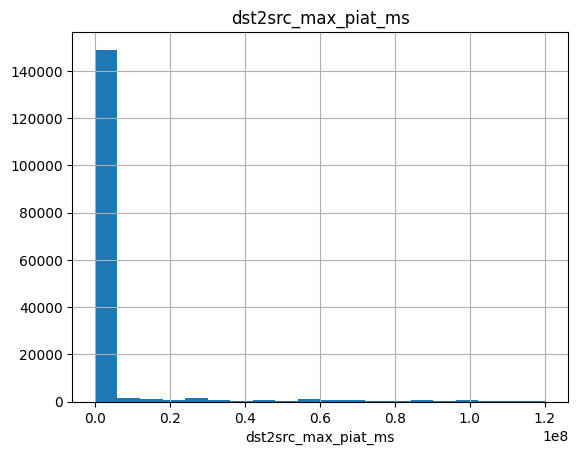

count   160983.000
mean       264.897
std        463.845
min          0.000
5%           0.000
10%          0.000
20%         21.000
30%         21.000
40%         42.000
50%         67.000
60%        111.000
70%        154.000
80%        249.000
90%       1352.000
95%       1448.000
99%       1460.000
max       4966.000
Name: dst2src_max_ps, dtype: float64


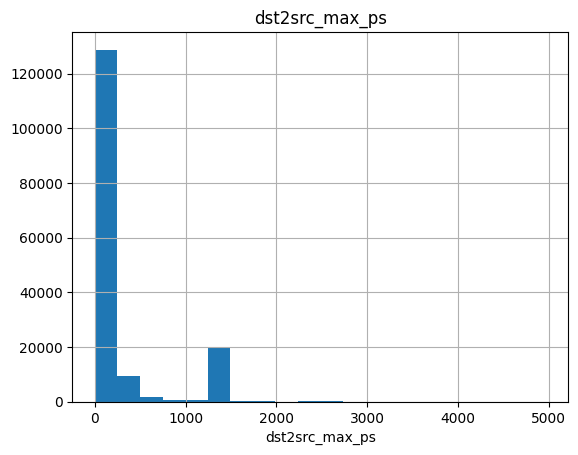

count      160983.000
mean      1826232.809
std      10164412.883
min             0.000
5%              0.000
10%             0.000
20%             0.000
30%             0.000
40%           142.000
50%           250.000
60%           498.000
70%           838.000
80%          6629.600
90%        115901.600
95%       5106070.800
99%      62653241.520
max     120155989.000
Name: dst2src_mean_piat_ms, dtype: float64


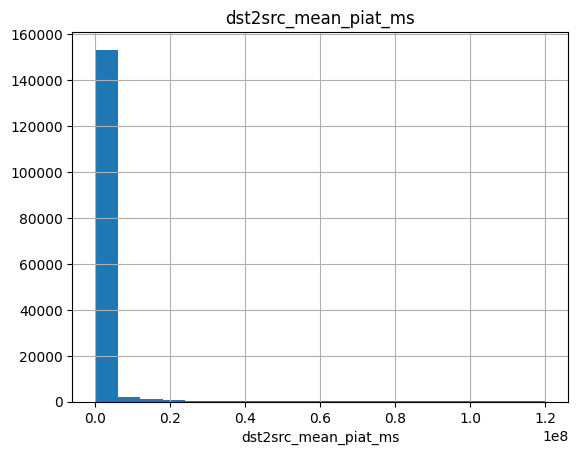

count   160983.000
mean       114.836
std        207.018
min          0.000
5%           0.000
10%          0.000
20%          4.200
30%          5.250
40%         10.200
50%         42.750
60%         82.000
70%        113.000
80%        170.000
90%        324.000
95%        449.000
99%       1061.830
max       4966.000
Name: dst2src_mean_ps, dtype: float64


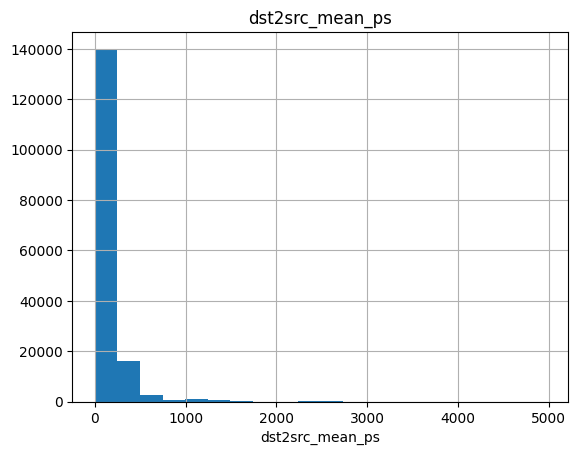

count      160983.000
mean      1184292.688
std       8754703.233
min             0.000
5%              0.000
10%             0.000
20%             0.000
30%             0.000
40%             3.000
50%             6.000
60%            10.000
70%            17.000
80%            56.000
90%           223.000
95%          4753.300
99%      50347507.900
max     120155989.000
Name: dst2src_min_piat_ms, dtype: float64


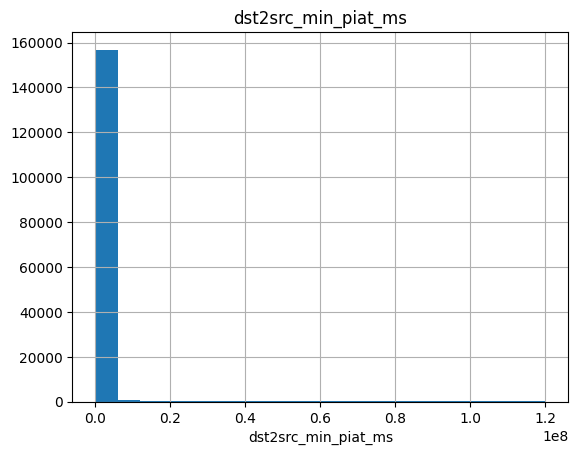

count   160983.000
mean        51.666
std        139.893
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%         53.000
80%         97.000
90%        145.000
95%        196.000
99%        449.000
max       4966.000
Name: dst2src_min_ps, dtype: float64


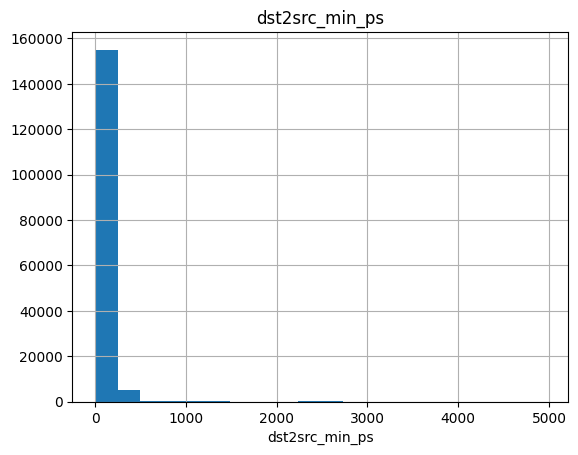

count              160983.000
mean      211689696951157.406
std      1262580690208630.250
min                     0.000
5%                      0.000
10%                     0.000
20%                     0.000
30%                     0.000
40%                     0.000
50%                207749.000
60%                528456.000
70%               2106064.000
80%             189225420.600
90%          238079887329.600
95%       198441944861996.312
99%      7174769998142243.000
max     29560521950263520.000
Name: dst2src_stddev_piat_ms, dtype: float64


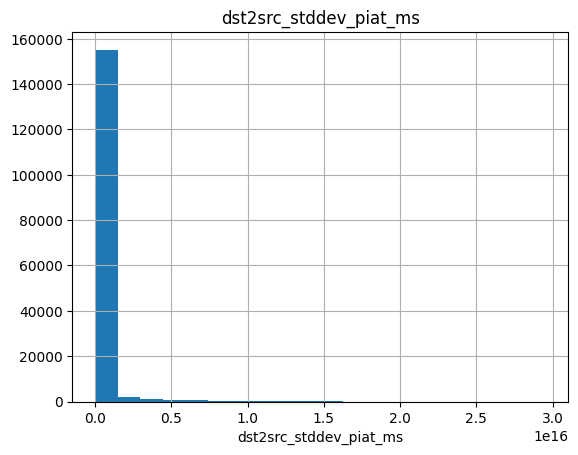

count   160983.000
mean        76.792
std        171.793
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          6.210
60%          9.093
70%         20.000
80%         61.735
90%        304.812
95%        571.544
99%        647.300
max       1691.001
Name: dst2src_stddev_ps, dtype: float64


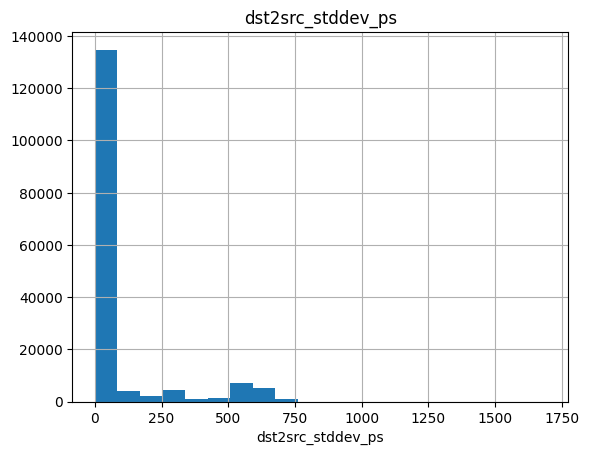

count    160983.000
mean         56.169
std        5282.148
min           0.000
5%            0.000
10%           0.000
20%           0.000
30%           0.000
40%           0.000
50%           4.000
60%           5.000
70%           6.000
80%          10.000
90%          11.000
95%          22.000
99%         103.000
max     1319289.000
Name: dst2src_ack_packets, dtype: float64


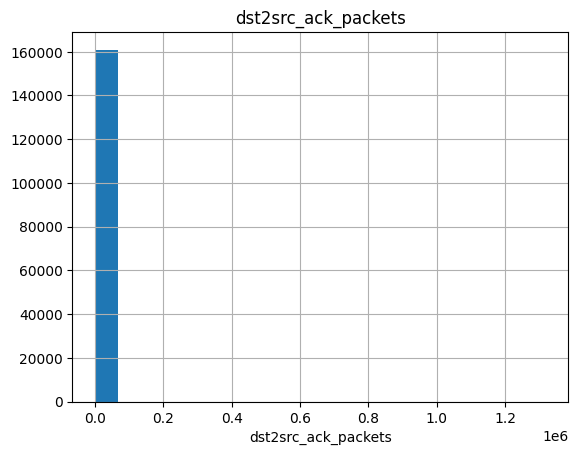

count   160983.000
mean        12.129
std        734.013
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          1.000
60%          1.000
70%          1.000
80%          2.000
90%          4.000
95%         10.000
99%         36.000
max     134092.000
Name: dst2src_psh_packets, dtype: float64


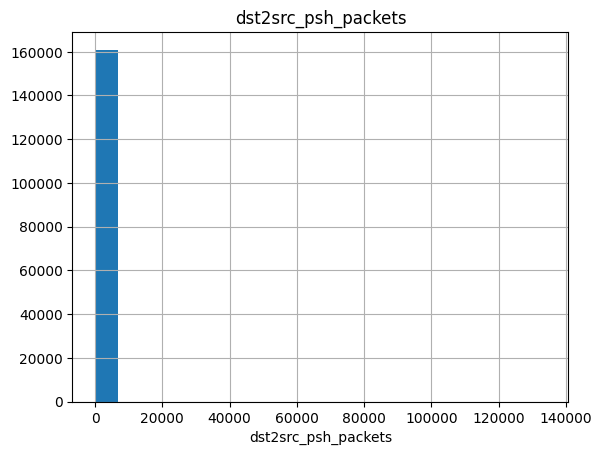

count   160983.000
mean         0.651
std          0.787
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          1.000
70%          1.000
80%          1.000
90%          2.000
95%          2.000
99%          2.000
max         10.000
Name: dst2src_fin_packets, dtype: float64


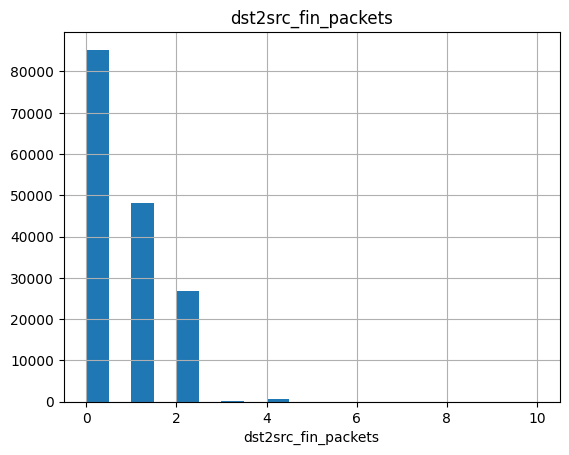

count   160983.000
mean         8.896
std         15.277
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%         14.000
80%         21.000
90%         29.000
95%         35.000
99%         72.000
max        148.000
Name: dns_query_len, dtype: float64


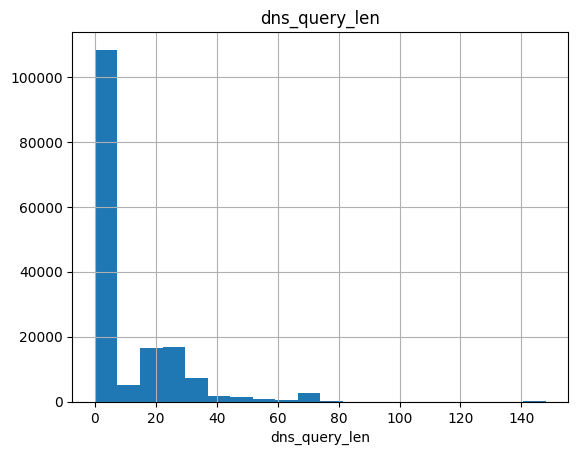

count   160983.000
mean         5.439
std         12.312
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%         25.000
95%         32.000
99%         52.000
max        110.000
Name: dns_answer_len, dtype: float64


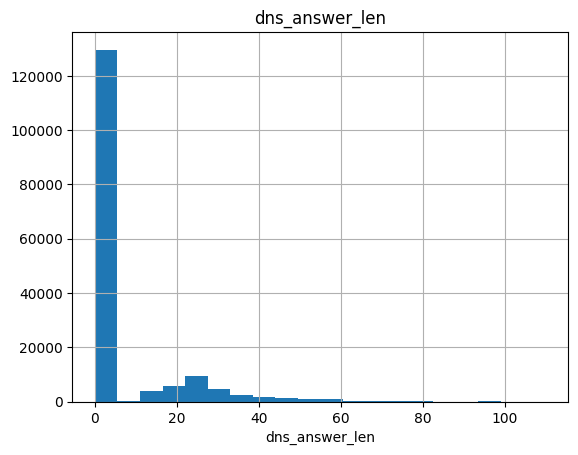

count   160983.000
mean         2.178
std         23.677
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          0.000
99%          0.000
max        503.000
Name: status_code, dtype: float64


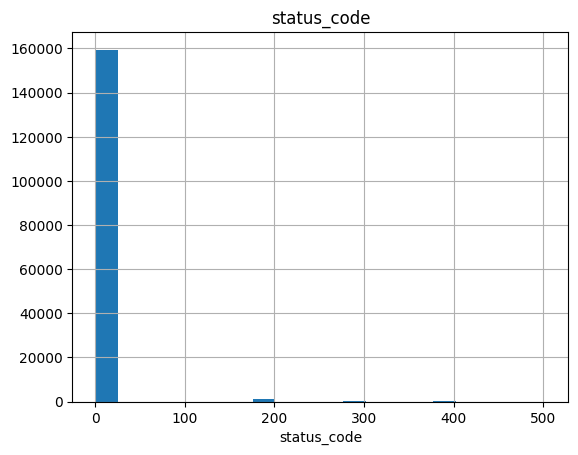

count    160983.000
mean         55.384
std        5324.679
min           0.000
5%            0.000
10%           0.000
20%           0.000
30%           0.000
40%           0.000
50%           1.000
60%           2.000
70%           2.000
80%           4.000
90%           8.000
95%          22.000
99%         136.000
max     1396836.000
Name: bidirectional_http_request_count, dtype: float64


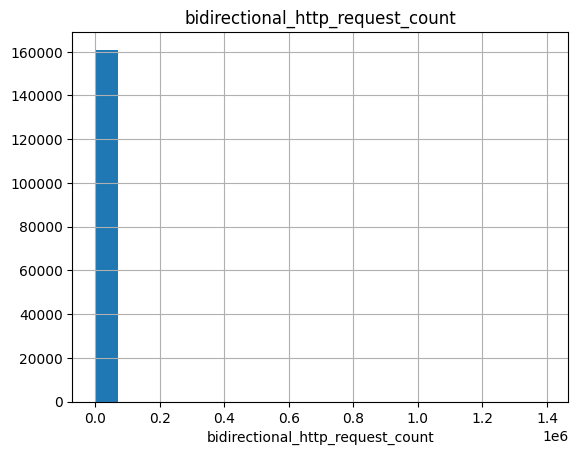

count   160983.000
mean         0.007
std          1.045
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          0.000
99%          0.000
max        240.000
Name: bidirectional_get_request_count, dtype: float64


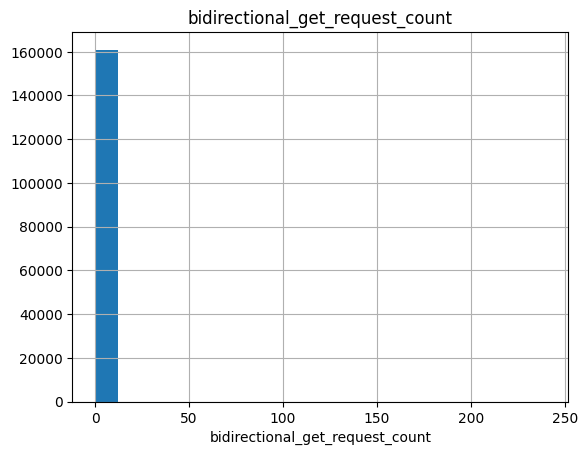

count   160983.000
mean         2.647
std        470.822
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          0.000
99%          0.000
max     108720.000
Name: bidirectional_get_request_bytes, dtype: float64


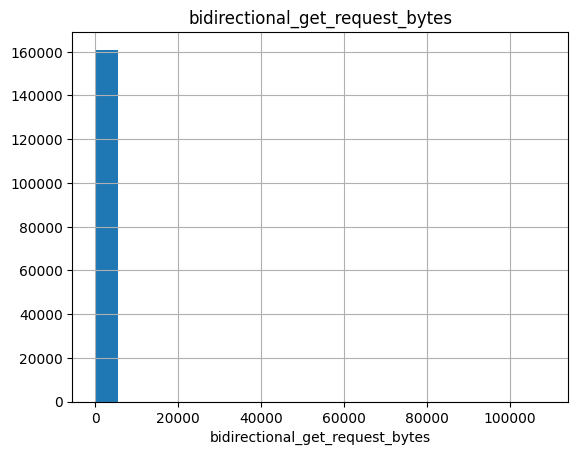

count   160983.000
mean         0.022
std          2.000
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          0.000
99%          0.000
max        383.000
Name: bidirectional_post_request_count, dtype: float64


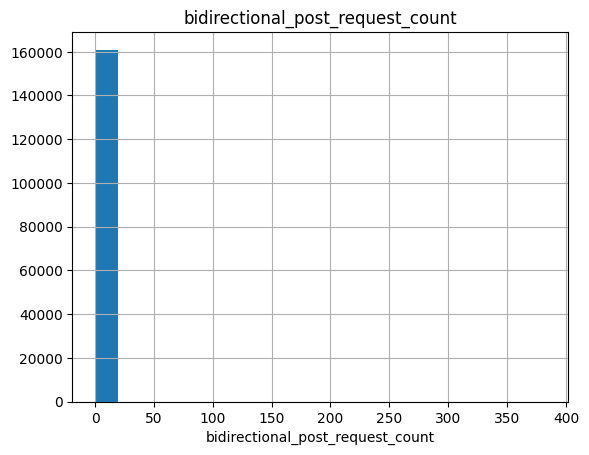

count   160983.000
mean        18.385
std       1387.500
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          0.000
99%          0.000
max     177329.000
Name: bidirectional_post_request_bytes, dtype: float64


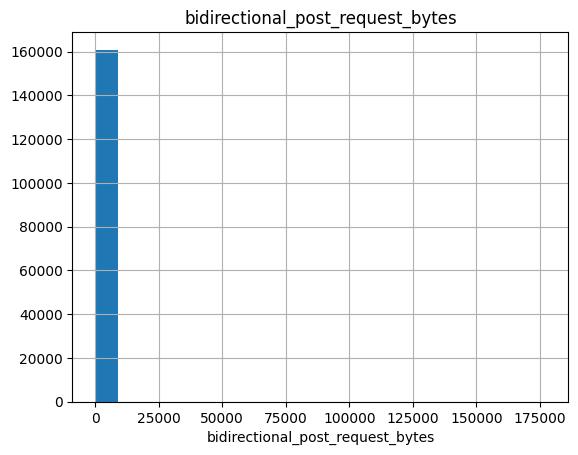

count   160983.000
mean         2.637
std        470.808
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          0.000
99%          0.000
max     108720.000
Name: src2dst_get_request_bytes, dtype: float64


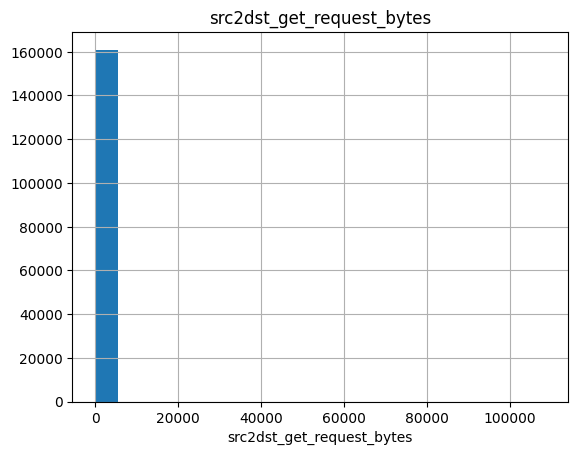

count   160983.000
mean        18.385
std       1387.500
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          0.000
99%          0.000
max     177329.000
Name: src2dst_post_request_bytes, dtype: float64


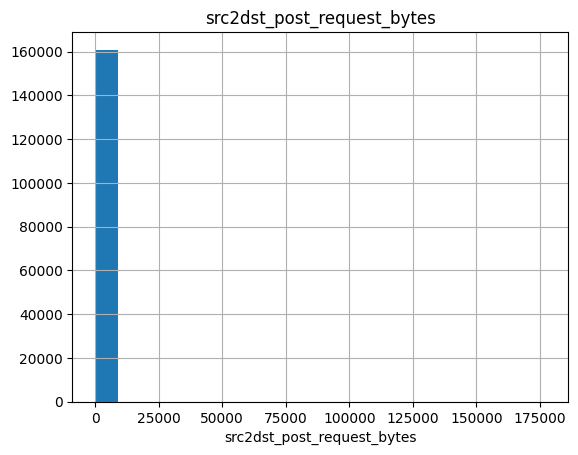

count   160983.000
mean        18.385
std       1387.500
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%          0.000
95%          0.000
99%          0.000
max     177329.000
Name: src2dst_post_request_bytes, dtype: float64


In [5]:
############################### NUMERİK DEĞİŞKENLERİN ANALİZİ

def num_summary(dataframe, numerical_col, plot=False):
    """
    Fonksiyonun amacı, bir pandas veri çerçevesindeki belirtilen sayısal sütunların özet istatistiklerini
    hesaplamak ve istenirse bu değişkenlerin dağılımını bir histogram ile görselleştirmektir.

    Parameters
    ----------
    dataframe:Üzerinde işlem yapılacak pandas veri çerçevesi.
    numerical_col:Sayısal değişkenin adı (sütun adı).
    plot: Bu parametre True olarak verilirse, değişkenin dağılımını bir histogram ile gösterir. Varsayılan değeri False'tur.

    Returns
    -------

    """
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

num_summary(df, col)

In [6]:
######################## NUMERİK DEĞİŞKENLERİN TARGETE GÖRE ANALİZİ

def target_summary_with_num(dataframe, target, numerical_col):
    """
    Fonksiyonun amacı, bir veri çerçevesindeki belirli bir hedef değişkenin farklı kategorilerine göre bir sayısal
    değişkenin ortalama değerlerini hesaplamak ve bu ortalama değerleri ekrana yazdırmaktır. Bu, özellikle
    hedef değişkenin sayısal değişken üzerindeki etkisini anlamak için kullanışlıdır.

    Parameters
    ----------
    dataframe : Üzerinde işlem yapılacak pandas veri çerçevesi.
    target : Hedef değişkenin adı (kategorik değişken).
    numerical_col : Sayısal değişkenin adı.

    Returns
    -------

    """
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "destination_address", col)

                     source_port
destination_address             
1.0.0.1                52956.625
1.1.1.1                57550.398
10.1.101.10            47549.598
10.1.39.10               744.500
10.1.40.1              43298.434
...                          ...
92.123.102.65          61181.583
93.184.221.240         59813.562
95.101.196.20          62080.214
95.101.197.110         50446.000
95.101.23.205          35747.000

[1085 rows x 1 columns]


                     destination_port
destination_address                  
1.0.0.1                       218.288
1.1.1.1                        53.693
10.1.101.10                 10255.457
10.1.39.10                   2049.000
10.1.40.1                     151.467
...                               ...
92.123.102.65                  80.000
93.184.221.240                 80.000
95.101.196.20                 443.000
95.101.197.110                443.000
95.101.23.205                 443.000

[1085 rows x 1 columns]


                     ap

In [7]:
# target_summary Bu fonksiyon üzerinden Bruteforce saldırıları ve ARP Scan, Exfiltration, Execution gibi siber saldırıları belirlemek için çok kritik bir rol oynamaktadır.
def target_summary_with_nums2(dataframe, target, numerical_col):
    """
    Fonksiyonun amacı, bir pandas veri çerçevesindeki belirli bir hedef değişkenin farklı kategorilerine göre
    bir sayısal değişkenin ortalama değerlerini hesaplamak, bu ortalama değerleri büyükten küçüğe sıralamak ve
    bu şekilde ekrana yazdırmaktır. Bu, özellikle hedef değişkenin sayısal değişken üzerindeki etkisini anlatmak için kullanılır.

    Parameters
    ----------
    dataframe : Üzerinde işlem yapılacak pandas veri çerçevesi.
    target : Hedef değişkenin adı (kategorik değişken).
    numerical_col : Sayısal değişkenin adı.

    Returns
    -------

    """
    summary_df = dataframe.groupby(target).agg({numerical_col: "mean"})
    sorted_summary_df = summary_df.sort_values(by=numerical_col, ascending=False)
    print(sorted_summary_df, end="\n\n\n")

for col in num_cols:
    target_summary_with_nums2(df,"destination_address", col)

                     source_port
destination_address             
160.44.207.213         65282.000
216.58.212.137         65030.000
199.7.83.42            64405.000
20.42.65.84            64403.000
192.168.30.126         64372.000
...                          ...
10.1.78.221                0.000
10.1.78.222                0.000
10.1.78.223                0.000
10.1.78.224                0.000
10.1.78.185                0.000

[1085 rows x 1 columns]


                     destination_port
destination_address                  
10.60.1.45                  65136.000
10.212.134.142              64931.000
10.61.0.125                 64782.000
10.61.1.96                  64119.000
10.61.0.65                  64100.000
...                               ...
10.1.78.249                     0.000
10.1.78.25                      0.000
10.1.78.250                     0.000
10.1.78.251                     0.000
10.1.78.205                     0.000

[1085 rows x 1 columns]


                     ap

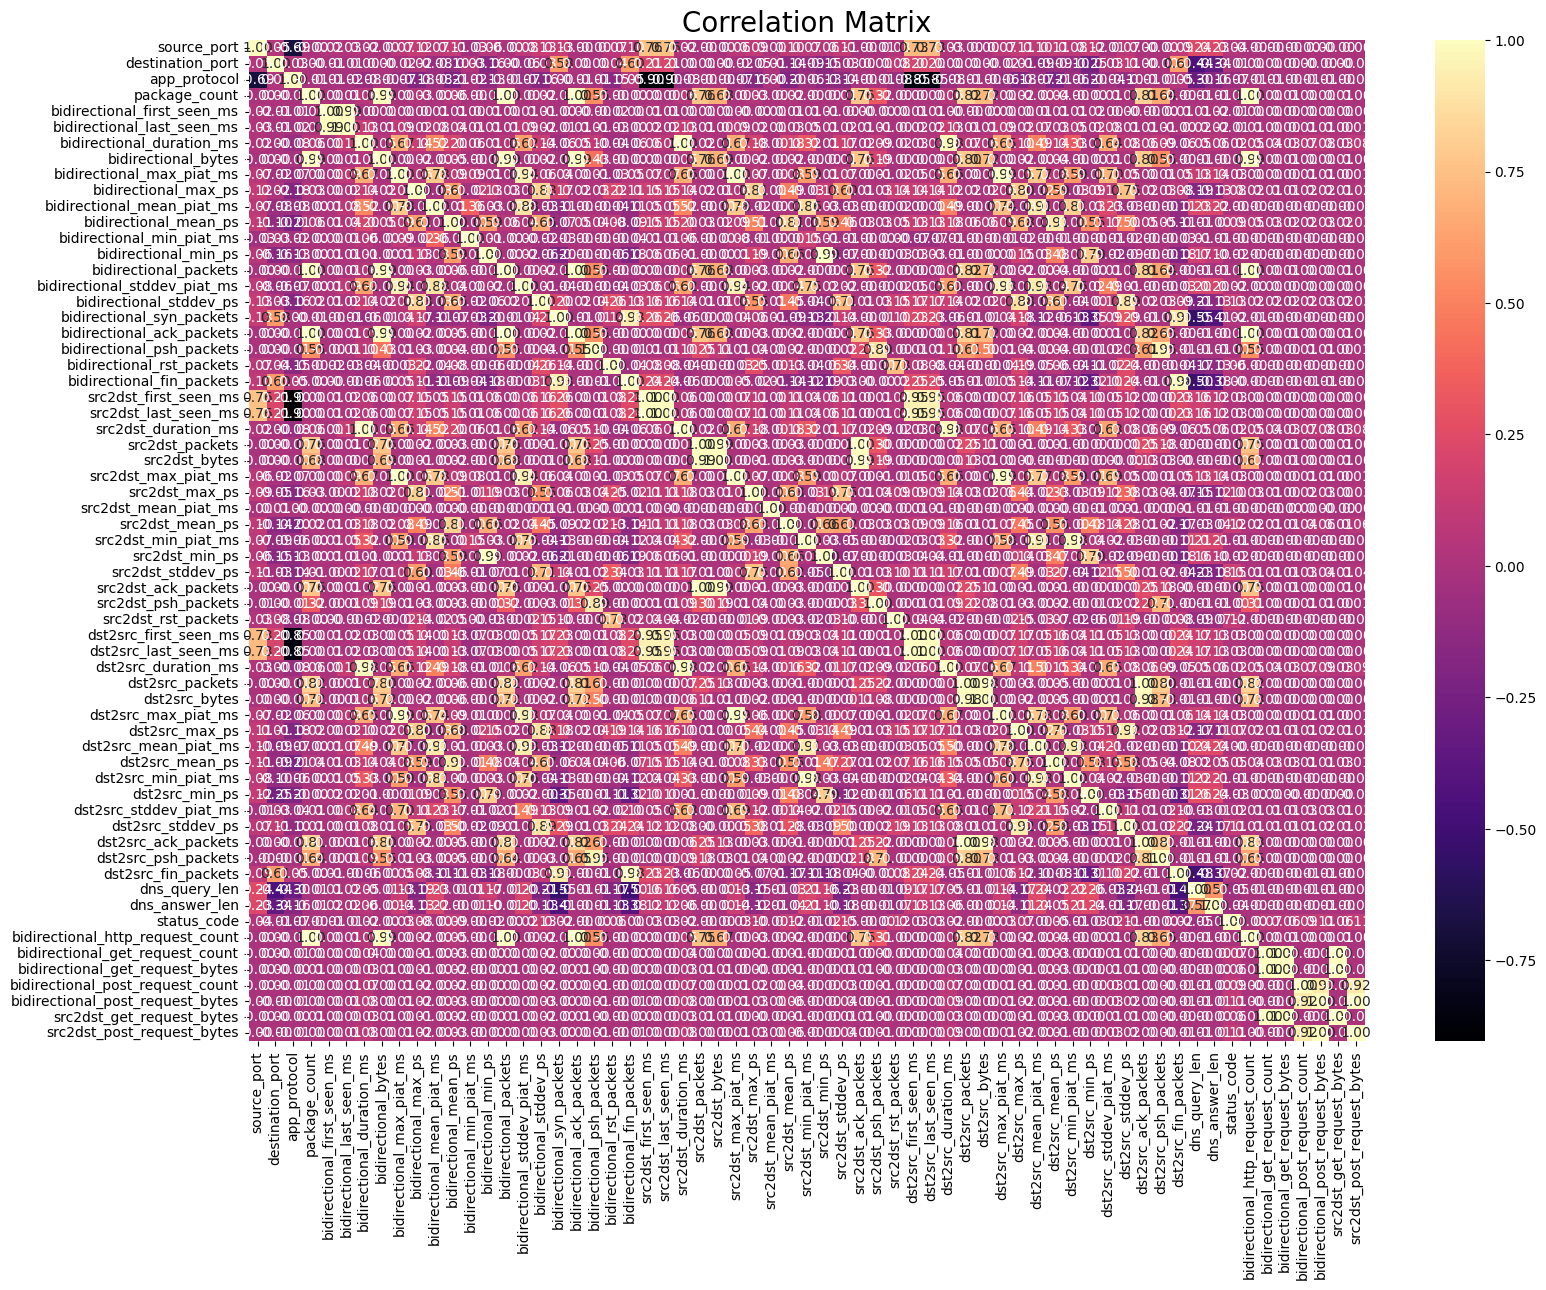

In [8]:
############################ KORELASYON


df[num_cols].corr()

# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

##################### Shape ##########################
(160983, 165)
##################### Types ##########################
sync_name                  object
source_address             object
destination_address        object
source_port                 int64
destination_port            int64
                           ...   
session_id                 object
session_id_from_time       object
protocol_name              object
source_asset_type         float64
destination_asset_type    float64
Length: 165, dtype: object
##################### Head ##########################
     sync_name source_address destination_address  source_port  destination_port  protocol  app_protocol application_name application_category_name master_application_name  tunnel_source_address  tunnel_destination_address         source_mac    destination_mac  tunnel_value  package_count  login_fail_count  login_success  expiration_id  drop_eligible  priority  vlan_identifier  \
0  master-node  192.168.2.100         

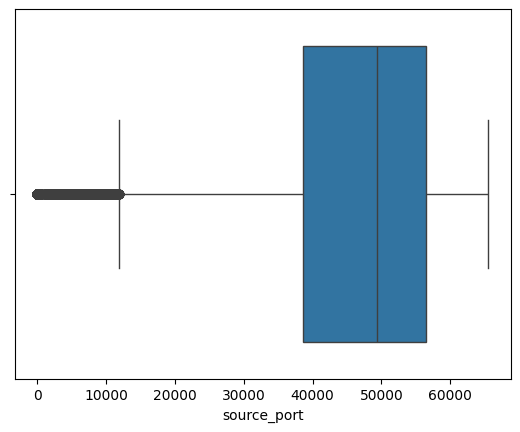

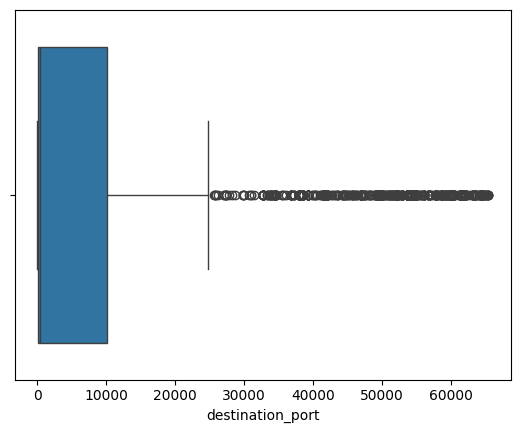

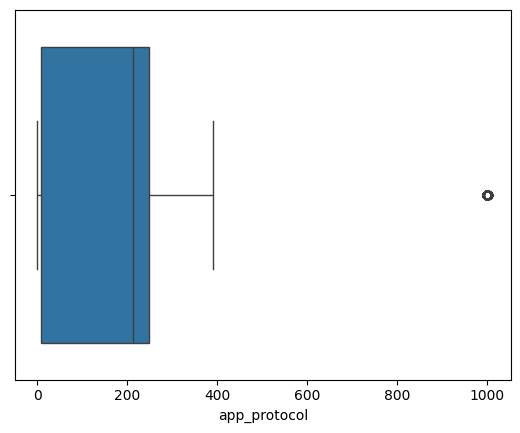

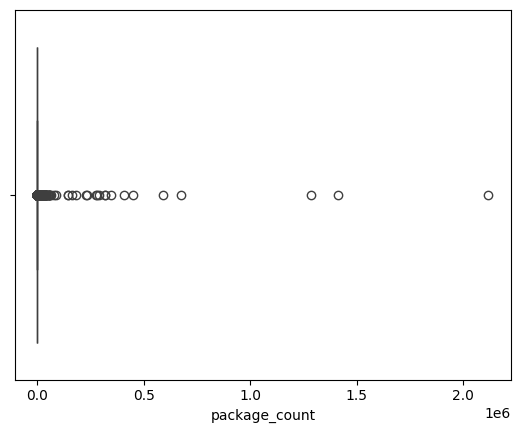

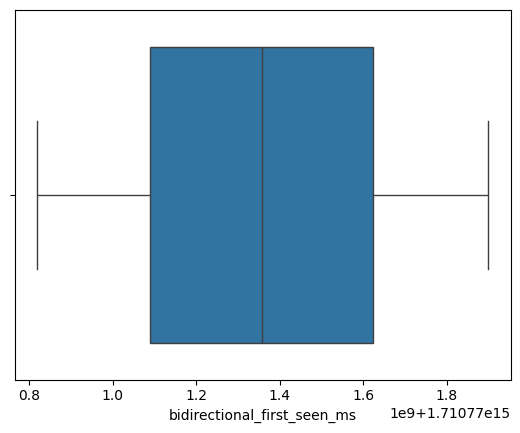

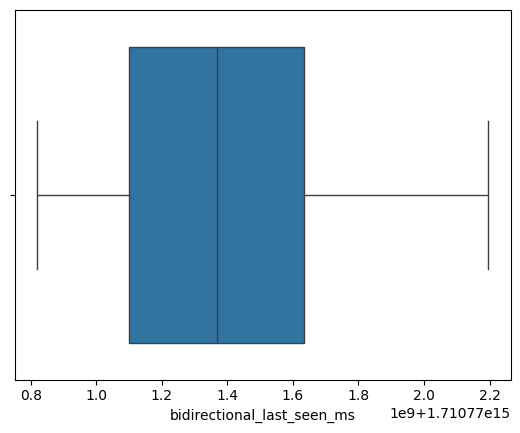

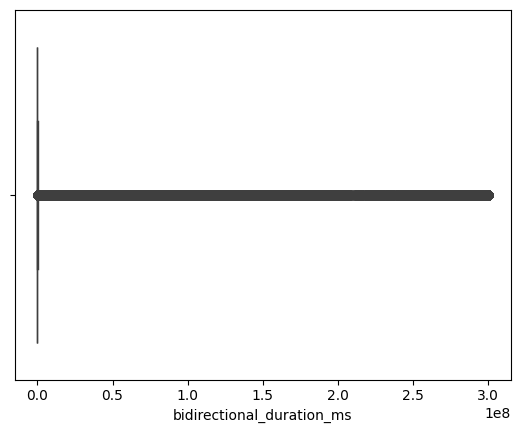

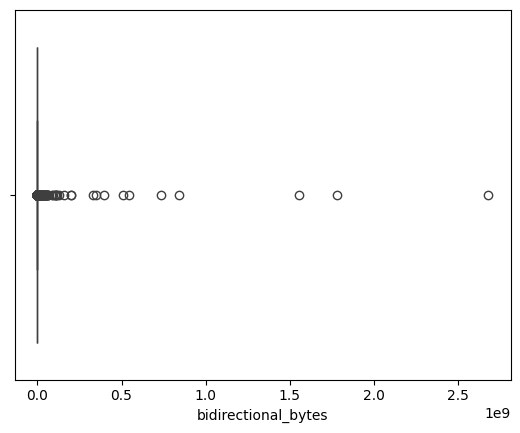

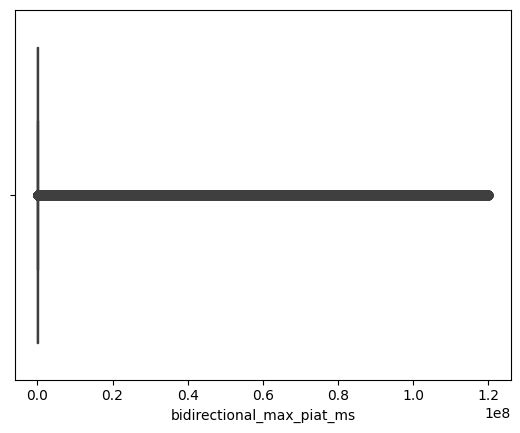

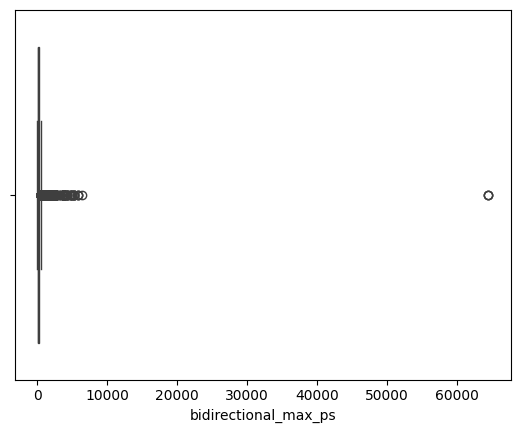

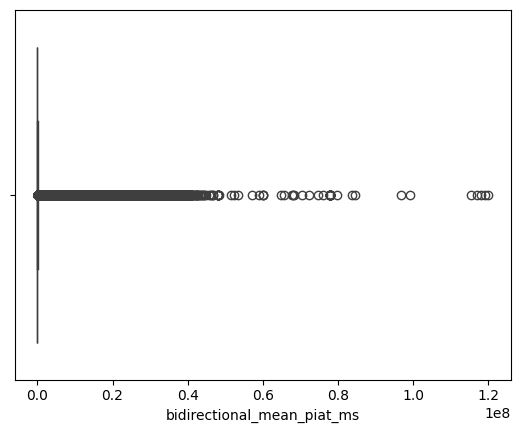

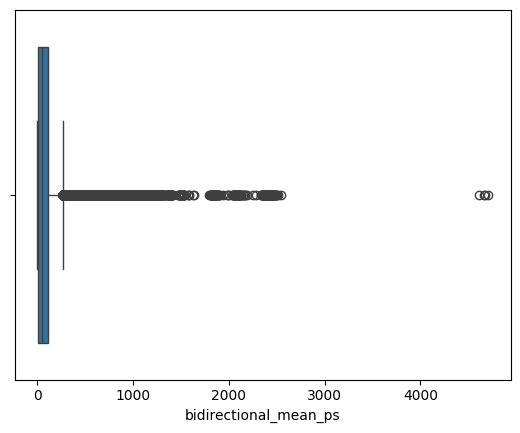

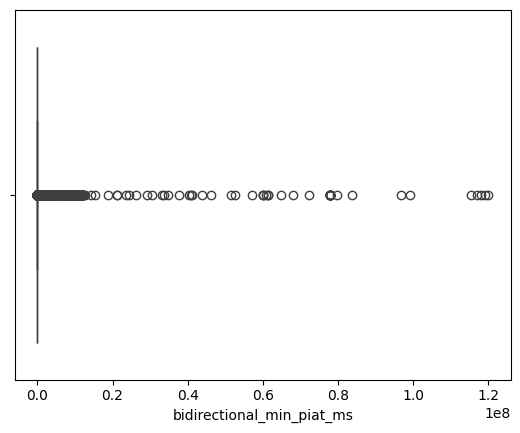

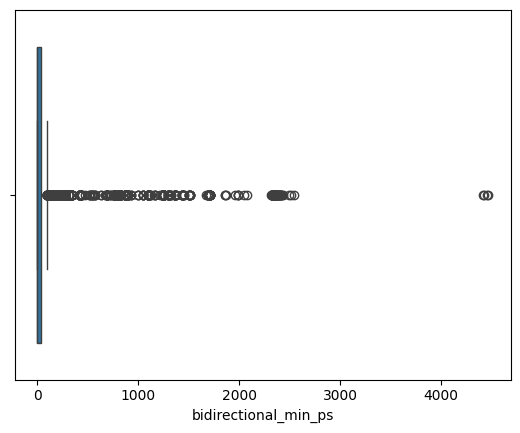

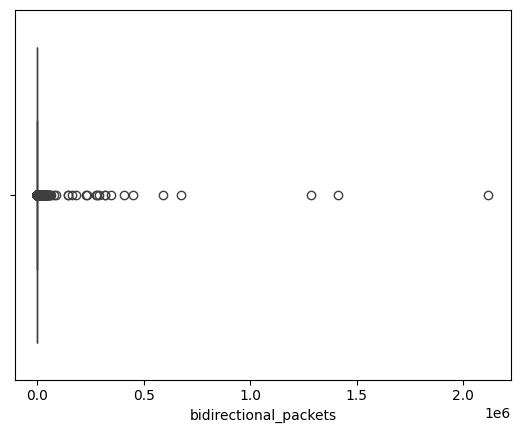

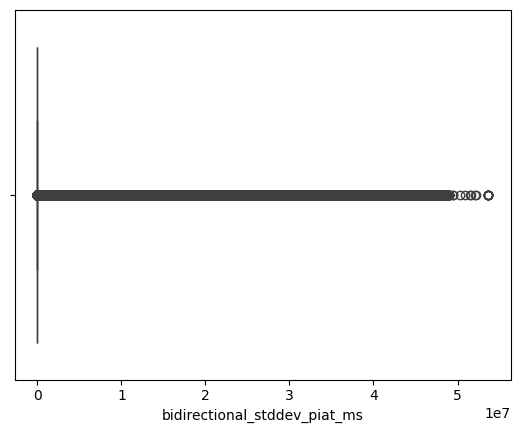

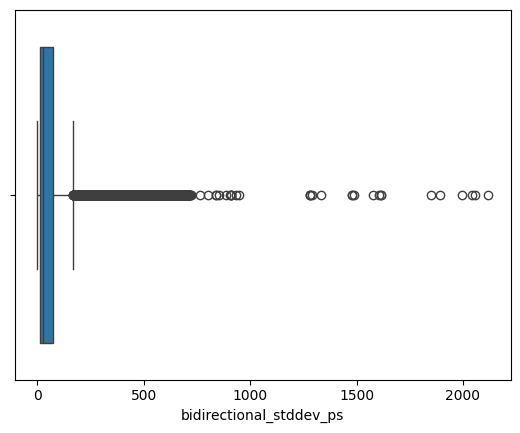

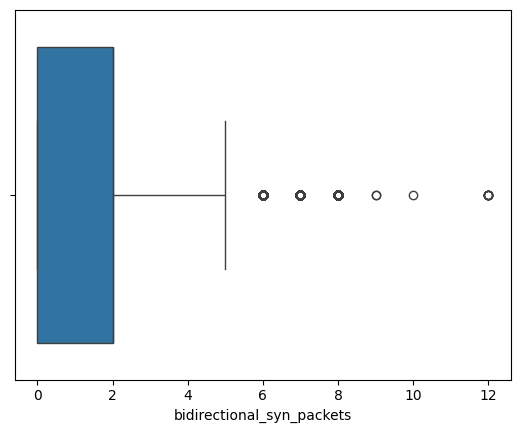

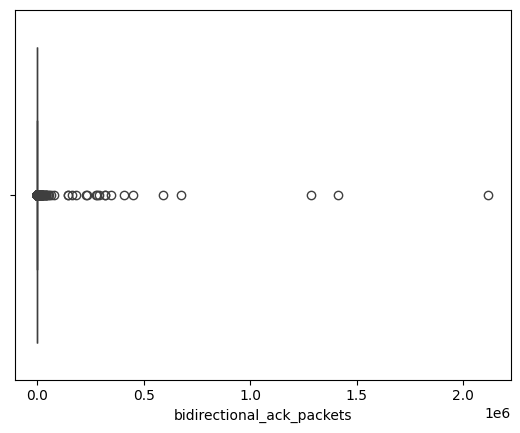

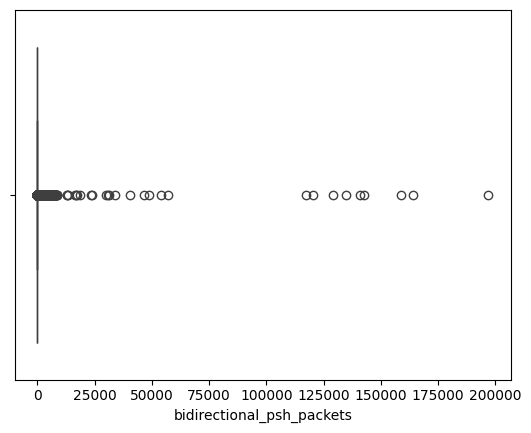

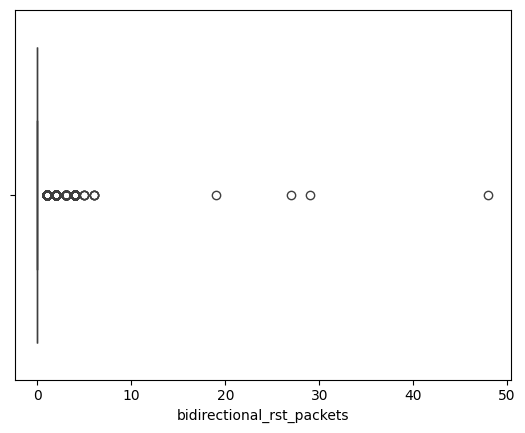

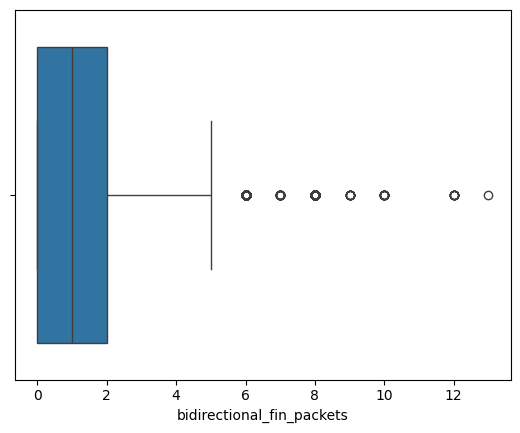

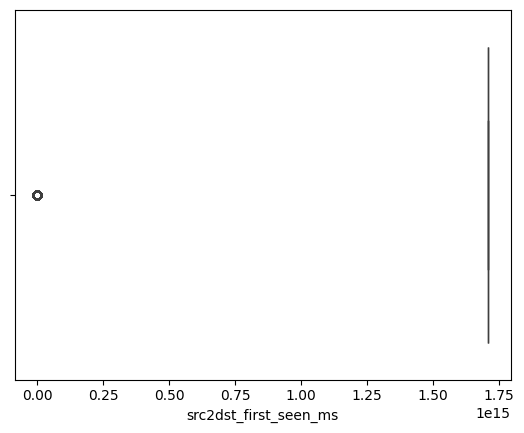

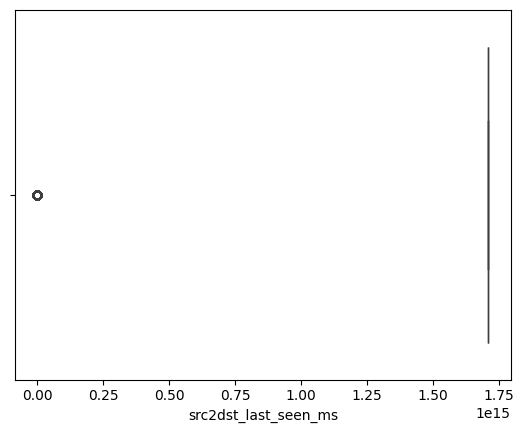

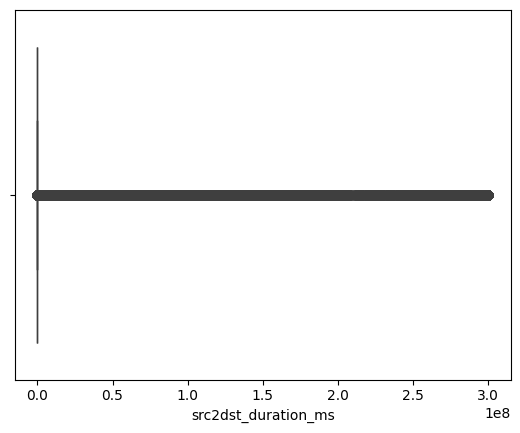

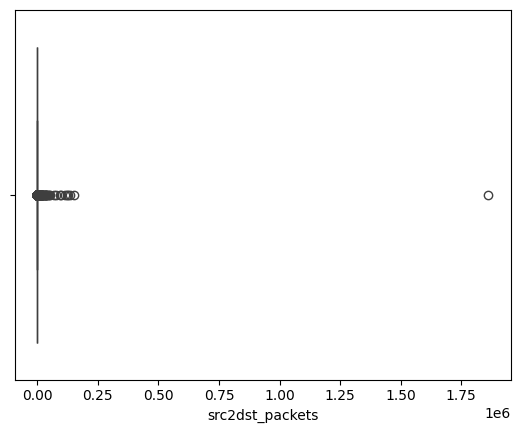

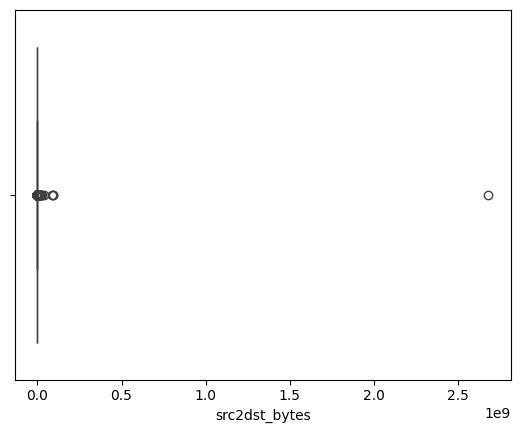

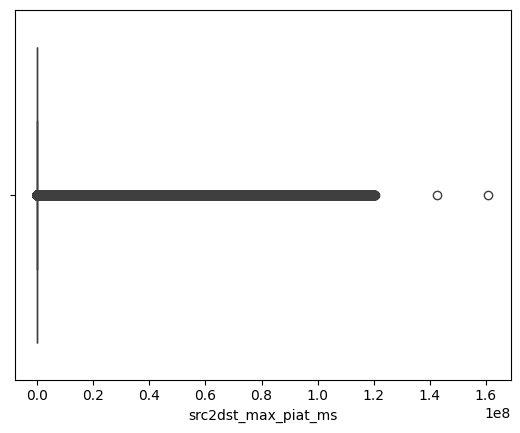

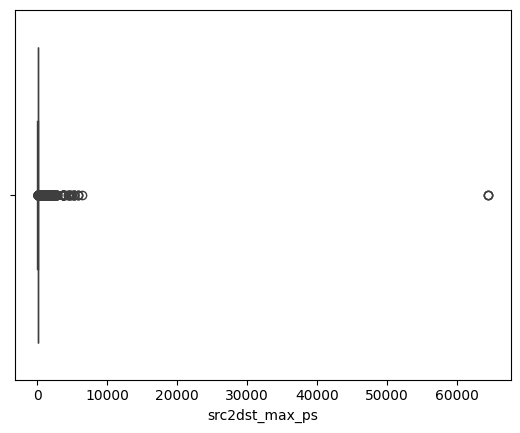

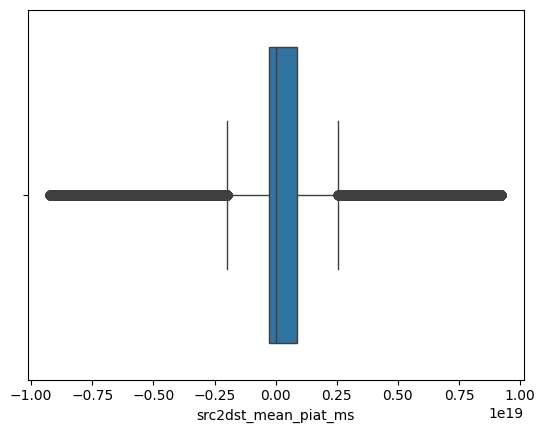

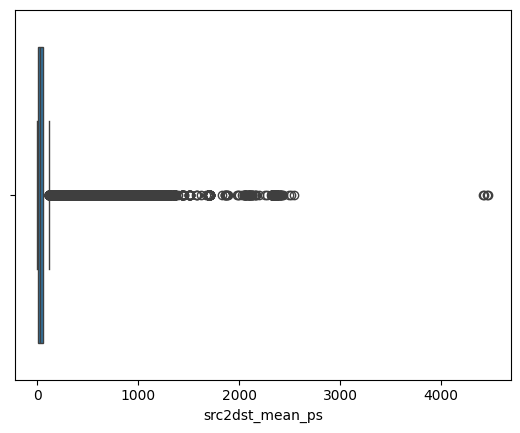

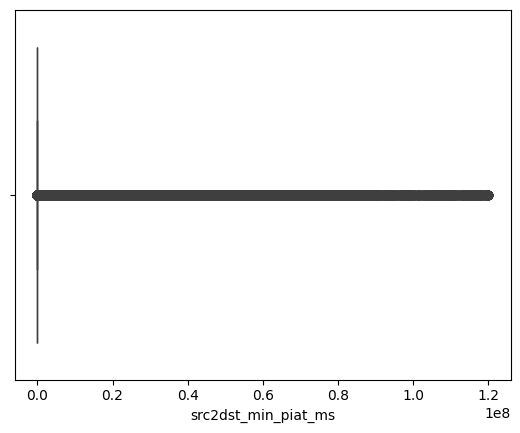

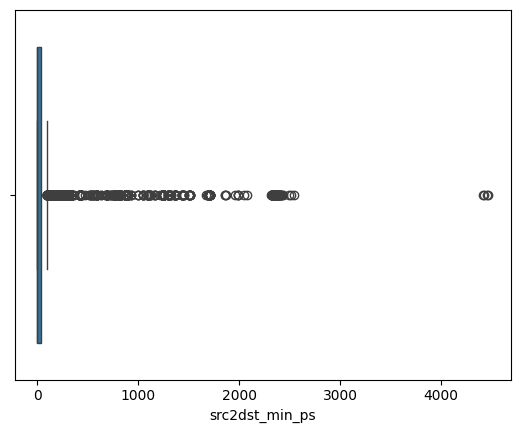

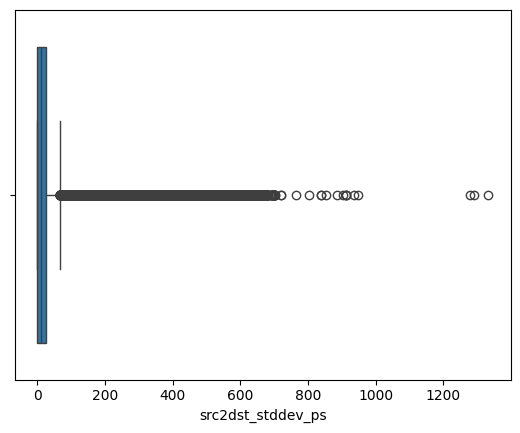

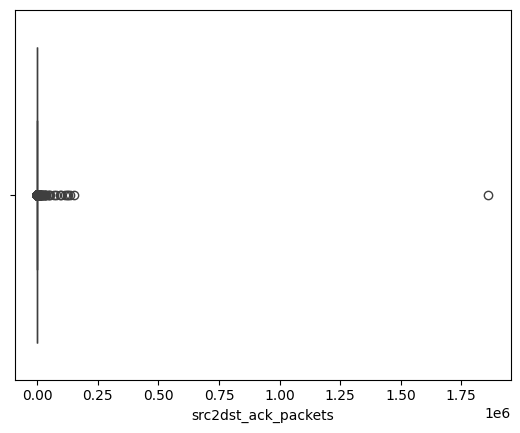

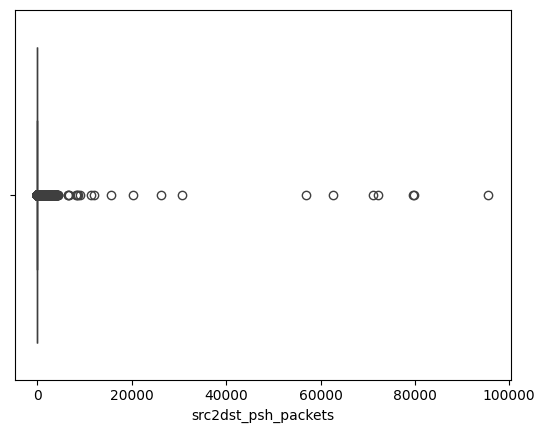

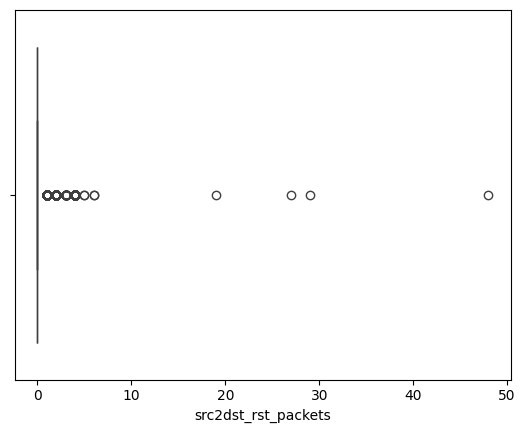

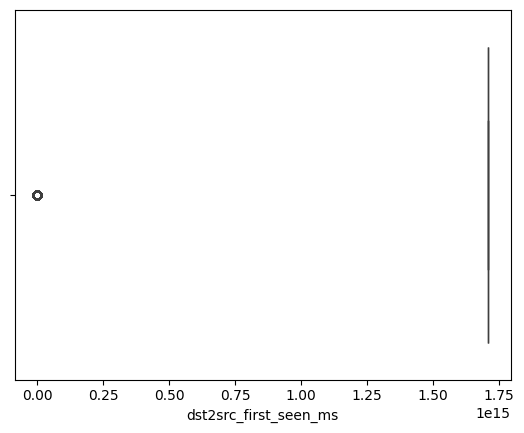

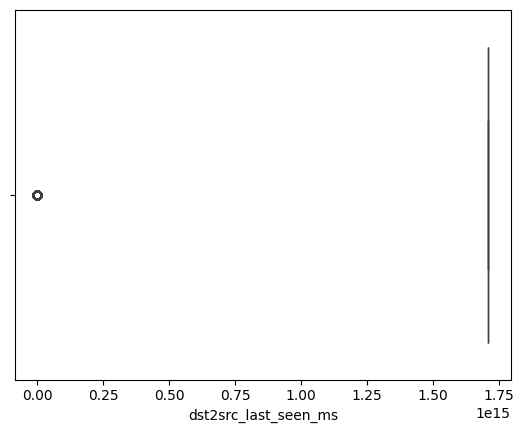

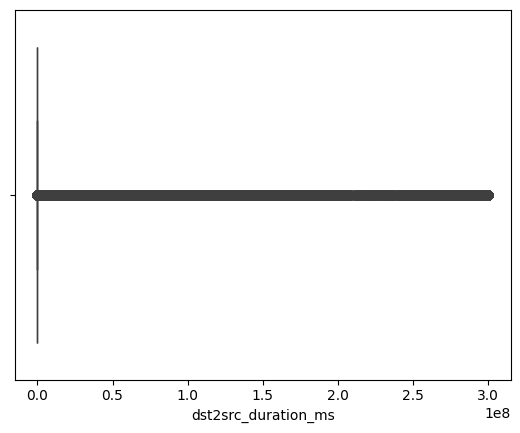

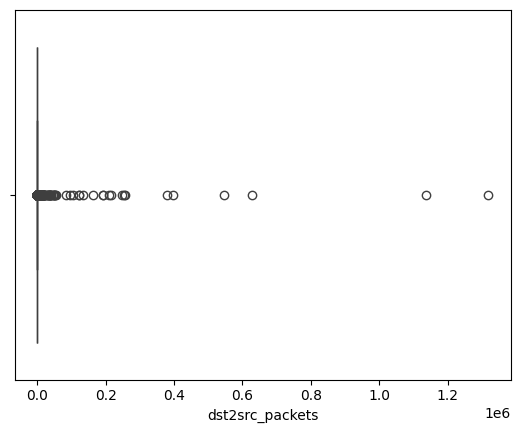

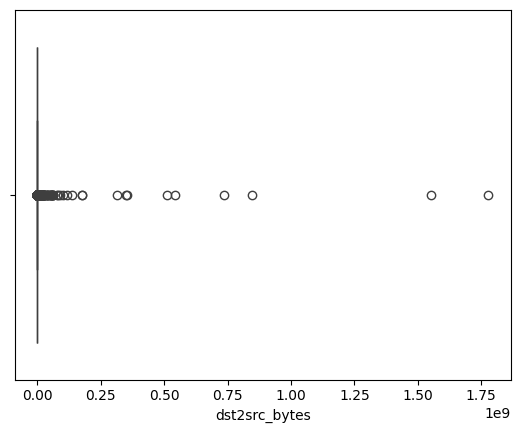

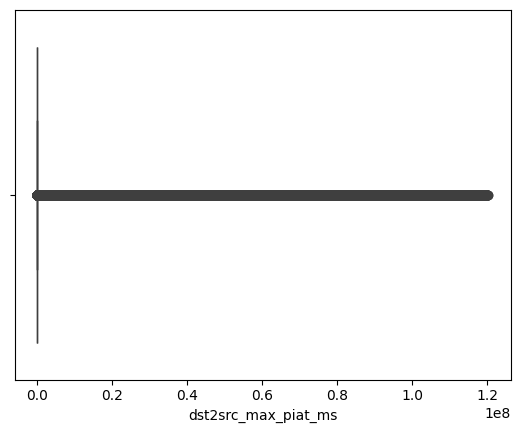

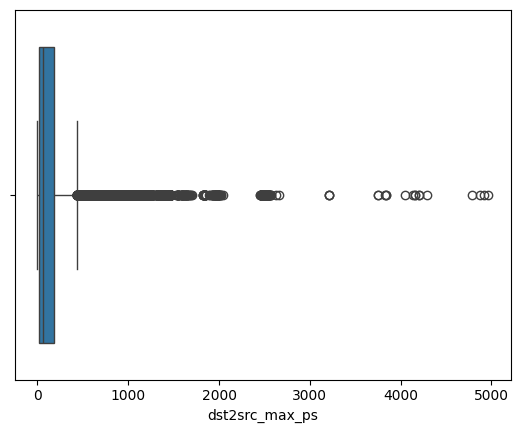

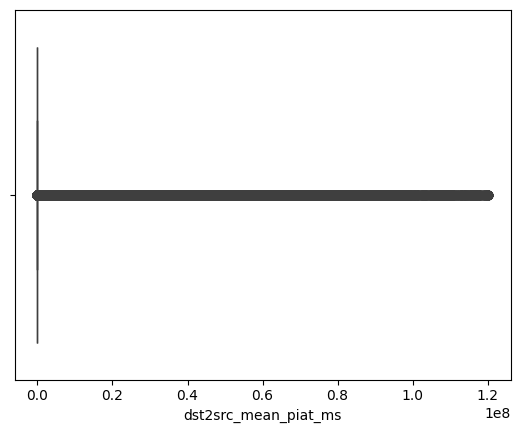

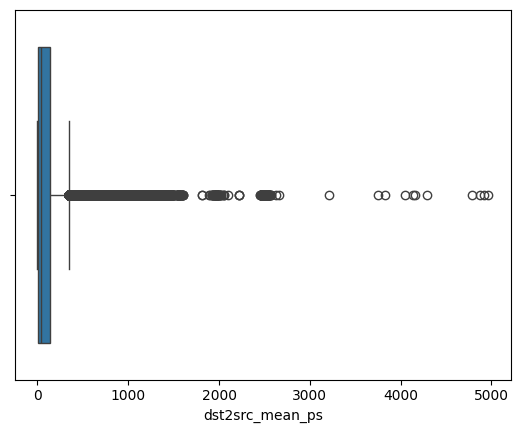

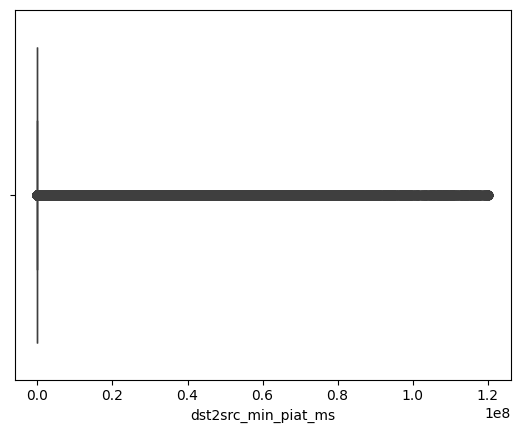

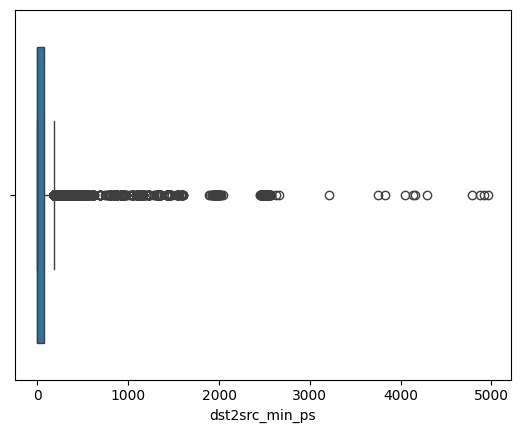

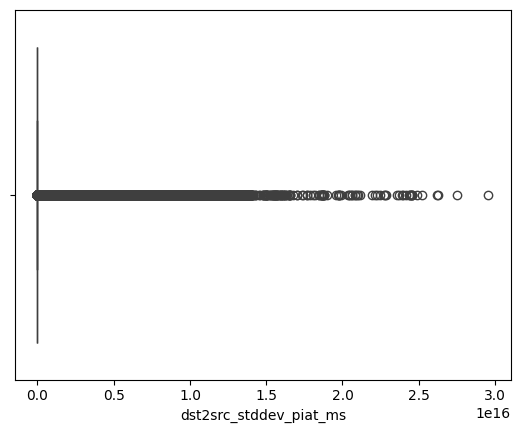

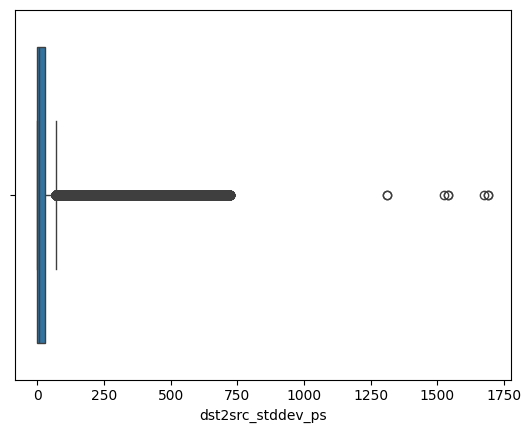

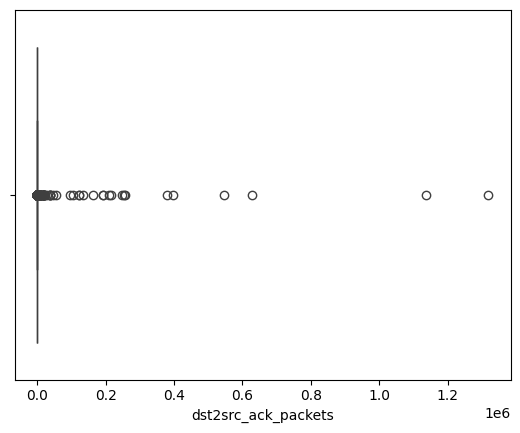

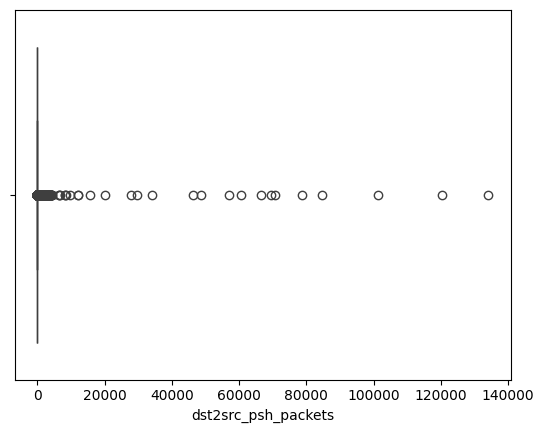

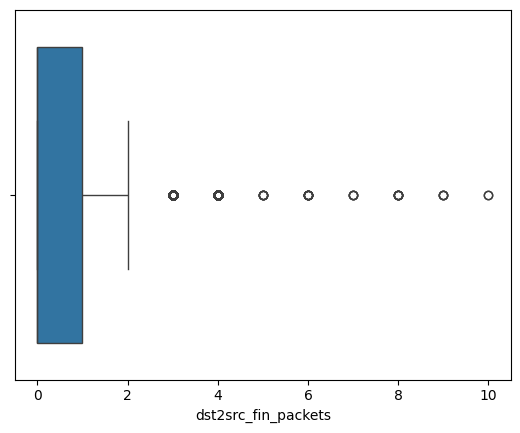

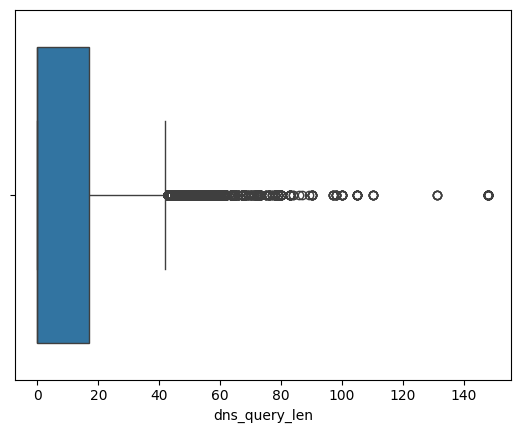

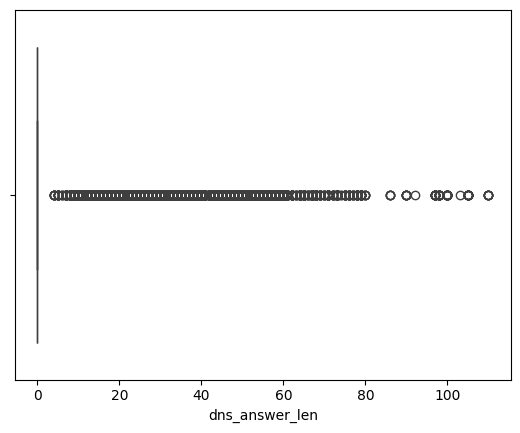

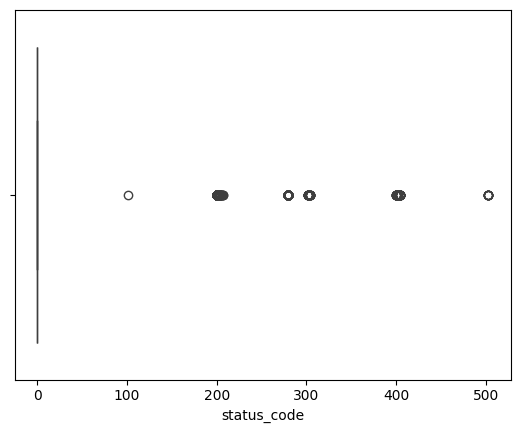

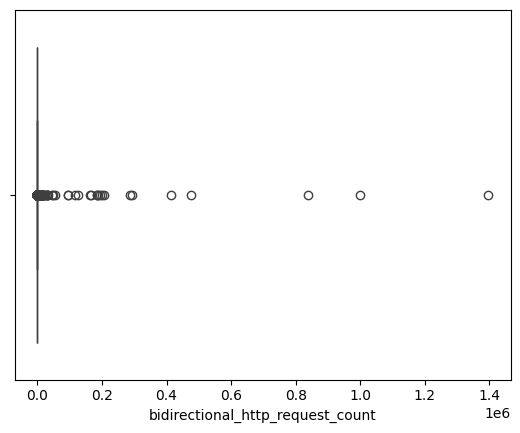

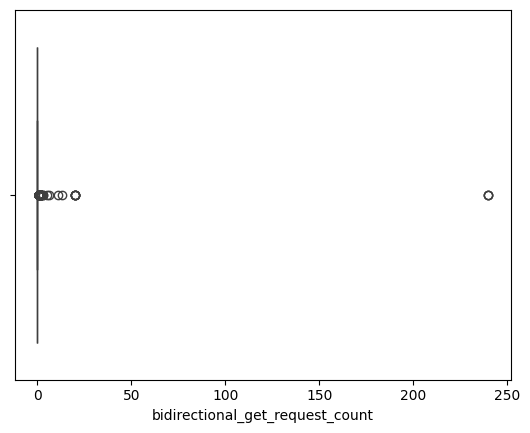

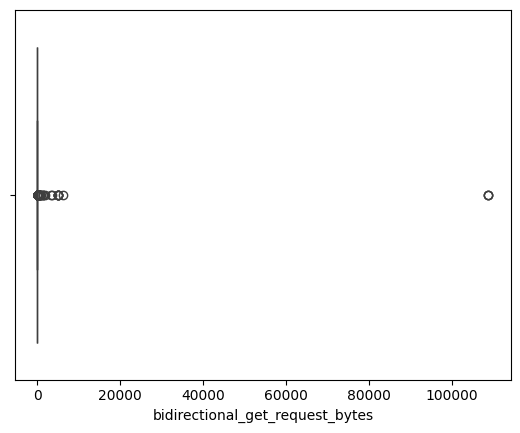

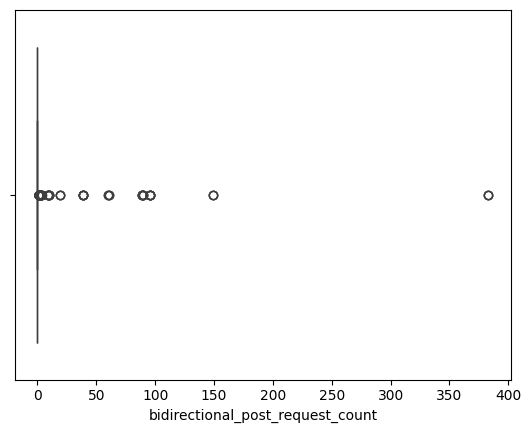

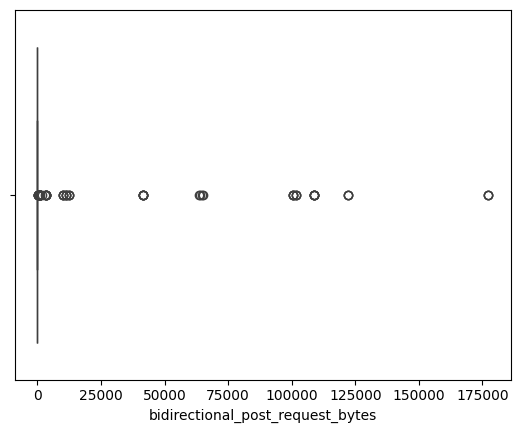

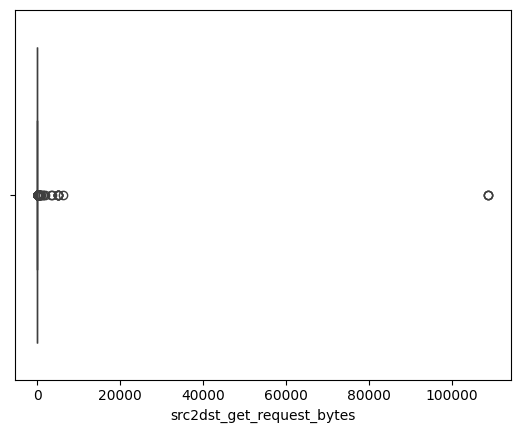

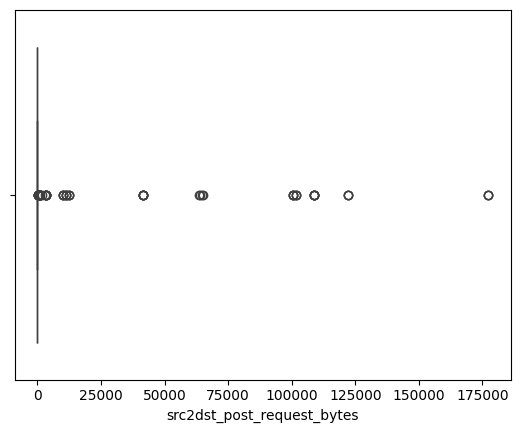

In [9]:
########################### AYKIRI DEĞER ANALİZİ

check_df(df)

# grafiklerden gördüğümüz gibi aykırı değerler mevcut
for col in num_cols:
    sns.boxplot(x=df[col], data=df)
    plt.show(block=True)

In [11]:
# Normalde q1= 0,25 ve q3=0,75 alınmalıdır fakat bu veri seti çok büyük olduğu için olası
# veri anlamlındırmayı bozmamak adına kendim bu şekilde tercih ettim ufak bi traslamak adına 0.05 e 0.95.
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    """
    Fonksiyonun amacı, bir veri çerçevesindeki belirli bir sayısal sütun için aykırı değerlerin tespit edilmesine
    yardımcı olacak alt ve üst eşik değerlerini hesaplamaktır. Bu eşikler, verideki uç değerleri belirlemek için kullanılır.

    Parameters
    ----------
    dataframe : Üzerinde işlem yapılacak pandas veri çerçevesi.
    col_name : Aykırı değerlerin tespit edileceği sütunun adı.
    q1 : Alt çeyrek (quantile) değeri. Varsayılan olarak %25 (0.25).
    q3: Üst çeyrek (quantile) değeri. Varsayılan olarak %75 (0.75).

    Returns
    -------

    """
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit



In [12]:
def check_outlier(dataframe, col_name):
    """
    Fonksiyonun amacı, bir veri çerçevesindeki belirli bir sütunda aykırı değerlerin olup olmadığını kontrol etmektir.
    Aykırı değerlerin tespit edilmesi, veri temizleme ve analiz sürecinde önemli bir adımdır.

    Parameters
    ----------
    dataframe : Üzerinde işlem yapılacak pandas veri çerçevesi.
    col_name : Aykırı değerlerin kontrol edileceği sütunun adı.

    Returns
    -------

    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# ne istemiyorsak onu çıkartıyoruz burada "event_time" tarihleri barındırdığı için numerik kolonlara dahil etmiyorum çalışmak adına.
for col in num_cols:
    if col != "event_time":
        print(col, check_outlier(df, col))

source_port False
destination_port True
app_protocol False
package_count True
bidirectional_first_seen_ms False
bidirectional_last_seen_ms False
bidirectional_duration_ms True
bidirectional_bytes True
bidirectional_max_piat_ms True
bidirectional_max_ps True
bidirectional_mean_piat_ms True
bidirectional_mean_ps True
bidirectional_min_piat_ms True
bidirectional_min_ps True
bidirectional_packets True
bidirectional_stddev_piat_ms True
bidirectional_stddev_ps True
bidirectional_syn_packets True
bidirectional_ack_packets True
bidirectional_psh_packets True
bidirectional_rst_packets True
bidirectional_fin_packets True
src2dst_first_seen_ms False
src2dst_last_seen_ms False
src2dst_duration_ms True
src2dst_packets True
src2dst_bytes True
src2dst_max_piat_ms True
src2dst_max_ps True
src2dst_mean_piat_ms False
src2dst_mean_ps True
src2dst_min_piat_ms True
src2dst_min_ps True
src2dst_stddev_ps True
src2dst_ack_packets True
src2dst_psh_packets True
src2dst_rst_packets True
dst2src_first_seen_ms Fal

In [ ]:
## AYKIRI DEĞER PROBLEMİNİ ÇÖZME
# aykırı değerleri silmek için kullanılabilir ama veri kaybetmemek için kullanmadım.
# çünkü en yüksek package_count un içerisindeki veriyle kıyaslamam gerekecek.
def remove_outlier(dataframe, col_name):
    """
    Fonksiyonun amacı, belirli bir sütundaki aykırı değerleri (outliers) veri çerçevesinden çıkarmaktır.
    Bu işlem, veriyi daha temiz ve analiz edilebilir hale getirmek için kullanılır.

    Parameters
    ----------
    dataframe : Üzerinde işlem yapılacak pandas veri çerçevesi.
    col_name : Aykırı değerlerin kaldırılacağı sütunun adı.

    Returns
    -------

    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

## for col in num_cols:
    new_df = remove_outlier(df,col)

In [ ]:
## Veriyi kaybetmemek için aykırı değerler yakalandıktan sonra eşlik değerlerle değiştirme BASKILAMA yöntemi.
## Yine buradaki verilerle ilk defa çalıştığım için yanlış birşey yapmamak adına kullanmadım.
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    """

Bu kodun işlevi, bir pandas DataFrame'deki belirli bir sütunun (değişkenin) aşırı uç (outlier) değerlerini belirli
eşiklere göre değiştirmektir. Fonksiyon, kullanıcının belirlediği yüzdelik dilimlere göre (q1 ve q3) alt ve üst
sınırları hesaplar ve bu sınırların dışındaki değerleri bu sınırlarla değiştirir.
    Parameters
    ----------
    dataframe :Üzerinde işlem yapılacak pandas DataFrame nesnesi.
    variable :Aşırı uç değerleri kontrol edilecek ve gerektiğinde değiştirilecek sütunun adı (string formatında).
    q1 :(opsiyonel): Alt sınırı belirlemek için kullanılacak yüzdelik dilim (default değeri 0.25 yani %25)
    q3 :(opsiyonel): Üst sınırı belirlemek için kullanılacak yüzdelik dilim (default değeri 0.75 yani %75).

    Returns
    -------

    """
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    if col != "event_time":
        replace_with_thresholds(df, col)

In [13]:
################ EKSİK DEĞER ANALİZİ
################ Eksik değerlerin yakalanması

df.isnull().values.any()
# veri setindeki toplam eksik değer sayısı.
df.isnull().sum().sum()
check_df(df)
#msno.bar(df)
#plt.show()
#msno.matrix(df)
#plt.show()
#msno.heatmap(df)
#plt.show()

#### Gereksiz olan boş verileri silelim NaN Tespit ettiğim boş NaN veriler gereksiz yer kapladığı için silmeyi tercih ettim.
nan_columns = df.columns[df.isna().all()]

##################### Shape ##########################
(160983, 165)
##################### Types ##########################
sync_name                  object
source_address             object
destination_address        object
source_port                 int64
destination_port            int64
                           ...   
session_id                 object
session_id_from_time       object
protocol_name              object
source_asset_type         float64
destination_asset_type    float64
Length: 165, dtype: object
##################### Head ##########################
     sync_name source_address destination_address  source_port  destination_port  protocol  app_protocol application_name application_category_name master_application_name  tunnel_source_address  tunnel_destination_address         source_mac    destination_mac  tunnel_value  package_count  login_fail_count  login_success  expiration_id  drop_eligible  priority  vlan_identifier  \
0  master-node  192.168.2.100         

In [14]:
for col in nan_columns:
    print(f'Column {col} contains only NaN values')

df.drop(["ndr_name","server_side_using_capability","mail_recipient","request_uri_arr","tunnel_destination_address","tunnel_source_address"], axis=1, inplace=True)

#### nanların tespiti, Burada NaN lar varmı yokmu onları kontrol ettim bu örnekte nan sayıları bu kadar fakat kod akışı sırasında bu kolona ihticaımız olacağı için silmemeyi tercih ettim.
nan_count = df['http_request'].isna().sum()
print(f'The column "http_request" contains {nan_count} NaN values')

Column tunnel_source_address contains only NaN values
Column tunnel_destination_address contains only NaN values
Column request_uri_arr contains only NaN values
Column mail_recipient contains only NaN values
Column server_side_using_capability contains only NaN values
Column ndr_name contains only NaN values
Column source_asset_type contains only NaN values
Column destination_asset_type contains only NaN values
The column "http_request" contains 160018 NaN values


In [15]:
#### Eksik değerlerin veri setindeki oranları
def missing_values_table(dataframe, na_name=False):
    """
    Bu kod, bir pandas DataFrame içindeki eksik değerlerin (NaN) sayısını ve bu eksik değerlerin her sütundaki
    yüzdesini hesaplayıp gösterir. İsteğe bağlı olarak eksik değere sahip sütunların isimlerini döndürür.
    Parameters
    ----------
    dataframe : Üzerinde işlem yapılacak pandas DataFrame nesnesi.
    na_name : (opsiyonel): Eğer True olarak ayarlanırsa, eksik değerlere sahip sütunların isimlerini bir liste olarak döndürür. Varsayılan değeri False'tur.

    Returns
    -------

    """
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

                          n_miss   ratio
destination_asset_type    160983 100.000
source_asset_type         160983 100.000
dns_answer_addresses      160980 100.000
first_http_post_body      160836  99.910
request_host              160084  99.440
user_agent                160078  99.440
http_request              160018  99.400
status                    159503  99.080
request_uri               159456  99.050
ja3_server                153361  95.270
ja3_client                146673  91.110
dns_answer_name           129587  80.500
dns_answer_type           126732  78.720
dns_query_sub_domain      115237  71.580
dns_query_main_domain     113784  70.680
dns_server_direction      108290  67.270
dns_query_name            108290  67.270
dns_query_type            105431  65.490
destination_hostname_arr   83172  51.670
request_type               74715  46.410


In [16]:
#### Date değişkenimizi çalışmak için uygun formata getirelim.
df['event_time'] = pd.to_datetime(df['event_time'])
df["event_time"].value_counts()
datetime_vars = [col for col in df.columns if df[col].dtypes == "datetime"]

İçten içe trafik yoğunluğu: 0           1
5           1
9           1
15          1
17          1
         ... 
159794    224
159817      6
160113     18
160373      2
160480      2
Name: package_count, Length: 4235, dtype: int64
İçten dışa trafik yoğunluğu: 410        2
416        2
420        4
422        2
440        2
          ..
160891    14
160892    14
160906     2
160922     2
160961    36
Name: package_count, Length: 17865, dtype: int64
İçten içe trafik yoğunluğu: 1          1
2          1
4          1
8          1
10         1
          ..
160927     2
160952     8
160963    30
160965     2
160972    84
Name: package_count, Length: 20744, dtype: int64
İçten dışa trafik yoğunluğu: 45         6
47         2
54         4
63         2
67         2
          ..
160975     4
160977     8
160978     8
160979     6
160981    12
Name: package_count, Length: 10980, dtype: int64


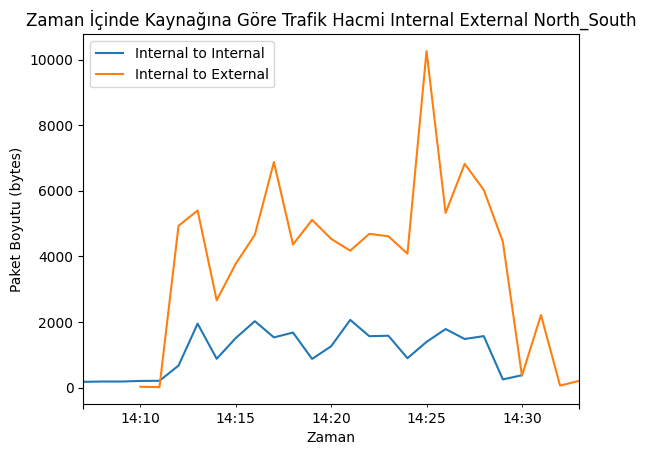

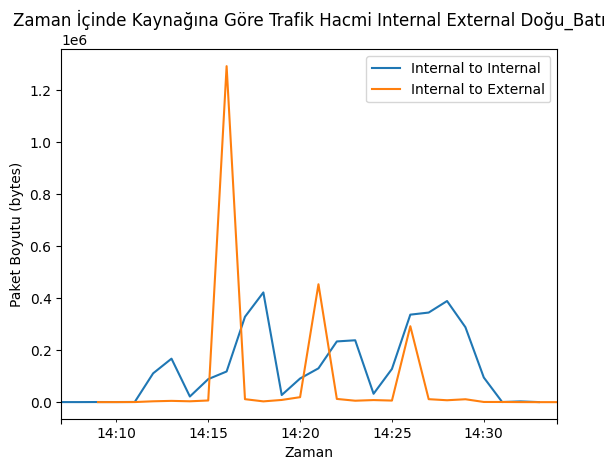

En çok trafik yapan IP,Port External ve İnternal Adresleri:
 direction          source_address  source_port
INTERNAL2INTERNAL  10.1.40.35      59898          3083040
                   10.1.40.30      20703          2117154
                   10.10.40.17     54694          2023037
                   10.1.76.110     762             976429
                   10.10.89.10     3260            883531
                   10.10.92.110    52886           440625
                                   33832           230231
                                   43974           180580
                   10.1.68.100     50814           168686
INTERNAL2EXTERNAL  10.1.96.10      16436           110329
INTERNAL2INTERNAL  10.10.100.100   61734           108085
INTERNAL2EXTERNAL  10.1.96.10      29546            96064
INTERNAL2INTERNAL  10.10.145.13    60986            91147
                   10.10.92.110    55800            76086
                   10.10.111.12    63300            74796
Name: package_count, d

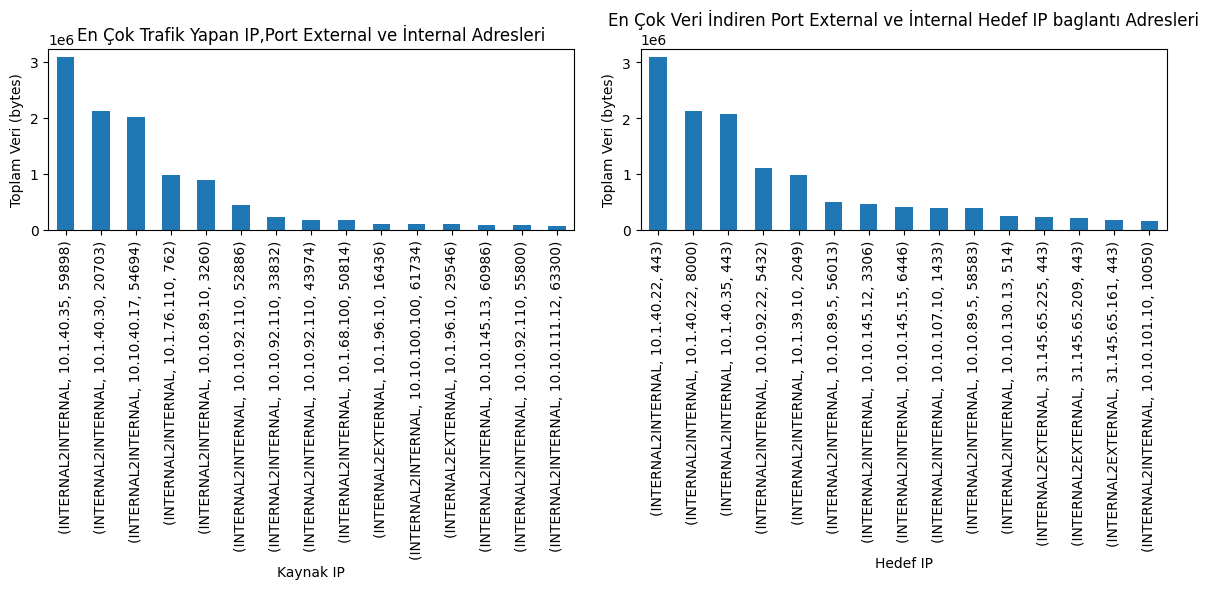

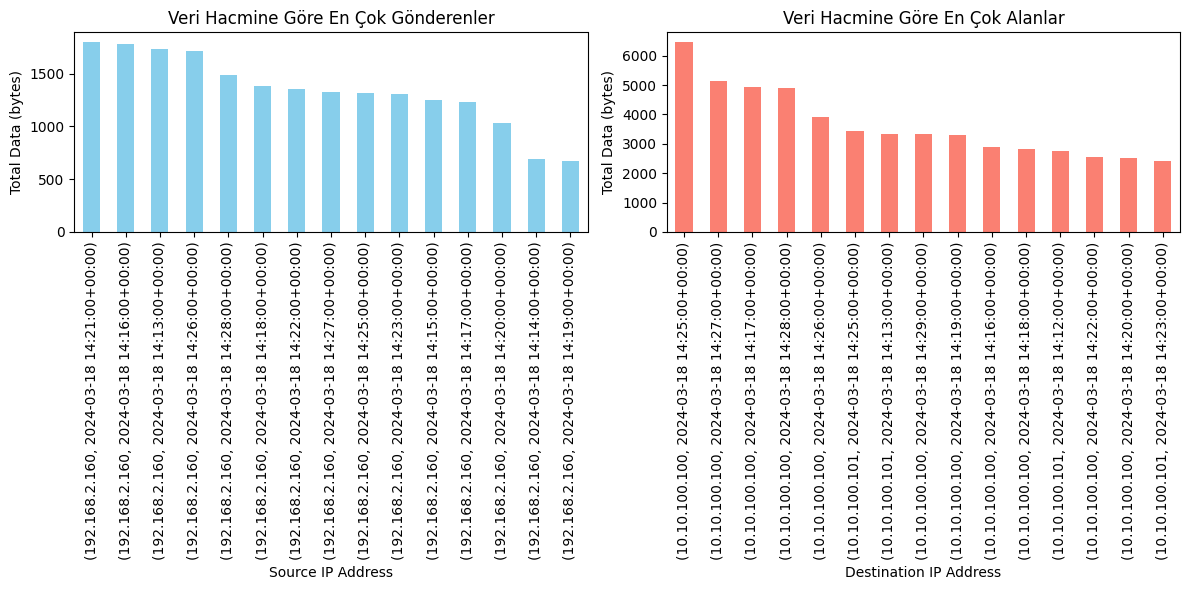

<Figure size 640x480 with 0 Axes>

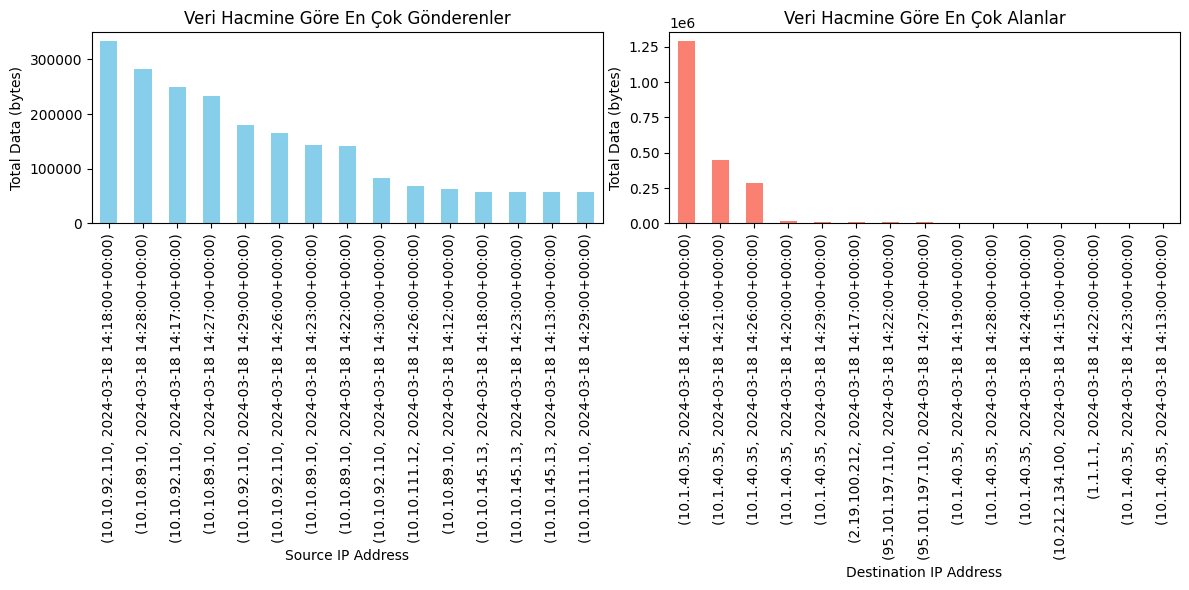

source_address
10.1.40.35      3217216
10.1.40.30      2158072
10.10.40.17     2023263
10.10.92.110    1112400
10.1.76.110      977658
10.10.89.10      883889
10.1.96.10       847004
10.1.66.175      791076
10.1.68.100      723591
10.10.145.13     316715
Name: package_count, dtype: int64
destination_address
10.1.40.22       5228472
10.1.40.35       2071405
10.10.92.22      1112380
10.1.39.10        976587
10.10.89.5        883633
10.10.145.12      453440
10.10.145.15      407944
10.10.107.10      401134
10.10.130.13      254296
31.145.65.225     226317
Name: package_count, dtype: int64


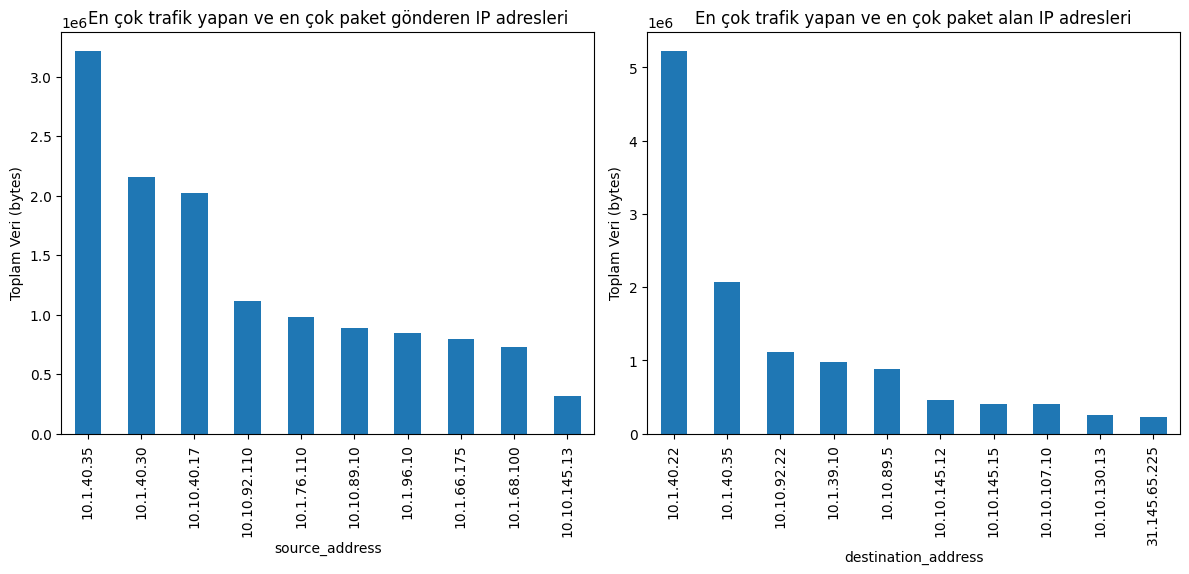

In [17]:
##################### İçten içe ve içten Dışa Trafik analizi
# İçten içe ve içten dışa trafik belirleme
df['internal_to_internal_North_South'] = df.apply(lambda row: row['source_address'].startswith("192.168") and row['destination_address'].startswith("192.168"), axis=1)
df['internal_to_external_North_South'] = df.apply(lambda row: row['source_address'].startswith("192.168") and not row['destination_address'].startswith("192.168"), axis=1)
df['internal_to_internal_North_South'].value_counts(dropna=False)
df['internal_to_external_North_South'].value_counts(dropna=False)

df['internal_to_internal_East_West'] = df.apply(lambda row: row['source_address'].startswith("10.10") and row['destination_address'].startswith("10.10"), axis=1)
df['internal_to_external_East_West'] = df.apply(lambda row: row['source_address'].startswith("10.10") and not row['destination_address'].startswith("10.10"), axis=1)
df['internal_to_internal_East_West'].value_counts(dropna=False)
df['internal_to_external_East_West'].value_counts(dropna=False)

# İçten içe ve içten dışa trafik yoğunluğu Kuzey Güneye göre
internal_to_internal_traffic = df[df['internal_to_internal_North_South']]
internal_to_external_traffic = df[df['internal_to_external_North_South']]
print("İçten içe trafik yoğunluğu:", internal_to_internal_traffic['package_count'])
print("İçten dışa trafik yoğunluğu:", internal_to_external_traffic['package_count'])

# İçten içe ve içten dışa trafik yoğunluğu Doğu Batıya göre
internal_to_internal_traffic2 = df[df['internal_to_internal_East_West']]
internal_to_external_traffic2 = df[df['internal_to_external_East_West']]
print("İçten içe trafik yoğunluğu:", internal_to_internal_traffic2['package_count'])
print("İçten dışa trafik yoğunluğu:", internal_to_external_traffic2['package_count'])

# Kaynağına göre en youğun zamanı gösteren grafik Kuzey_Guney
df['event_time_index'] = df['event_time']
df.set_index('event_time_index', inplace=True)
internal_to_internal_traffic3 = df[df['internal_to_internal_North_South']]['package_count'].resample('T').sum()
internal_to_external_traffic3 = df[df['internal_to_external_North_South']]['package_count'].resample('T').sum()
internal_to_internal_traffic3.plot(label='Internal to Internal')
internal_to_external_traffic3.plot(label='Internal to External')
plt.title('Zaman İçinde Kaynağına Göre Trafik Hacmi Internal External North_South')
plt.xlabel('Zaman')
plt.ylabel('Paket Boyutu (bytes)')
plt.legend()
plt.show()

# Kaynağına göre en youğun zamanı gösteren grafik Dogu_batı
df['event_time_index'] = df['event_time']
df.set_index('event_time_index', inplace=True)
internal_to_internal_traffic4 = df[df['internal_to_internal_East_West']]['package_count'].resample('T').sum()
internal_to_external_traffic4 = df[df['internal_to_external_East_West']]['package_count'].resample('T').sum()
internal_to_internal_traffic4.plot(label='Internal to Internal')
internal_to_external_traffic4.plot(label='Internal to External')
plt.title('Zaman İçinde Kaynağına Göre Trafik Hacmi Internal External Doğu_Batı')
plt.xlabel('Zaman')
plt.ylabel('Paket Boyutu (bytes)')
plt.legend()
plt.show()

## trafik yönlerine, IP ve Port'a göre paket indirme/yükleme sayısının toplamı

top_sender_ornek = df.groupby(['direction',"source_address","source_port",])['package_count'].sum().sort_values(ascending=False).head(15)
print("En çok trafik yapan IP,Port External ve İnternal Adresleri:\n", top_sender_ornek)
top_receivers_ornek = df.groupby(['direction',"destination_address","destination_port"])['package_count'].sum().sort_values(ascending=False).head(15)
print("En Çok Veri İndiren Port External ve İnternal Hedef IP baglantı Adresleri:\n", top_receivers_ornek)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
top_sender_ornek.plot(kind='bar')
plt.title('En Çok Trafik Yapan IP,Port External ve İnternal Adresleri')
plt.xlabel('Kaynak IP')
plt.ylabel('Toplam Veri (bytes)')
plt.subplot(1, 2, 2)
top_receivers_ornek.plot(kind='bar')
plt.title('En Çok Veri İndiren Port External ve İnternal Hedef IP baglantı Adresleri')
plt.xlabel('Hedef IP')
plt.ylabel('Toplam Veri (bytes)')
plt.tight_layout()
plt.show()

# destination_address ve source_address"e göre filtrelenmiş ve dakika cinsinden örnekleme yaparak toplam veri (bytes) hesaplanıyor North_South
top_senders3 = df[df['internal_to_internal_North_South']].set_index("event_time").groupby('source_address').resample('T')['package_count'].sum().sort_values(ascending=False).head(15)
top_receivers3 = df[df['internal_to_external_North_South']].set_index("event_time").groupby('destination_address').resample('T')['package_count'].sum().sort_values(ascending=False).head(15)

# Grafiklerin çizdirilmesi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
top_senders3.plot(kind='bar', color='skyblue')
plt.title('Veri Hacmine Göre En Çok Gönderenler')
plt.xlabel('Source IP Address')
plt.ylabel('Total Data (bytes)')
plt.subplot(1, 2, 2)
top_receivers3.plot(kind='bar', color='salmon')
plt.title('Veri Hacmine Göre En Çok Alanlar')
plt.xlabel('Destination IP Address')
plt.ylabel('Total Data (bytes)')
plt.tight_layout()
plt.show()

plt.clf()# silmek için kullan

# destination_address ve source_address"e göre filtrelenmiş ve dakika cinsinden örnekleme yaparak toplam veri (bytes) hesaplanıyor
top_senders5 = df[df['internal_to_internal_East_West']].set_index("event_time").groupby('source_address').resample('T')['package_count'].sum().sort_values(ascending=False).head(15)
top_receivers5 = df[df['internal_to_external_East_West']].set_index("event_time").groupby('destination_address').resample('T')['package_count'].sum().sort_values(ascending=False).head(15)

# Grafiklerin çizdirilmesi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
top_senders5.plot(kind='bar', color='skyblue')
plt.title('Veri Hacmine Göre En Çok Gönderenler')
plt.xlabel('Source IP Address')
plt.ylabel('Total Data (bytes)')
plt.subplot(1, 2, 2)
top_receivers5.plot(kind='bar', color='salmon')
plt.title('Veri Hacmine Göre En Çok Alanlar')
plt.xlabel('Destination IP Address')
plt.ylabel('Total Data (bytes)')
plt.tight_layout()
plt.show()

# En çok trafik yapan ve veri indiren IP adresleri
top_senders = df.groupby('source_address')['package_count'].sum().sort_values(ascending=False).head(10)
top_receivers = df.groupby('destination_address')['package_count'].sum().sort_values(ascending=False).head(10)
print(top_senders)
print(top_receivers)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
top_senders.plot(kind='bar')
plt.title('En çok trafik yapan ve en çok paket gönderen IP adresleri')
plt.xlabel('source_address')
plt.ylabel('Toplam Veri (bytes)')
plt.subplot(1, 2, 2)
top_receivers.plot(kind='bar')
plt.title('En çok trafik yapan ve en çok paket alan IP adresleri')
plt.xlabel('destination_address')
plt.ylabel('Toplam Veri (bytes)')
plt.tight_layout()
plt.show()

Aşşağıdaki Script Biraz geç çalışıyor amacıysa Boş port taraması yapmak ve kanal ve ıp adrese göre açık portu bulmaya yaramaktadır.

In [ ]:
import pandas as pd
import socket
def port_scan(ip, port):
    try:
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.settimeout(1)
        result = sock.connect_ex((ip, port))
        if result == 0:
            print(f"Port {port} is open on {ip}")
        sock.close()
    except KeyboardInterrupt:
        print("Ctrl+C'ye basıldı. Çıkılıyor...")
    except socket.gaierror:
        print("Hostname doğru bir şekilde çözülemedi. Çıkılıyor...")
    except socket.error:
        print("Sunucuya bağlanırken bir hata oluştu. Çıkılıyor...")

# Veri çerçevesindeki her bir IP adresi ve port için port taraması yapalım
for index, row in df.iterrows():
    ip = row['source_address']
    port = row['source_port']
    port_scan(ip, port)

port_scan("source_address", "source_port")

####

# Potansiyel port taramalarını tespit etme :
# Kaynak IP'lerin kaç farklı porta bağlandığı sayı
port_counts = df.groupby('source_address')['destination_port'].nunique()
# Özet istatistikler
print(port_counts.describe())

# Standrt a göre 35 ayarlandı araştırmalarım sonucu
port_tarama_esik = 35

port_taramalari = df.groupby('source_address').filter(lambda x: x['destination_port'].nunique() > port_tarama_esik)
print("Potansiyel Port Taramaları:")
print(port_taramalari)

Yukarıdaki port taramasının örnek çıktılarını burada:
Port 443 is open on 92.38.180.106
Port 443 is open on 142.250.157.188
Port 443 is open on 142.250.150.188
Port 443 is open on 157.240.9.18
Port 443 is open on 34.120.3.25
Port 443 is open on 66.203.125.15
Port 443 is open on 151.101.65.208
Port 443 is open on 157.240.234.34
Port 443 is open on 157.240.238.34
Port 443 is open on 142.250.157.188
Port 443 is open on 157.240.238.34
Port 443 is open on 104.16.38.9


Brute Force Saldırıları:
       source_address destination_address  failed_attempts
2         10.1.101.10        10.10.107.13               71
5         10.1.40.100         10.1.40.101               21
11        10.1.40.100         10.1.40.254               85
13        10.1.40.100          10.1.73.20               21
16        10.1.40.100      192.168.45.101              569
...               ...                 ...              ...
2926    192.168.88.37       10.10.100.101              104
2929    192.168.88.51       10.10.100.100               47
2930    192.168.88.51       10.10.100.101               38
2932    192.168.88.69       10.10.100.100              186
2950  213.227.139.233          10.1.71.10               39

[561 rows x 3 columns]
En Çok Olan İlk 10 Deneme:
     source_address destination_address  failed_attempts
493     10.1.68.100        10.10.101.10            14647
1372  10.10.100.100             1.1.1.1             7768
413     10.1.66.175          10.1.76.57      

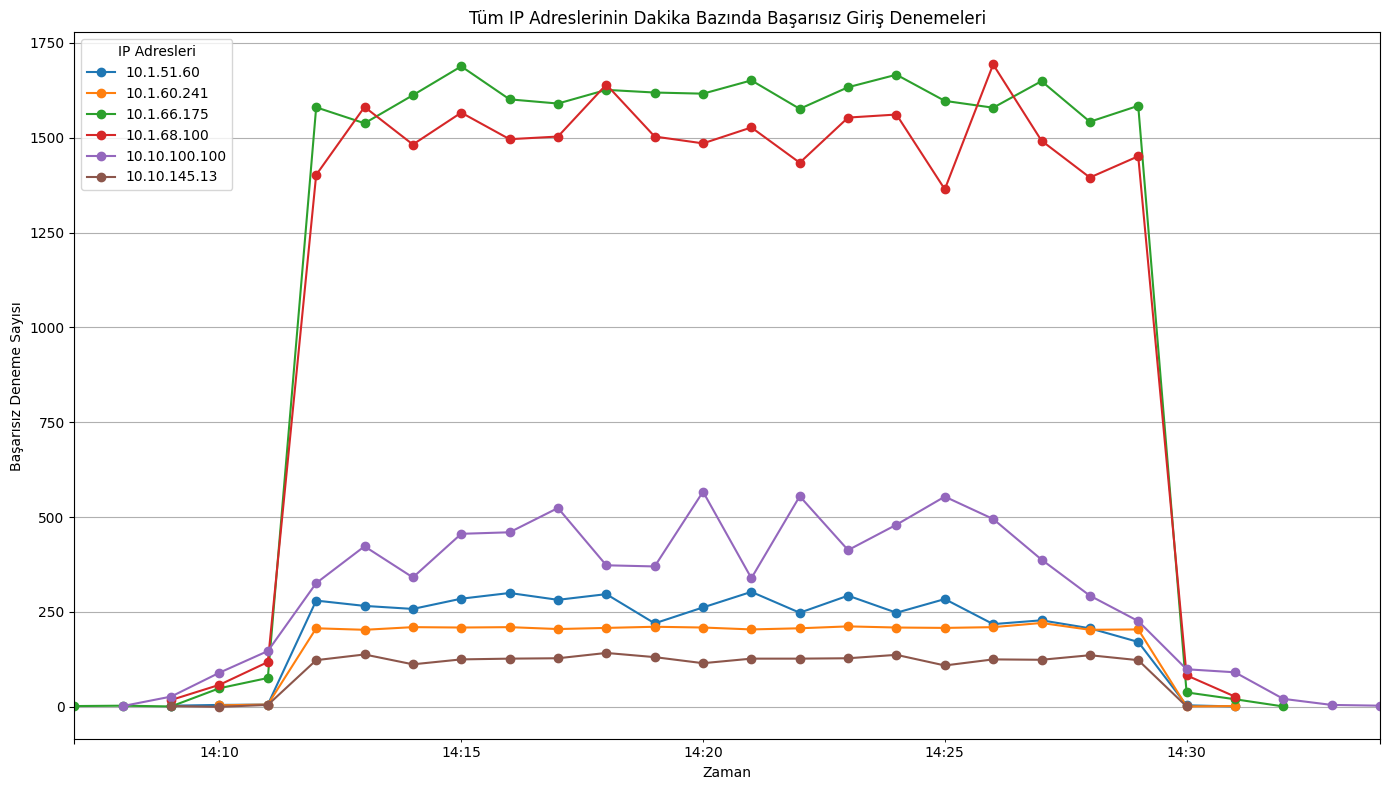

In [18]:
######################## Siber Saldırı: Bruteforce saldırı tespiti  ## status_code, HTTP status code numeric equivalent a göre brutalforce
# Başarısız giriş denemelerini (4xx kodları) sayma
failed_attempts = df[df['status_code'].between(0, 9999)].groupby(['source_address', 'destination_address']).size().reset_index(name='failed_attempts')
# Eşik değeri belirleme (örneğin, 3 başarısız giriş denemesi)
threshold = 20
# Brute force saldırılarını tespit etme
brute_force_attempts = failed_attempts[failed_attempts['failed_attempts'] > threshold]
print("Brute Force Saldırıları:")
print(brute_force_attempts)

thresholdss = 10
brute_force_attempts = failed_attempts[failed_attempts['failed_attempts'] > thresholdss]
# Azalan sırayla sırala ve ilk 10 kaydı seç
top_10_attempts = brute_force_attempts.sort_values(by='failed_attempts', ascending=False).head(10)
print("En Çok Olan İlk 10 Deneme:")
print(top_10_attempts)
filtered_bruteforce_traffic = df[df['source_address'].isin(top_10_attempts['source_address'])]

# Tüm IP adresleri için dakika bazında istek dağılımlarını hesaplama
all_ip_attempts = filtered_bruteforce_traffic.set_index('event_time').groupby('source_address').resample('T').size()
plt.figure(figsize=(14, 8))
all_ip_attempts.unstack(level=0).plot(marker='o', linestyle='-', ax=plt.gca())
plt.title('Tüm IP Adreslerinin Dakika Bazında Başarısız Giriş Denemeleri')
plt.xlabel('Zaman')
plt.ylabel('Başarısız Deneme Sayısı')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='IP Adresleri', loc='upper left')
plt.tight_layout()
plt.show()


Tekrarlanan Kaynak IP Adresleri ve Kaç Kere Tekrar Edildikleri:
source_address
10.10.10.120     870
10.1.66.11       813
192.168.2.160    812
10.1.78.24       512
192.168.1.100    433
                ... 
10.29.2.6         64
10.10.111.254     59
10.10.106.254     56
10.10.109.254     53
10.1.66.12        51
Name: count, Length: 42, dtype: int64

Tekrarlanan Hedef IP Adresleri ve Kaç Kere Tekrar Edildikleri:
destination_address
10.10.10.1       2395
192.168.0.1       893
10.1.66.12        861
192.168.10.1      746
192.168.1.150     739
192.168.100.1     703
10.10.10.254      248
Name: count, dtype: int64
Tekrarlanan Kaynak IP Adresleri ve Kaç Kere Tekrar Edildikleri:
source_address
10.10.10.120      821
10.1.66.11        813
192.168.2.160     812
10.1.78.24        512
192.168.10.2      411
192.168.1.100     411
192.168.100.2     288
192.168.2.100     283
10.10.10.132      269
10.10.10.140      269
10.10.10.134      248
192.168.101.2     247
192.168.101.10    223
10.10.10.225      198
1

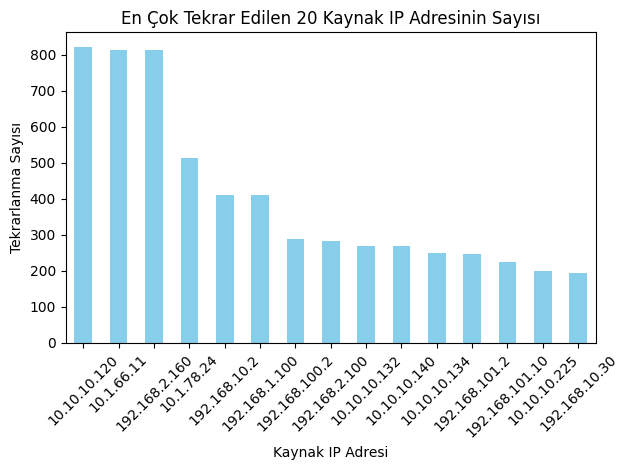

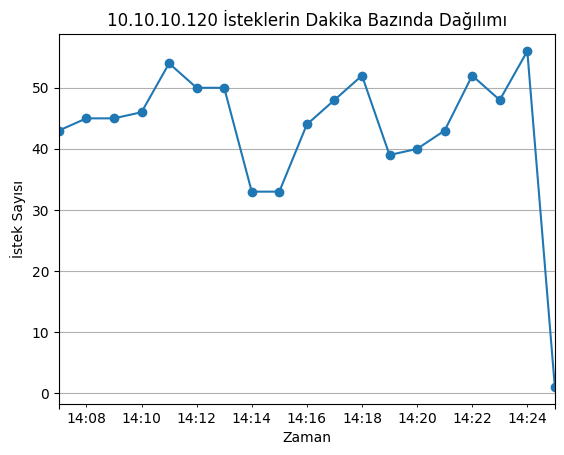

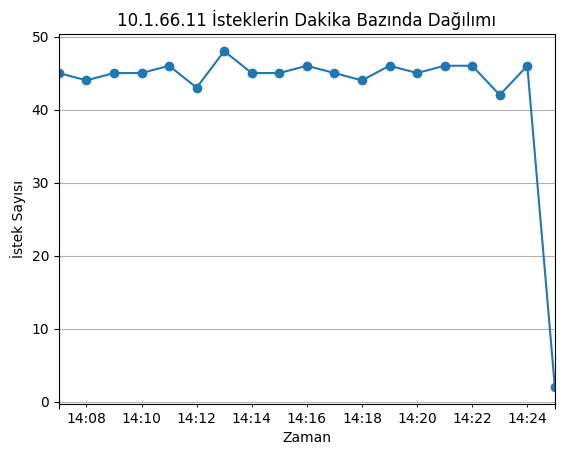

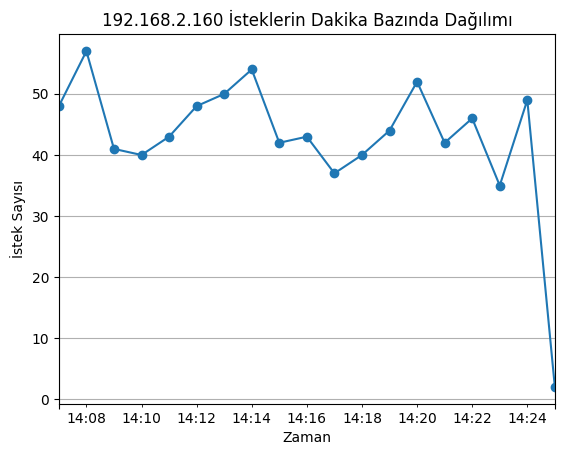

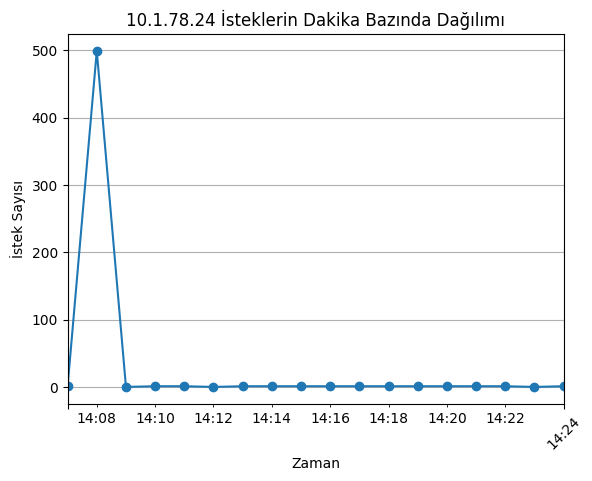

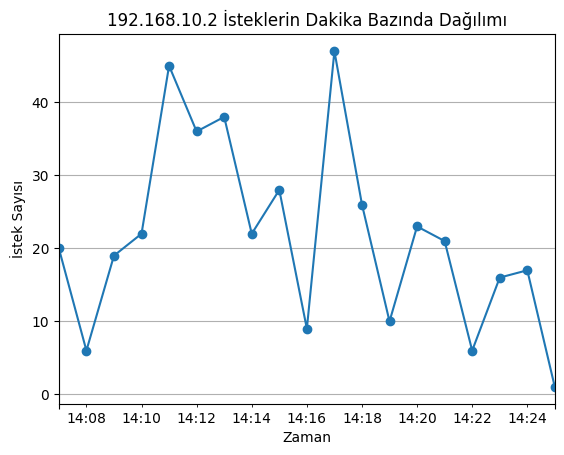

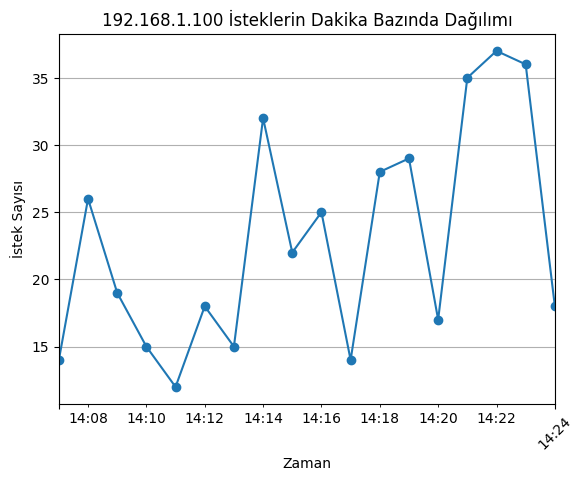

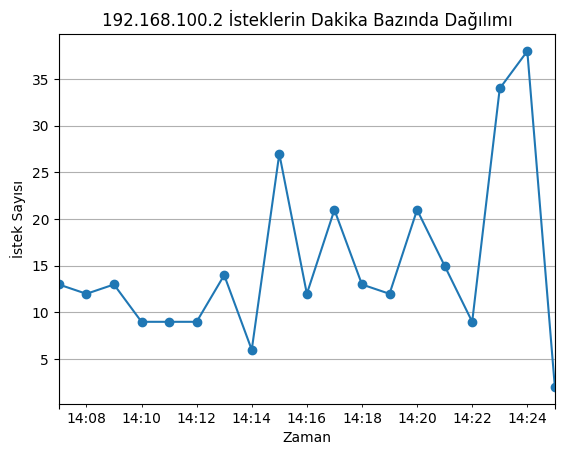

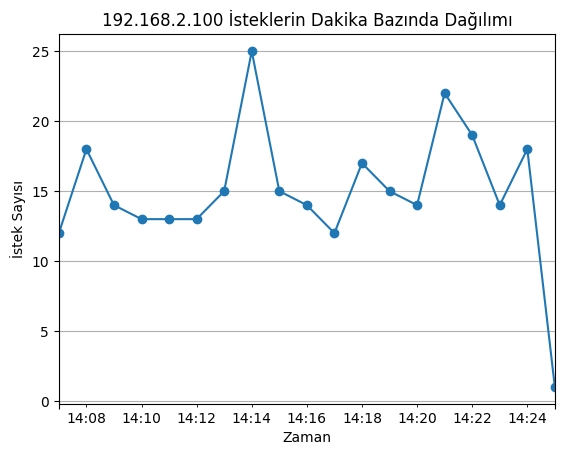

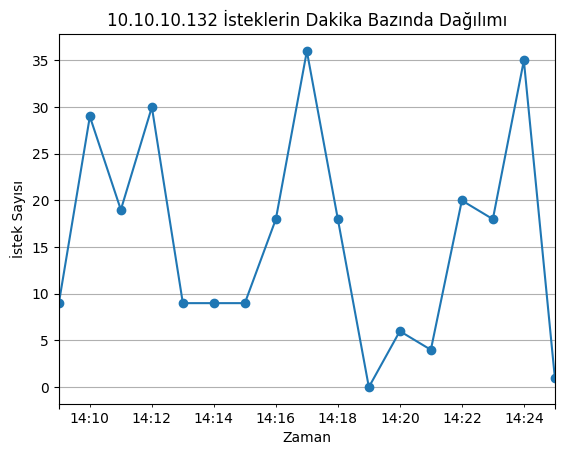

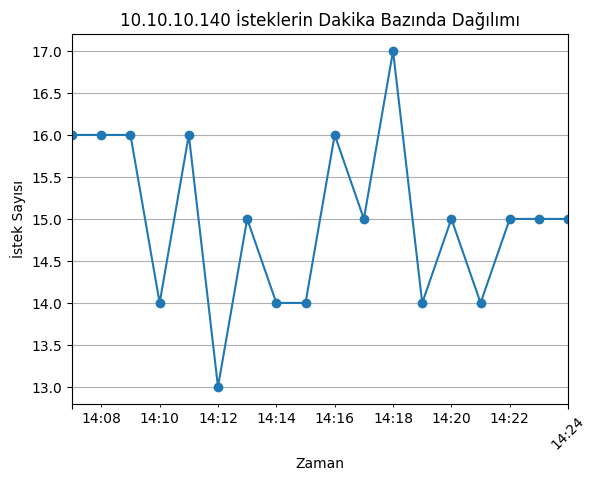

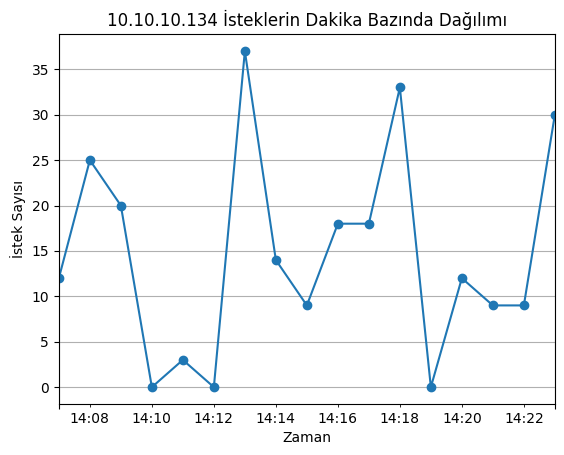

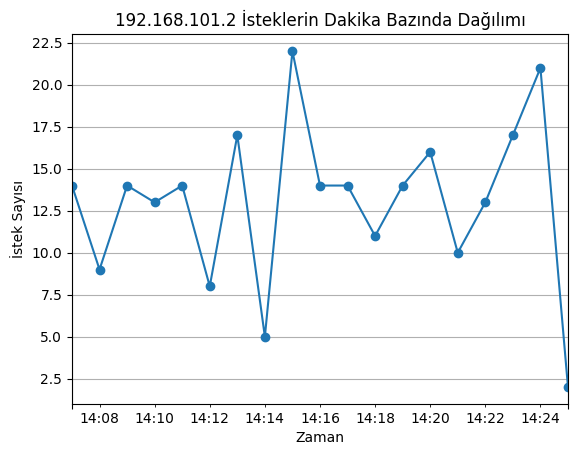

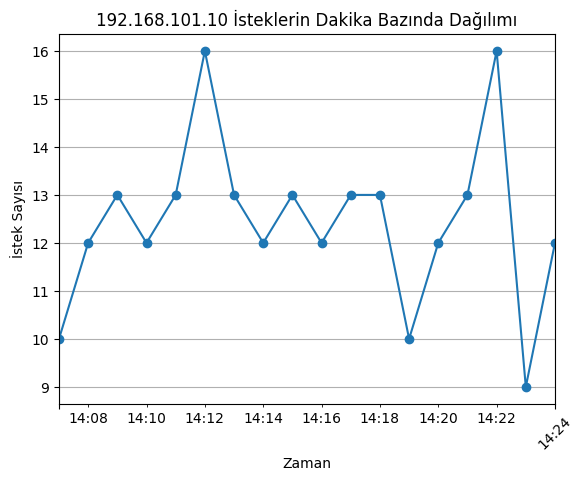

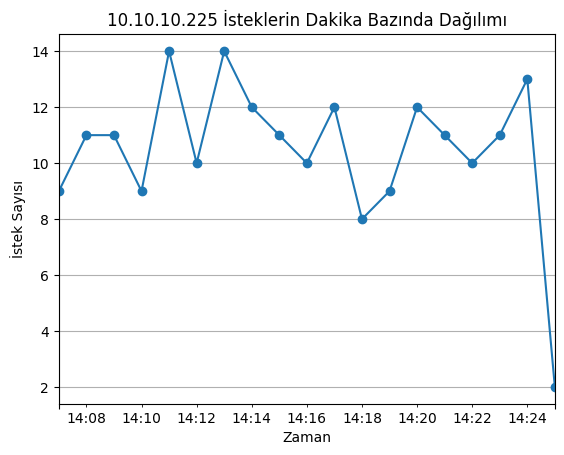

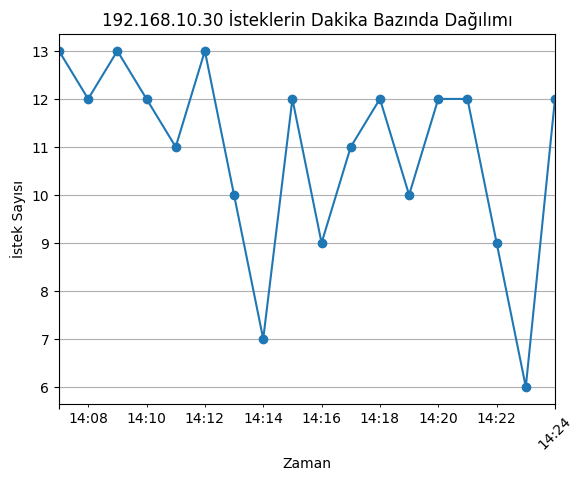

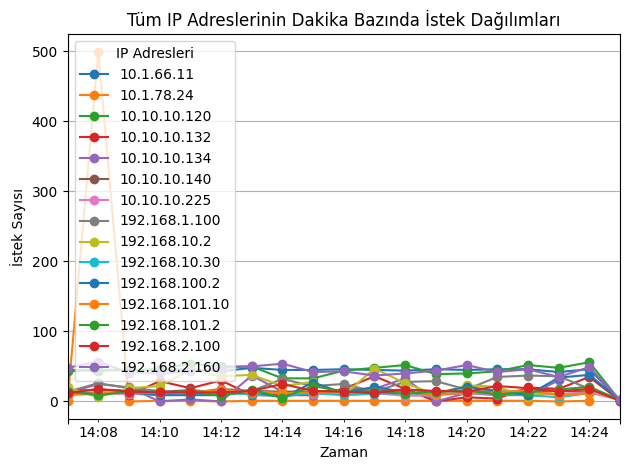

In [19]:
######################################## Siber Saldırı: ARP Taraması Tespiti, ARP-SCAN

arp_traffic = df[(df['application_name'].isin(['ARP-Request', 'ARP-Reply']))&(df['application_category_name'].isin(["ARP"]))]
source_ips = arp_traffic['source_address']
destination_ips = arp_traffic['destination_address']
repeated_source_ips = source_ips[source_ips.duplicated()]
repeated_destination_ips = destination_ips[destination_ips.duplicated()]

source_ip_counts = repeated_source_ips.value_counts()
destination_ip_counts = repeated_destination_ips.value_counts()
print("Tekrarlanan Kaynak IP Adresleri ve Kaç Kere Tekrar Edildikleri:")
print(source_ip_counts[source_ip_counts > 50])

print("\nTekrarlanan Hedef IP Adresleri ve Kaç Kere Tekrar Edildikleri:")
print(destination_ip_counts[destination_ip_counts > 200])

## Sadece "ARP-Request" e göre ARP SCAN ANALİZİ

arp_traffic = df[(df['application_name'].isin(['ARP-Request']))&(df['application_category_name'].isin(["ARP"]))]
source_ips = arp_traffic['source_address']
destination_ips = arp_traffic['destination_address']
repeated_source_ips = source_ips[source_ips.duplicated()]
repeated_destination_ips = destination_ips[destination_ips.duplicated()]
source_ip_counts = repeated_source_ips.value_counts()
destination_ip_counts = repeated_destination_ips.value_counts()
print("Tekrarlanan Kaynak IP Adresleri ve Kaç Kere Tekrar Edildikleri:")
print(source_ip_counts[source_ip_counts > 1].head(15))
print("\nTekrarlanan Hedef IP Adresleri ve Kaç Kere Tekrar Edildikleri:")
print(destination_ip_counts[destination_ip_counts > 1].head(15))

selected_ips = source_ip_counts[source_ip_counts > 1].sort_values(ascending=False).head(15).index.tolist()
# Filtrelenmiş trafik verisini en çok tekrar eden 15 IP adresiyle sınırlama
filtered_traffic = arp_traffic[arp_traffic['source_address'].isin(selected_ips)]
ip_counts = source_ip_counts[source_ip_counts > 1].sort_values(ascending=False).head(15)
ip_counts.plot(kind='bar', color='skyblue')
plt.title('En Çok Tekrar Edilen 20 Kaynak IP Adresinin Sayısı')
plt.xlabel('Kaynak IP Adresi')
plt.ylabel('Tekrarlanma Sayısı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## arp yukardaki tek tek çalışıyor.

for target_ip in selected_ips:
 plt.figure()

## Hedef IP adresine ait tüm isteklerin event_time değişkenini kullanarak dakika bazında yeniden örnekleme
 target_ip_requests = filtered_traffic[filtered_traffic['source_address'] == target_ip].set_index('event_time').resample('T').size()
 target_ip_requests.plot(marker='o', linestyle='-')
 plt.title(f'{target_ip} İsteklerin Dakika Bazında Dağılımı')
 plt.xlabel('Zaman')
 plt.ylabel('İstek Sayısı')
 plt.grid(True)
 plt.xticks(rotation=45)
plt.show()

## Yukardaki kod tek bir grafikte gösteriliyor aşşağıdaki kod ise tümünü.

all_ip_requests = filtered_traffic.set_index('event_time').groupby('source_address').resample('T').size()

## Yeniden örnekleme sonucunu çizgi grafiği olarak çizme
all_ip_requests.unstack(level=0).plot(marker='o', linestyle='-')
plt.title('Tüm IP Adreslerinin Dakika Bazında İstek Dağılımları')
plt.xlabel('Zaman')
plt.ylabel('İstek Sayısı')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='IP Adresleri', loc='upper left')
plt.tight_layout()
plt.show()

Büyük veya olağandışı paket sayıları (exfiltration):
 source_address
10.10.100.100     15617
10.10.92.180      13518
10.10.92.30       10868
10.212.134.146     9667
10.1.51.60         9558
10.1.60.241        7660
10.1.76.57         6916
10.1.66.175        6024
10.10.92.29        4678
10.10.57.11        3919
Name: package_count, dtype: int64

Büyük veya olağandışı paket sayıları (exfiltration):
 destination_address
10.10.100.100    62687
10.10.92.110     22144
1.1.1.1          14978
10.10.100.101    14815
10.10.111.11     11042
10.1.66.175       9613
10.10.92.111      8903
10.1.76.52        6000
10.1.40.100       5050
10.10.57.13       3919
Name: package_count, dtype: int64


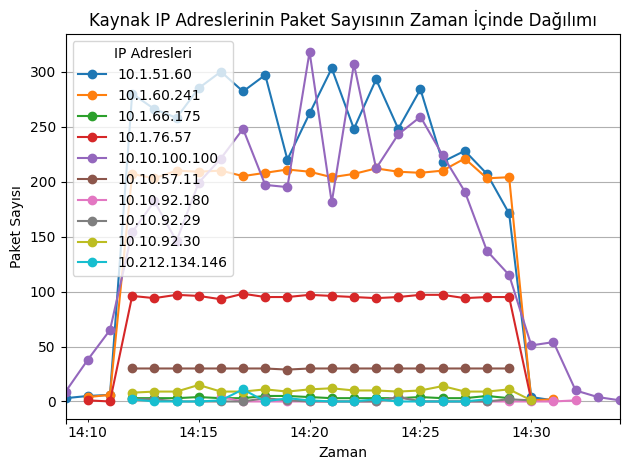

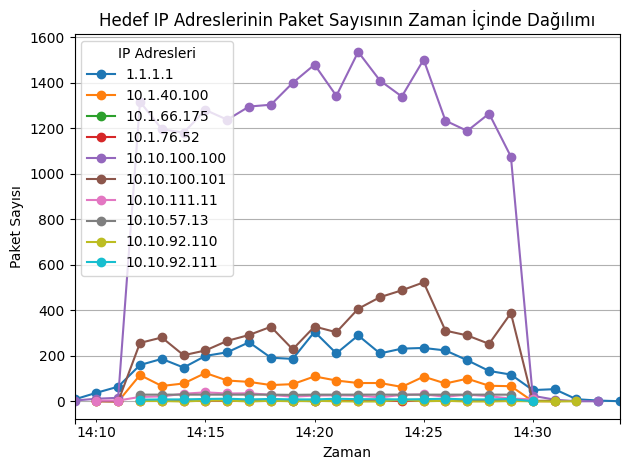

In [20]:
#################################### Siber saldırı Exfiltration
exfiltration_protocols_and_applications = ["FTP_CONTROL", "FTP_DATA", "HTTP", "HTTPS", "SMTP", "POP3", "IMAP", "DNS", "SSH", "Telnet", "RDP", "SMB"]
exfiltration_traffic = df[df['application_name'].isin(exfiltration_protocols_and_applications)]
exfiltration_top_senders = exfiltration_traffic.groupby('source_address')['package_count'].sum().sort_values(ascending=False).head(10)
exfiltration_top_receivers = exfiltration_traffic.groupby('destination_address')['package_count'].sum().sort_values(ascending=False).head(10)
print("Büyük veya olağandışı paket sayıları (exfiltration):\n", exfiltration_top_senders)
print("\nBüyük veya olağandışı paket sayıları (exfiltration):\n", exfiltration_top_receivers)


#### Source_address için
# Seçilen exfiltration IP adreslerini belirleme
selected_exfiltration_ips = exfiltration_top_senders.head(10).index.tolist()
# Seçilen IP adreslerine göre trafiği filtreleme
filtered_exfiltration_traffic = exfiltration_traffic[exfiltration_traffic['source_address'].isin(selected_exfiltration_ips)]
# Zaman serisi analizi için veriyi yeniden örnekleme
all_ip_senders = filtered_exfiltration_traffic.set_index('event_time').groupby('source_address').resample('T').size()
all_ip_senders.unstack(level=0).plot(marker='o', linestyle='-')
plt.title('Kaynak IP Adreslerinin Paket Sayısının Zaman İçinde Dağılımı')
plt.xlabel('Zaman')
plt.ylabel('Paket Sayısı')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='IP Adresleri', loc='upper left')
plt.tight_layout()
plt.show()

#### Destination_address için
# Seçilen exfiltration IP adreslerini belirleme
selected_exfiltration_destination_ips = exfiltration_top_receivers.head(10).index.tolist()
# Seçilen IP adreslerine göre trafiği filtreleme
filtered_exfiltration_traffic_destination = exfiltration_traffic[exfiltration_traffic['destination_address'].isin(selected_exfiltration_destination_ips)]

# Zaman serisi analizi için veriyi yeniden örnekleme
all_ip_receivers = filtered_exfiltration_traffic_destination.set_index('event_time').groupby('destination_address').resample('T').size()
all_ip_receivers.unstack(level=0).plot(marker='o', linestyle='-')
plt.title('Hedef IP Adreslerinin Paket Sayısının Zaman İçinde Dağılımı')
plt.xlabel('Zaman')
plt.ylabel('Paket Sayısı')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='IP Adresleri', loc='upper left')
plt.tight_layout()
plt.show()

Aşşağıdaki Kodun Çalışabilmesi için öncelikle Geoip2 City dosyası kurulu olmalıdır, Scriptin amacı Siber saldırılar yapan ip adreslerinin tespiti ve lokasyon bilgilerinin açığa çıkmasıdır.

In [ ]:
#################################### Konum tespit etme Bu koddların çalışması için Bilgisayar üzerinde GEOİP2 CİTY dosyası kurulmalıdır.

# Trafik türlerini belirleme
df['internal_to_internal_North_South'] = df.apply(
    lambda row: row['source_address'].startswith("192.168") and row['destination_address'].startswith("192.168"),
    axis=1)
df['internal_to_external_North_South'] = df.apply(
    lambda row: row['source_address'].startswith("192.168") and not row['destination_address'].startswith("192.168"),
    axis=1)
df['internal_to_internal_East_West'] = df.apply(
    lambda row: row['source_address'].startswith("10.10") and row['destination_address'].startswith("10.10"), axis=1)
df['internal_to_external_East_West'] = df.apply(
    lambda row: row['source_address'].startswith("10.10") and not row['destination_address'].startswith("10.10"),
    axis=1)

# GeoIP veritabanı yolu
geoip_db_path = 'GeoLite2-City_20240607/GeoLite2-City.mmdb'

# Lokasyon verilerini bulma fonksiyonu
def get_geo_info(ip_address):
    with geoip2.database.Reader(geoip_db_path) as reader:
        try:
            response = reader.city(ip_address)
            return {
                'ip': ip_address,
                'latitude': response.location.latitude,
                'longitude': response.location.longitude,
                'city': response.city.name,
                'country': response.country.name
            }
        except:
            return {
                'ip': ip_address,
                'latitude': None,
                'longitude': None,
                'city': None,
                'country': None
            }

# Harita oluşturma fonksiyonu
def create_map(df, internal_col, external_col, map_name):
    internal_traffic = df[df[internal_col]]
    external_traffic = df[df[external_col]]

    # IP adreslerinin lokasyonlarını al
    internal_locations = [get_geo_info(ip) for ip in internal_traffic['source_address'].tolist() + internal_traffic[
        'destination_address'].tolist()]
    external_locations = [get_geo_info(ip) for ip in external_traffic['source_address'].tolist() + external_traffic[
        'destination_address'].tolist()]

    # Harita oluşturma
    map_center = [20, 0]  # Haritanın ortalanacağı koordinatlar
    traffic_map = folium.Map(location=map_center, zoom_start=2)

    # İçten içe trafik noktalarını haritaya ekleme
    for loc in internal_locations:
        if loc['latitude'] and loc['longitude']:
            folium.Marker(
                location=[loc['latitude'], loc['longitude']],
                popup=f"Internal: {loc['ip']}\nCity: {loc['city']}\nCountry: {loc['country']}",
                icon=folium.Icon(color='blue')
            ).add_to(traffic_map)

    # İçten dışa trafik noktalarını haritaya ekleme
    for loc in external_locations:
        if loc['latitude'] and loc['longitude']:
            folium.Marker(
                location=[loc['latitude'], loc['longitude']],
                popup=f"External: {loc['ip']}\nCity: {loc['city']}\nCountry: {loc['country']}",
                icon=folium.Icon(color='red')
            ).add_to(traffic_map)

    # Haritayı kaydetme
    traffic_map.save(map_name)
    return traffic_map

# Kuzey-Güney için harita oluşturma
kuzey_guney_map = create_map(df, 'internal_to_internal_North_South', 'internal_to_external_North_South',
                             'kuzey_guney_traffic_map.html')

# Doğu-Batı için harita oluşturma
dogu_bati_map = create_map(df, 'internal_to_internal_East_West', 'internal_to_external_East_West',
                           'dogu_bati_traffic_map.html')
# Haritaları gösterme
kuzey_guney_map
dogu_bati_map

#################### 2 Türlüde çalışıyor aksaklık olması halinde 2 yönlüde çalışabilir.

df = pd.DataFrame()

# Trafik türlerini belirleme
df['internal_to_internal_North_South'] = df.apply(
    lambda row: row['source_address'].startswith("192.168") and row['destination_address'].startswith("192.168"),
    axis=1)
df['internal_to_external_North_South'] = df.apply(
    lambda row: row['source_address'].startswith("192.168") and not row['destination_address'].startswith("192.168"),
    axis=1)
df['internal_to_internal_East_West'] = df.apply(
    lambda row: row['source_address'].startswith("10.10") and row['destination_address'].startswith("10.10"), axis=1)
df['internal_to_external_East_West'] = df.apply(
    lambda row: row['source_address'].startswith("10.10") and not row['destination_address'].startswith("10.10"),
    axis=1)

# GeoIP veritabanı yolu
geoip_db_path = 'GeoLite2-City_20240607/GeoLite2-City.mmdb'


# Lokasyon verilerini bulma fonksiyonu
def get_geo_info(ip_address):
    with geoip2.database.Reader(geoip_db_path) as reader:
        try:
            response = reader.city(ip_address)
            return {
                'ip': ip_address,
                'latitude': response.location.latitude,
                'longitude': response.location.longitude,
                'city': response.city.name,
                'country': response.country.name
            }
        except:
            return {
                'ip': ip_address,
                'latitude': None,
                'longitude': None,
                'city': None,
                'country': None
            }


# Harita oluşturma fonksiyonu
def create_map(df, internal_col, external_col, map_name):
    internal_traffic = df[df[internal_col]]
    external_traffic = df[df[external_col]]

    # IP adreslerinin lokasyonlarını al
    internal_locations = [get_geo_info(ip) for ip in internal_traffic['source_address'].tolist() + internal_traffic[
        'destination_address'].tolist()]
    external_locations = [get_geo_info(ip) for ip in external_traffic['source_address'].tolist() + external_traffic[
        'destination_address'].tolist()]

    # Harita oluşturma
    map_center = [39.9334, 32.8597]  # Ankara koordinatları
    traffic_map = folium.Map(location=map_center, zoom_start=5)

    # İçten içe trafik noktalarını haritaya ekleme
    for loc in internal_locations:
        if loc['latitude'] and loc['longitude']:
            folium.Marker(
                location=[loc['latitude'], loc['longitude']],
                popup=f"Internal: {loc['ip']}\nCity: {loc['city']}\nCountry: {loc['country']}",
                icon=folium.Icon(color='blue')
            ).add_to(traffic_map)

    # İçten dışa trafik noktalarını haritaya ekleme
    for loc in external_locations:
        if loc['latitude'] and loc['longitude']:
            folium.Marker(
                location=[loc['latitude'], loc['longitude']],
                popup=f"External: {loc['ip']}\nCity: {loc['city']}\nCountry: {loc['country']}",
                icon=folium.Icon(color='red')
            ).add_to(traffic_map)

    # Haritayı kaydetme
    traffic_map.save(map_name)


# Tkinter penceresi oluşturma
root = tk.Tk()
root.withdraw()  # Tkinter penceresini gizleme

# Harita dosyasının kaydedileceği konumu seçme
file_path = filedialog.asksaveasfilename(defaultextension=".html", filetypes=[("HTML files", "*.html")])

# Haritaları oluşturma ve kaydetme
create_map(df, 'internal_to_internal_North_South', 'internal_to_external_North_South', file_path)
create_map(df, 'internal_to_internal_East_West', 'internal_to_external_East_West', file_path)

# Uygulamayı kapatma
root.destroy()






**Kullanılan Metadojiler.**
- Bu veri setinde alışık olmadığım fakat bir o kadar beni içerisine çeken ve araştırma yaparak öğrendiğim bir çok teknikle karşılaştım ve elimden geldiğince doğru ihtimali çok yüksek hissettiğim methodları uygulamaya çalıştım. Her kod satırını 3 sefer farklı kaynaklarla deneme yanılma yöntemiyle eşleştirme yaparak doğru yolda olup olmadığımı eğitmenimin kontrolüyle bu hale getirebildim.

- İlk olarak Keşifci Veri Analizi yaparak verinin tamamını inceledim burada kullandığım kütüphane pandas, Nunpy, Matplot, kütüphaneleri oldu.

- Sonrasında Numerik, Katagorik, Katagorik fakat Kardinal değişkenleri yakalayarak çalışmama devam ettim burada şunu fark ettim Date değişkeni numerik içeriği bulunduğundan dolayı Numerik Kolonlar sınıfına geçiyor bu yüzden date değişkenini ‘not in’ olarak dahil etmedim.

- Sonrasında Katagorik, Numerik değişkenlerin analizlerini yaptım, Burada benden Model kurmam istenilseydi bu kısımda analiz sonuçlarımı sizlerle paylaşırdım fakat ihtiyaç olmadığından dolayı veriye Göre Rare Encoding, Label Encoding, One hot Encoding işlemlerinin olduğunu gördüm ve olduğu gibi bırakmayı tercih ettim.

- Fakat burada yine veriye göre şunun tespitini gerçekleştirdim. Numerik değişkenlerin destination_address’e göre bakıldığında Bruteforce saldırıları ve ARP Scan, Exfiltration, Execution gibi siber saldırı analizi yaparken göz önünde bulundurulacak anlamlı verileri elde ettim bunlardan bağzıları (failed_attempts, application_name) ve Siber saldırı analizinde kullandım.

- Sonrasında Korelasyon analizi yaptım ve değişkenlerin arasındaki ilişki inceledim.

- Ardından Aykırı değer varmı ona baktım ve aykırı değer olduğunu boxplot ile tespitlerde bulundum. Burada kritik bir karar almam gerekiyordu bu aykırı değerlerle ilgili şu şekilde ilerlemeyi uygun gördüm. alt ve üst eşik değerleri normalde literatürde %25 e %75 olarak belirlenir bu aralıktaki veriyle çalışılması ve model kurulması önerilir fakat bu veride bu şekilde uygularsak bizden istenilen ağ trafiği verileri kaybolmuş, hatta Siber saldırıların tespitini yapmakta doğru sonuçlar almakta yanılgıya düşmüş olacaktık bu yüzden bu anormalikleri göz önünde bulundurarak çok ucundan bir threshold kullandım q1=0,05 ve q3=0.95 olarak kullanmayı tercih ettim burası tamamıyla benim yorumuma dayalı daha önce böyle bir veriyle çalışmadığım için biraz ürkek davrandım.

- Yine bu konuyla alakalı Silmek yerine Baskılama yönteminide kullanabilirdim Fakat network ağ verisiyle daha önce çalışmadığım için aykırı değerlere baskılama yöntemi uygulamadım, uygulasaydım verinin yapısı bozulup doğru sonuçlar alamayacaktım o yüzden olduğu gibi bırakmayı tercih ettim.

- Sonrasında Eksik değer analizinde bulundum ve içerisinde hiç veri bulunmayan NaN olan değerleri veriden sildim. bu kısımda böylesine alışık olmadığımdan dolayı veriye yaklaşırken silmeyi temizlemeyi verinin yapısını bozmak istemedim fakat verinin içerisinde bulunan ("ndr_name","server_side_using_capability","mail_recipient","request_uri_arr","tunnel_destination_address","tunnel_source_address") isimli kolonlar dikkatimi çekti içerisinde sadece NaN verileri bulunmaktaydı bunları sildim.

- Buraya kadar özet olarak Veri keşfi, Veri analizi, Anlamlı verilerin tespiti, Anormal verilerin tespitlerini yaptım.


**Trafik Analizi**
- Analize başlamadan önce internetten yaptığım araştırmalarımın sonucunda kullanmam gereken değişkenlerin listeleri; ‘source_address’, ‘destination_address’,’package_count’,’event_time’, ’direction’, ’source_port’, ‘destination_port’, kolonlarıydı.

- Kod akışında ( .resample(‘T’), .startswith(), sum(), .sort_values(), .groupby(), .set_index ) gibi pandas ve nunpy kütüphanelerini kullandım.

- Görselleştirmek için; matplot kütaphanesini kullandım.

- Kod akışı sırasında timer’ı .resample(‘T’) olarak kullandım farkındalık olması açısından T olan yere mili saniye isterseniz ‘ms’ olarakta bakılabilir fakat ben kod akışında ‘T’ ile ilerledim.

- İçten içe ve içten dışa trafik analizini yaparken source_address ( iç )  destination_address ( dış ) olarak belirledim sonrasında araştırmalarım doğrultusunda Kuzey ve Güney, Doğu ve Batı IP adreslerinin faklı olduklarını Kuzey ve Güney IP 192.168 ile başladıklarını Güney, Doğu IP 10.10 yaygın olarak kullanıldıklarını öğrendim.

- Buna göre ; Kuzey ve Güney’ e içten dışa en çok trafik yapılan saat dilimi 14:25 zaman diliminde yapıldığı tespit edilmiştir. Yine Kuzey ve Güney’e içten içe en çok trafik yapılan saat dilimi 14:13 ten 14:27 ye kadar stabilitesini korumuş inişli çıkışlı olağan üstü bir durum tespit edilmemiştir.

- Buna göre ; Doğu ve Batı’ya içten dışa en çok trafik yapılan saat dilimi 14:15 civarında en tepeye çıktığı görülmüş olup zaman çerçevesinde kademeli olarak 14:20, 14:25 olarak düşüşü tespit edilmiştir. Yine Doğu ve Batı’ya içten içe en çok trafik yapılan saat dilimi 14:18 de yükselip zaman çerçevesinde 1 kere düşüş görülüp tekrardan tepe seviyesine 14:28 de tespit edilmiştir.



Siber Saldırılar: **Port Taraması.**

- Port taraması yaparken gelen Maildeki yönlendirmeye dayanarak çıkarabileceğim fikir açık portların tespiti oldu; Çıktılar biraz geç geliyor 1 günün sonunda elde ettiğim toplam açık portlar bunlar oldu.

- İmport socket Pythonun içerisinde bulunuyor. Bu modül sayesinde TCP ve UDP protokollerini kullanarak ağ bağlantıları kurulabilir ve veri transferi gerçekleştirilebilir. Bunun sayesinde Port taramamızı gerçekleştirmiş olduk.



1.   Port 443 is open on 92.38.180.106
2.   Port 443 is open on 142.250.157.188
3.   Port 443 is open on 157.240.9.18
4.   Port 443 is open on 34.120.3.25
5.   Port 443 is open on 151.101.65.208
6.   Port 443 is open on 157.240.238.34









Siber Saldırılar: **ARP-Scan**

ARP analizi yaparken burada verinin içerisinde application_name adlı değişkenin içerisinde ARP-Request olduğunu fark ettim. Ardından araştırmalarımın sonucu ARP-Requestin hedef IP adresine istek atması sonucu bir saldırı olduğunu keşfettim ve kodu bu şekilde uyarladım.


Siber Saldırılar: **Lokasyon Tespiti**

Ağ Trafik verisi Case’in çalışmasını ,araştırmasını yaparken Pythonun Geoip2 kütüphanesinin olduğunu ve bu kütüphanenin konum tespiti yaptığının ve bana atanan bu Casedeki En çok trafik yapan içten içe – içten dışa IP adreslerinin Lokasyon bilgilerine ve IP adreslerine ulaştım Biraz uzun bir işlem veri setinde ben ağ trafiğine göre uyarladım, İstenildiği taktirde Siber saldırıların da Kimler tarafından ve nereden Saldırıldığının bilgisinede uyarlanabilir.

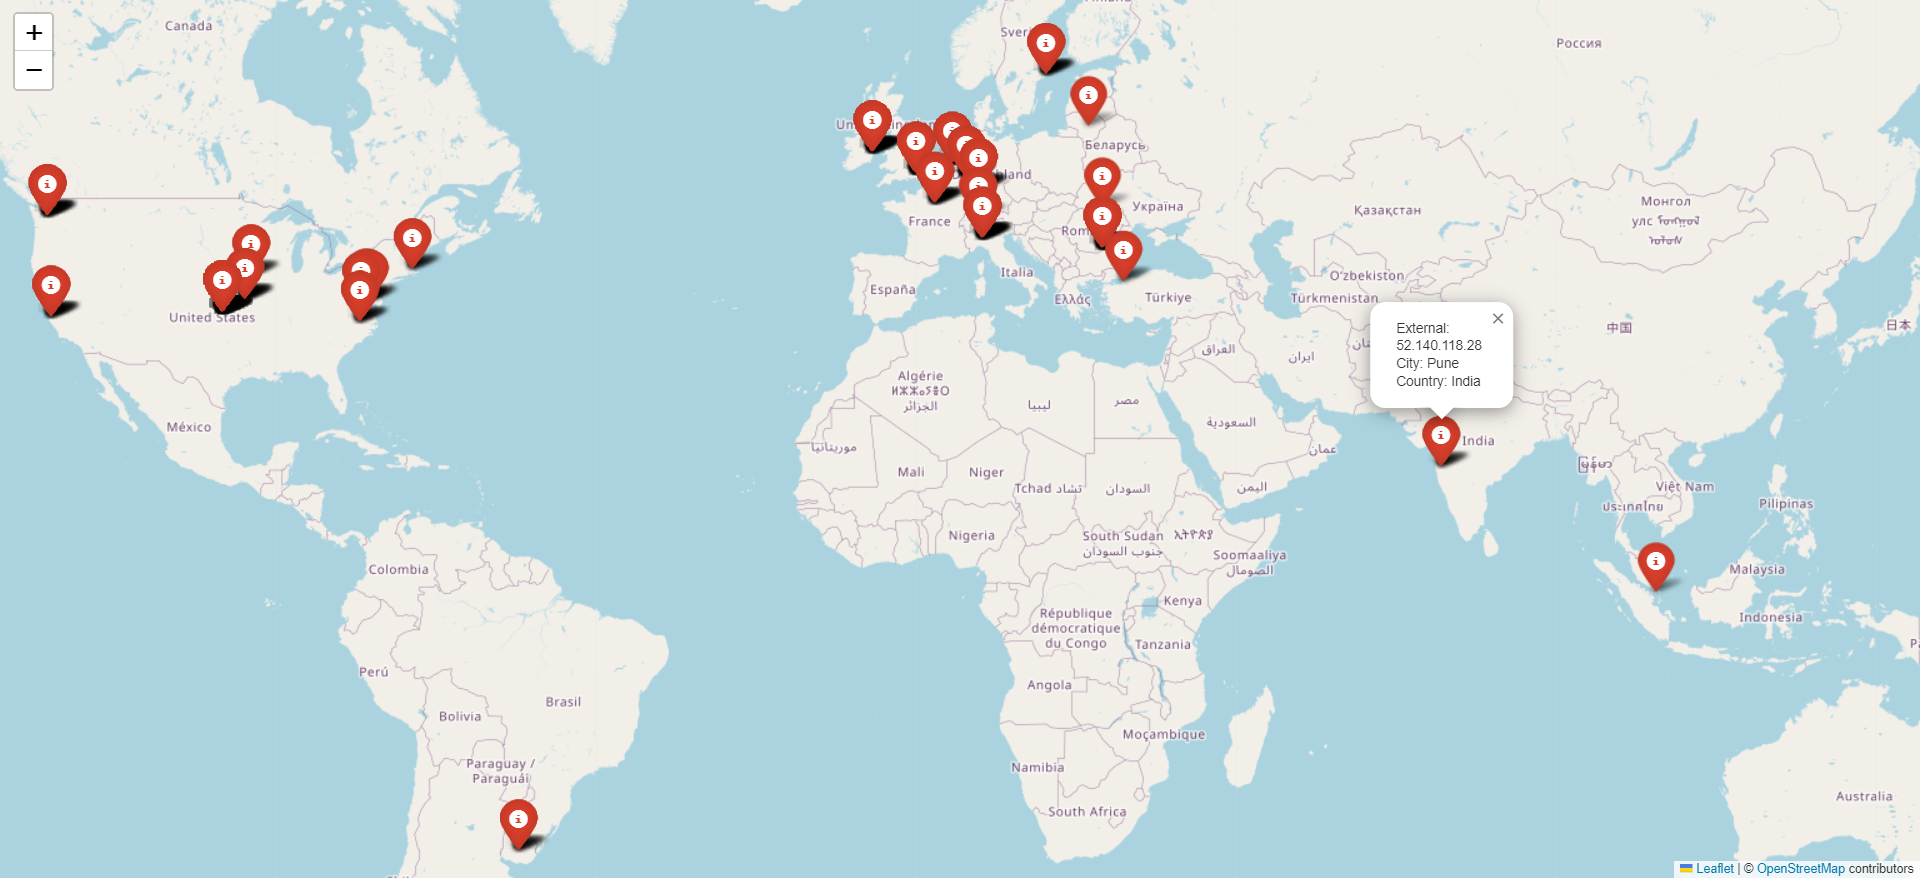